In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point, Polygon, LineString
from tqdm import tqdm
import os

import util

### UTIL

In [6]:
TEMPORAL_GRANULARITY = 0.4

def get_frame_nb(rel_time):
    return int(rel_time/TEMPORAL_GRANULARITY) + 1

In [7]:
def crop_img_rect(pts, img):
    cnt = pts
    rect = cv2.minAreaRect(cnt)
    
    im_crop, _ = crop_rect(img, rect)
    
    return im_crop


def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center = rect[0]
    size = rect[1]
    angle = rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    rows, cols = img.shape[0], img.shape[1]

    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (cols, rows))
    out = cv2.getRectSubPix(img_rot, size, center)

    return out, img_rot

In [8]:
def show_image_inline(img, trans_level=1, figsize=None):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(img, alpha=trans_level)
    plt.show(block=False)
        
    return


# BBOX, CIRCLE, LINE, TEXTS
def draw(frame, objects, objects_type="bbox", color=(0, 0, 255)):
    if objects_type == "bbox":
        #frame = cv2.drawContours(frame, objects, 0, color, 3)
        for obj in objects:
            frame = cv2.drawContours(frame, np.array([obj]), 0, color, 3)
    elif objects_type == "circle":
        for obj in objects:
            frame = cv2.circle(frame, obj, radius=0, color=color, thickness=20)
    elif objects_type == "line":
        for obj in objects:
            frame = cv2.line(frame, obj[0], obj[1], color, 3)
    elif objects_type == "text":
        for obj in objects:
            frame = cv2.putText(frame, str(obj), c, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    
    return frame

In [10]:
def get_video_timestamp(pth):
    tmp = [_ for _ in pneuma_vision_video_path.split("/") if len(_)>0][-1].split("_")
    year_month_day = tmp[0]
    year = int(year_month_day[:4])
    month = int(year_month_day[4:6])
    day = int(year_month_day[6:])
    hour_min = tmp[-2]
    hour = int(hour_min[:2])
    minute = int(hour_min[-2:])

    #return datetime(year=year, month=month, day=day, hour=hour, minute=minute)
    return timedelta(hours=hour, minutes=minute)

def get_abs_timestamp(video_timestamp, relative_timestamp):
    abs_timestamp = video_timestamp + timedelta(seconds=round(float(relative_timestamp)))
    
    return abs_timestamp.total_seconds()


# annot.Type = ['Medium Vehicle', 'Motorcycle', 'Car', 'Taxi', 'Heavy Vehicle', 'Bus']
def get_frame_annot(frame_name, v_type_filter="Car", annot_post_process=True):
    pneuma_vision_frame_path = os.path.join(pneuma_vision_video_path, "Frames")
    pneuma_vision_annot_path = os.path.join(pneuma_vision_video_path, "Annotations")
    frame = cv2.imread(os.path.join(pneuma_vision_frame_path, frame_name+".jpg"))
    annot = pd.read_csv(os.path.join(pneuma_vision_annot_path, frame_name+".csv"))
    if v_type_filter is not None:
        annot = annot[annot.Type == v_type_filter]
    
    def get_bbox_from_detection_results(pt, res):
        for bb in res:
            if Polygon(bb).contains(Point(pt)):
                return bb
        return None
    
    if annot_post_process:
        model = util.get_oriented_rcnn_model()

        preds = util.predict_img(frame, model, oriented_rcnn=True, path=False)
        preds = np.array([util.from_rbbox_to_4pts(_)[0] for _ in preds[0]])

        # Get the bbox using oriented-rcnn model
        annot["bbox"] = annot.apply(lambda x: get_bbox_from_detection_results(x[["x_img [px]", "y_img [px]"]], preds), axis=1)
        # Get only a subset of annotations where the bbox is available
        annot = annot.dropna()

        annot["AbsTime [s]"] = annot.apply(lambda x: get_abs_timestamp(video_timestamp, x["Time [s]"]), axis=1)

    return frame, annot

### INPUT

In [11]:
pneuma_vision_video_path = "/home/yura/data/PNEUMAVISION/20181029_D10_0900_0930/"

frame_list = sorted([p.split(".")[0] for p in os.listdir(os.path.join(pneuma_vision_video_path, "Frames"))])
video_timestamp = get_video_timestamp(pneuma_vision_video_path)

In [31]:
HISTORICAL_NB = 10

### Example - Visualization

In [12]:
frame, annot = get_frame_annot("00278")

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


In [13]:
pts = annot[["x_img [px]", "y_img [px]"]].values
bbs = annot["bbox"].values

In [14]:
class VirtualLoopDetector:
    src_coord, dst_coord = None, None
    src_line, dst_line = None, None
    src_poly, dst_poly = None, None
    
    def __init__(self, drone_id):
        if drone_id == 10:
            self.src_coord, self.dst_coord = [(3060, 1070), (3060, 1215)], [(2120, 1055), (2120, 1190)]
        self.src_line, self.dst_line = LineString(self.src_coord), LineString(self.dst_coord)
        self.src_poly, self.dst_poly = self.get_poly()
    
    def get_poly(self):
        src_coord_bis, dst_coord_bis = map(lambda c: [(c[0][0]+20, c[0][1]), (c[1][0]+20, c[1][1])], [self.src_coord, self.dst_coord])
        src_poly, dst_poly = map(lambda x: Polygon([x[0][0], x[1][0], x[1][1], x[0][1]]), [[self.src_coord, src_coord_bis], [self.dst_coord, dst_coord_bis]])
        
        return src_poly, dst_poly
    
    def visualize_VLD_on_frame(self, img, color=(0, 255, 0)):
        img = img.copy()
        for poly in [self.src_poly, self.dst_poly]:
            coords = poly.exterior.coords
            coords = coords[:-1] if coords[0] == coords[-1] else coords
            coords = list(map(lambda _: list([int(_[0]), int(_[1])]), coords))
            
            img = draw(img, [coords], objects_type="bbox", color=color)
                    
        return img

In [15]:
# Virtual Loop Detector - Drone 10
LD = VirtualLoopDetector(10)

In [16]:
show_image_inline(frame)

In [17]:
show_image_inline(LD.visualize_VLD_on_frame(frame))

In [18]:
annot.head()

Time [s]   ID Type  x_img [px]  y_img [px]  Angle_img [rad]  \
11     110.8   60  Car        1146        1126         3.160315   
34     110.8  168  Car         953        1122         3.157615   
40     110.8  186  Car        3589        1879         1.590215   
41     110.8  188  Car        2545         476         4.587015   
43     110.8  192  Car        1532        1145         3.096315   

                                                 bbox  AbsTime [s]  
11  [[1133, 1118], [1168, 1118], [1168, 1133], [11...      32511.0  
34  [[947, 1116], [976, 1117], [976, 1129], [947, ...      32511.0  
40  [[3575, 1893], [3576, 1858], [3594, 1858], [35...      32511.0  
41  [[2534, 492], [2534, 460], [2550, 460], [2550,...      32511.0  
43  [[1518, 1136], [1555, 1135], [1555, 1152], [15...      32511.0

In [19]:
frame = draw(frame, np.array([LD.src_coord, LD.dst_coord]), objects_type="line", color=(0, 255, 0))
frame = draw(frame, pts, objects_type="circle")

In [20]:
show_image_inline(frame, figsize=(10, 20))

In [21]:
show_image_inline(draw(frame, bbs, objects_type="bbox", color=(0, 255, 0)), figsize=(10, 20))

In [22]:
def check_overlaps(frame, annot, src_poly, dst_poly, start_dict, end_dict):
    for (_, v_feat) in annot.iterrows():
        v_id = v_feat["ID"]
        c = Point([v_feat["x_img [px]"], v_feat["y_img [px]"]])
        if src_poly.contains(c) and v_id not in start_dict.keys():
            start_dict[v_id] = v_feat["Time [s]"]
        if dst_poly.contains(c) and v_id in start_dict.keys() and v_id not in end_dict.keys():
            end_dict[v_id] = v_feat["Time [s]"]

    return start_dict, end_dict

In [29]:
start_dict, end_dict = {}, {}

for f_name in tqdm(frame_list):
    frame, annot = get_frame_annot(f_name, annot_post_process=False)
    start_dict, end_dict = check_overlaps(frame, annot, LD.src_poly, LD.dst_poly, start_dict, end_dict)

100%|███████████████████████████████████████| 1907/1907 [03:33<00:00,  8.92it/s]


In [63]:
start_dict.pop(162)
end_dict.pop(162)

3.6

In [32]:
travel_time = {}
for key in sorted(list(set(start_dict.keys()).intersection(set(end_dict.keys())))):
    delta_time = end_dict[key] - start_dict[key]
    if delta_time > HISTORICAL_NB * TEMPORAL_GRANULARITY:
        travel_time[key] = delta_time
        #print(start_dict[key], end_dict[key])
    else:
        start_dict.pop(key)
        end_dict.pop(key)
        
travel_time

{60: 26.8,
 61: 26.0,
 62: 32.400000000000006,
 160: 31.599999999999998,
 161: 31.6,
 162: 23.2,
 164: 34.4,
 168: 33.599999999999994,
 169: 32.8,
 175: 32.80000000000001,
 192: 25.599999999999994,
 205: 46.0,
 210: 22.400000000000002,
 212: 48.800000000000004,
 213: 47.199999999999996,
 222: 19.599999999999998,
 229: 22.799999999999997,
 236: 24.39999999999999,
 237: 25.200000000000003,
 245: 25.599999999999994,
 261: 25.599999999999994,
 269: 25.200000000000003,
 274: 28.799999999999997,
 286: 24.80000000000001,
 304: 20.39999999999999,
 311: 23.60000000000001,
 324: 25.599999999999994,
 332: 26.400000000000006,
 347: 16.400000000000006,
 382: 24.80000000000001,
 406: 24.80000000000001,
 413: 17.599999999999994,
 417: 20.39999999999999,
 424: 21.60000000000001,
 429: 24.799999999999997,
 432: 17.200000000000003,
 434: 24.0,
 438: 21.599999999999994,
 445: 23.599999999999994,
 455: 20.39999999999999,
 456: 23.19999999999999,
 457: 24.0,
 461: 23.60000000000001,
 464: 21.99999999999998

In [105]:
np.max(list(travel_time.values()))

98.4

In [109]:
for k in travel_time.keys():
    if travel_time[k] > 95:
        print(k)

638
648
656
661
667
676


In [110]:
start_dict[638]

188.8

In [51]:
frame, annot = get_frame_annot("%05d" % (start_dict[638] / 0.4 + 1))

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


In [ ]:
def get_pt_from_annot(df):
    return df[["x_img [px]", "y_img [px]"]].values

def from_time_to_frame(t):
    return int(t / TEMPORAL_GRANULARITY) + 1

def investigate_vehicle_between_entry_exit(veh_id, start_dict, end_dict):
    start_t, end_t = start_dict[veh_id], end_dict[veh_id]
    start_fr, end_fr = from_time_to_frame(start_t), from_time_to_frame(end_t)
    
    for nb_fr in range(start_fr, end_fr):
        frame, annot = get_frame_annot("%05d" % nb_fr)
        pt = get_pt_from_annot(annot[annot.ID == veh_id])
        show_image_inline(draw(frame, pt, objects_type="circle"))
        
    return

#investigate_vehicle_between_entry_exit(638, start_dict, end_dict)

In [38]:
def data_ls_train_test_split(ls, ratio=0.7):
    import random
    
    random.seed(7)
    
    train = random.sample(ls, int(len(ls)*ratio))
    test = list(set(ls) - set(train))
    
    return train, test

In [39]:
train_v_ids, test_v_ids = data_ls_train_test_split(travel_time.keys(), 0.7)

In [40]:
np.median(list([travel_time[k] for k in train_v_ids]))

36.0

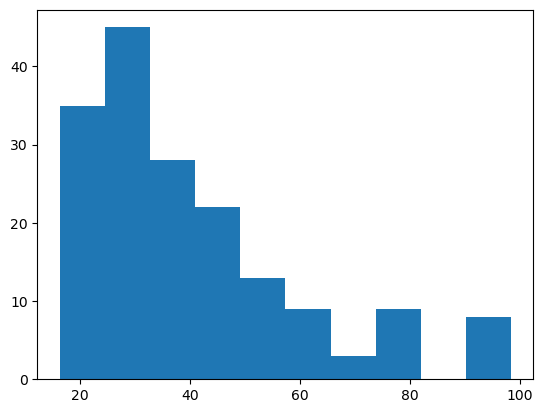

In [41]:
plt.hist(travel_time.values())
plt.show()

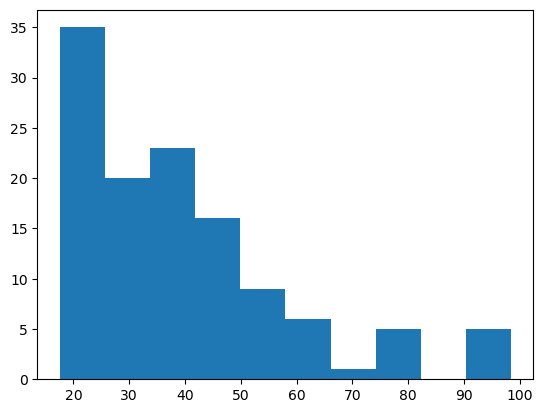

In [42]:
plt.hist([travel_time[k] for k in train_v_ids])
plt.show()

(array([13., 15.,  4.,  4.,  3.,  4.,  2.,  4.,  0.,  3.]),
 array([16.4 , 24.44, 32.48, 40.52, 48.56, 56.6 , 64.64, 72.68, 80.72, 88.76, 96.8 ]),
 <BarContainer object of 10 artists>)

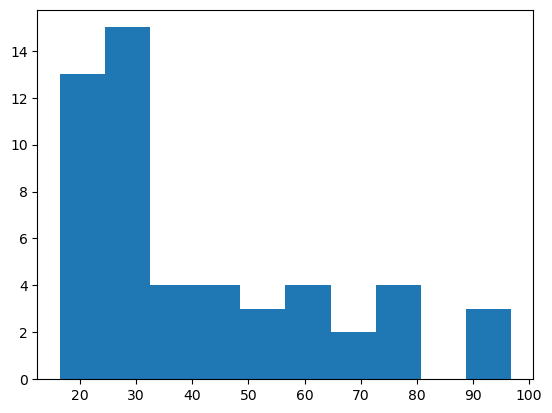

In [43]:
plt.hist([travel_time[k] for k in test_v_ids])

In [58]:
def get_v_patches(v_id, start_dict, end_dict):
    start_frame_nb = get_frame_nb(start_dict[v_id])
    end_frame_nb = get_frame_nb(end_dict[v_id])
    
    start_frame, start_annot = get_frame_annot("%05d" % (start_frame_nb))
    end_frame, end_annot = get_frame_annot("%05d" % (end_frame_nb))
    
    start_bbox = start_annot[start_annot.ID == v_id]["bbox"].values
    start_v_patch = crop_img_rect(start_bbox[0], start_frame) if len(start_bbox)>0 else None
    end_bbox = end_annot[end_annot.ID == v_id]["bbox"].values
    end_v_patch = crop_img_rect(end_bbox[0], end_frame) if len(end_bbox)>0 else None
        
    return start_v_patch, end_v_patch

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  60


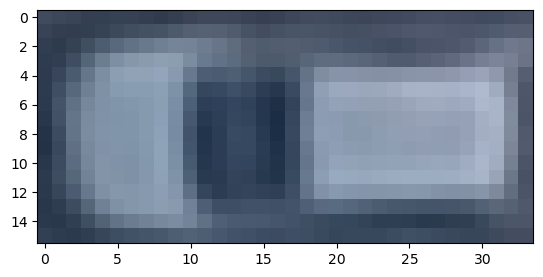

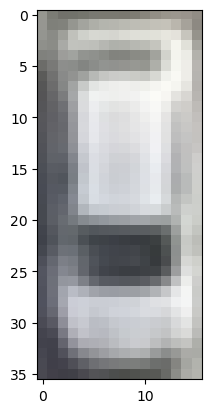

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  61


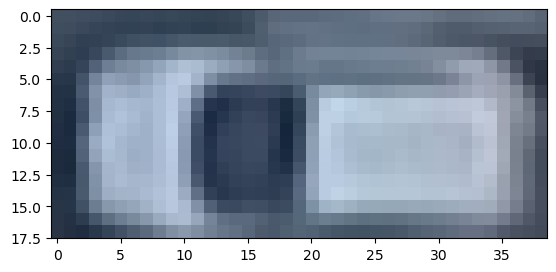

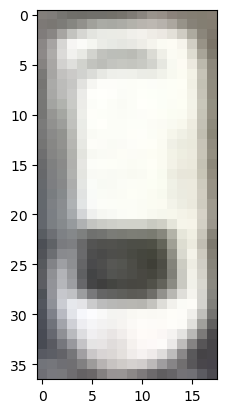

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  62


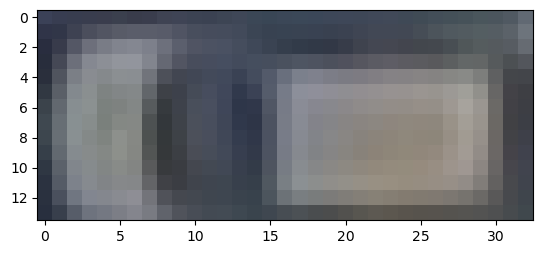

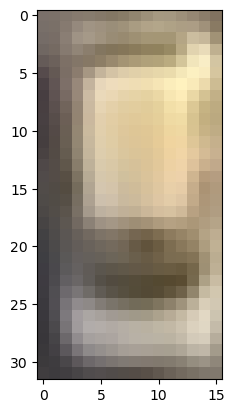

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  160


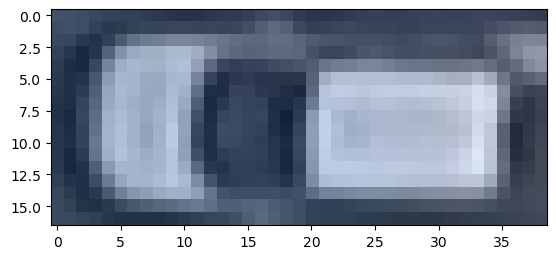

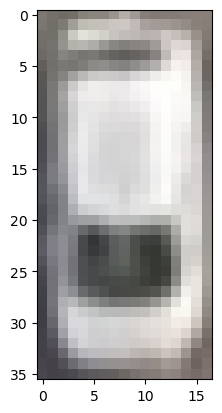

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  161


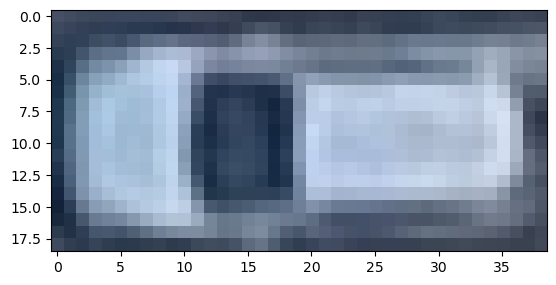

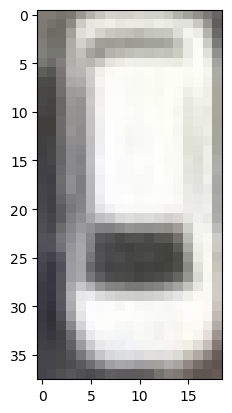

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  164


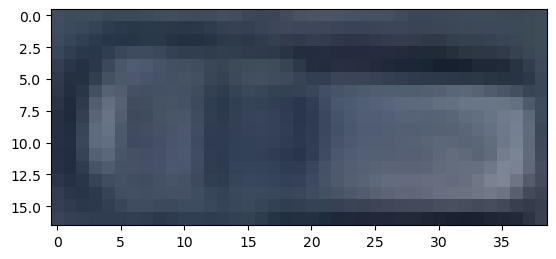

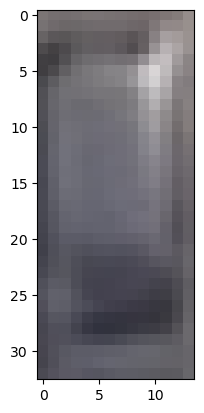

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  192


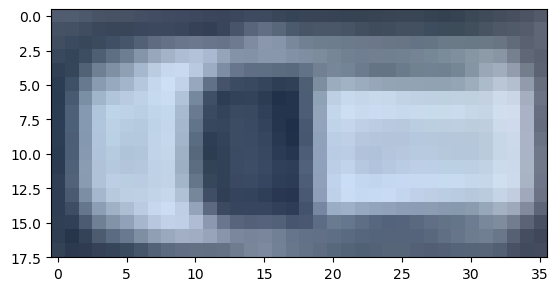

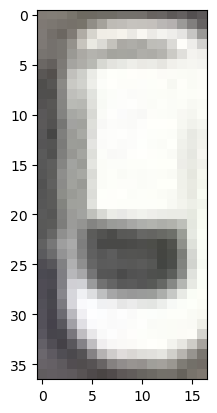

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  205


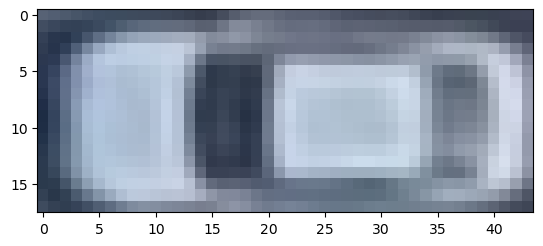

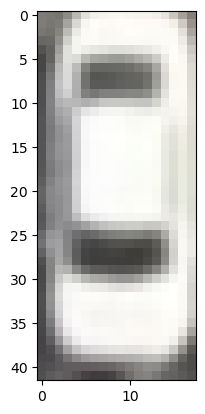

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  212


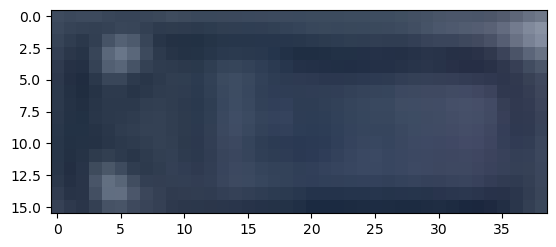

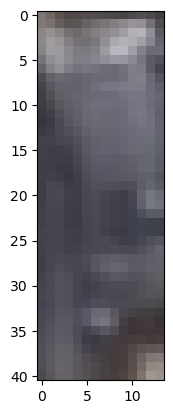

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  213


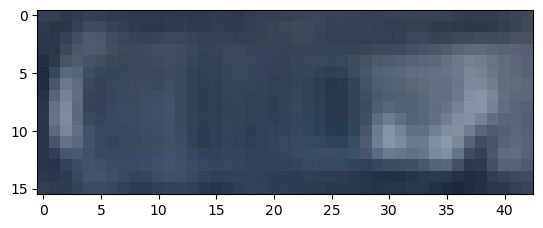

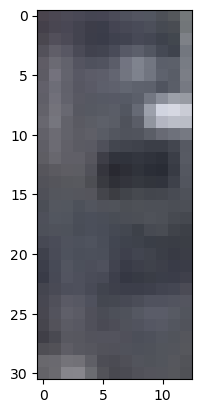

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  222


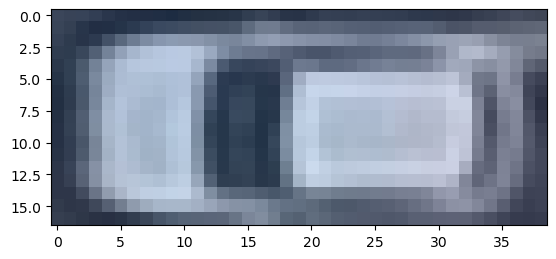

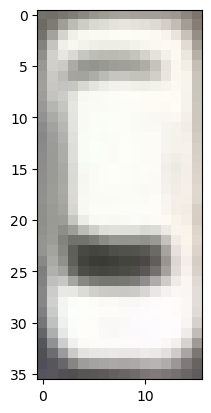

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  229


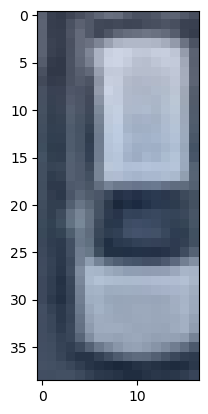

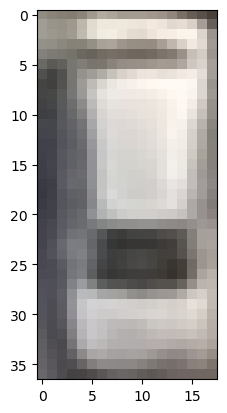

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  236


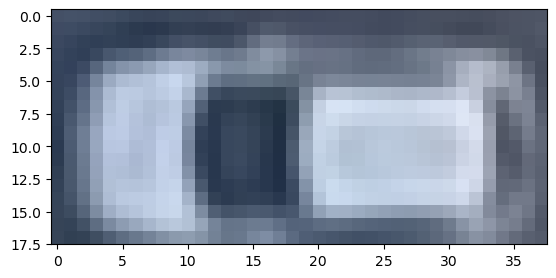

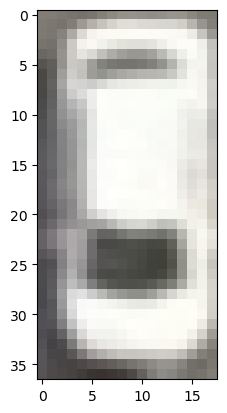

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  237


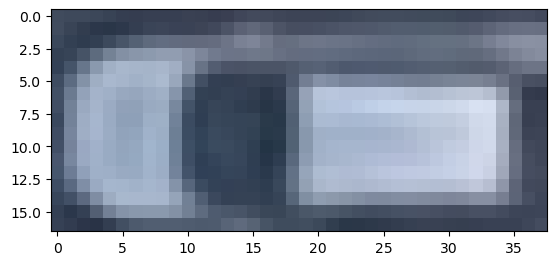

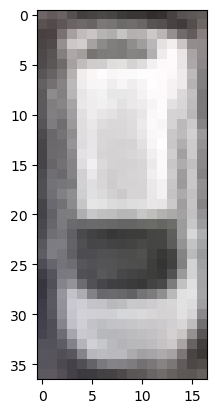

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  261


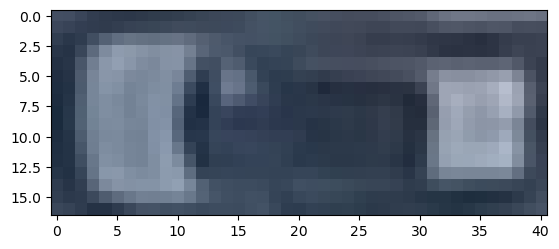

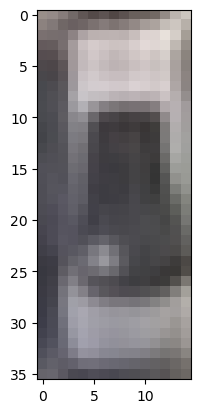

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  274


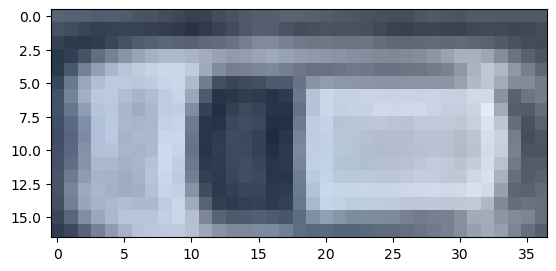

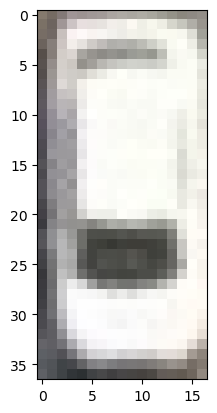

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  304


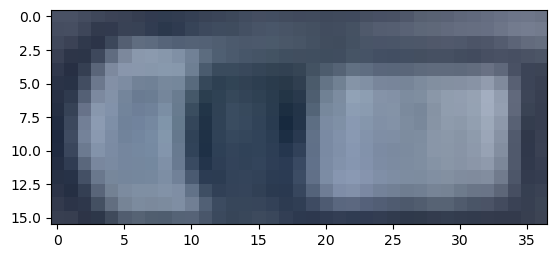

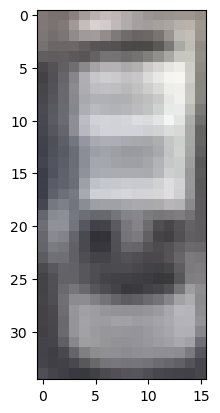

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_l

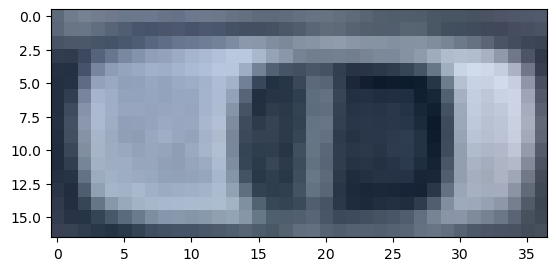

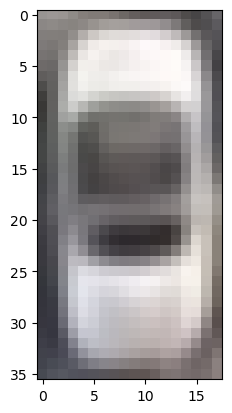

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  417


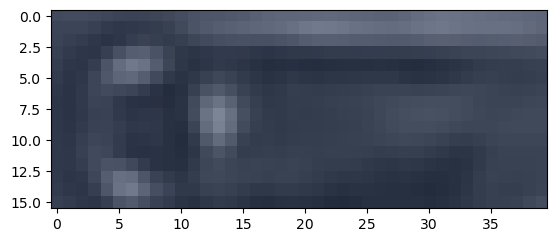

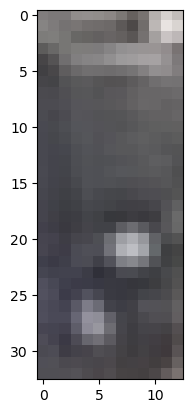

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  424


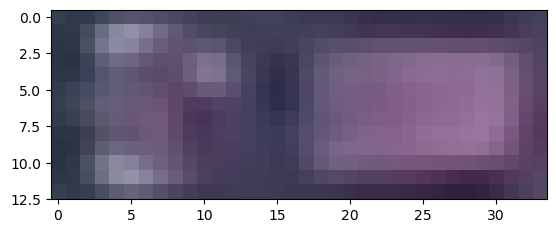

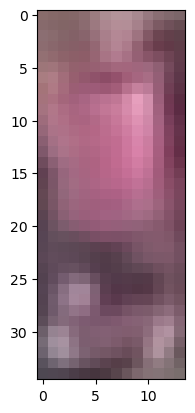

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  429


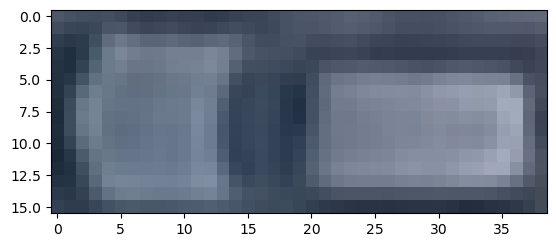

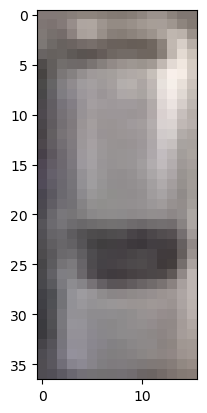

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  432


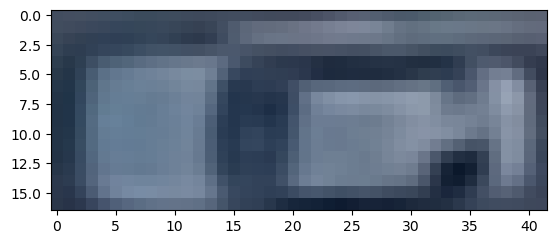

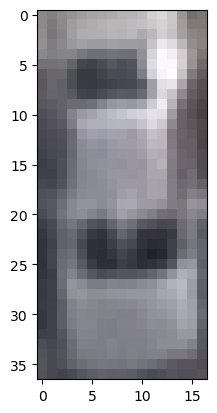

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  438


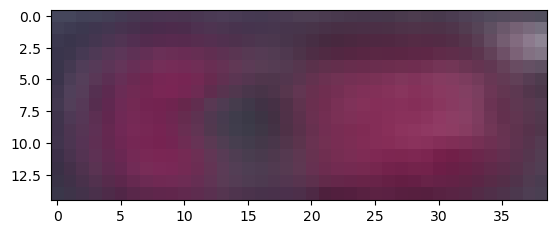

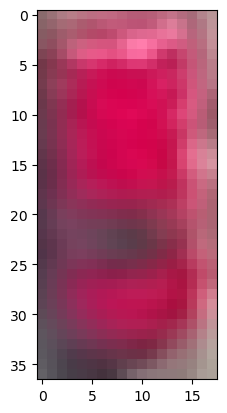

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  455


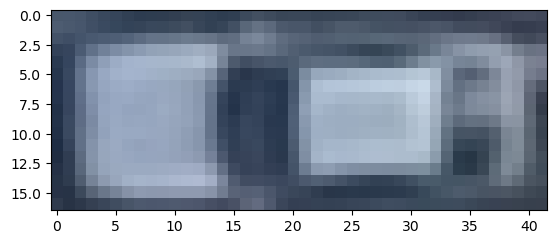

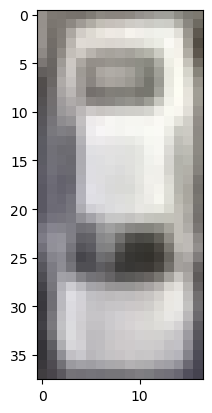

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  456


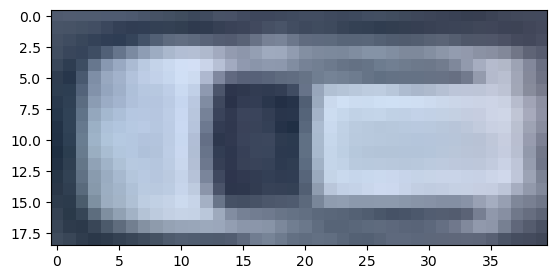

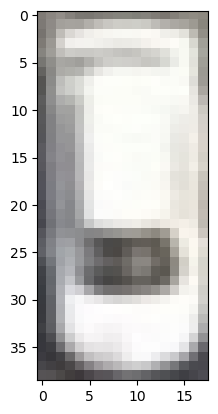

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  457


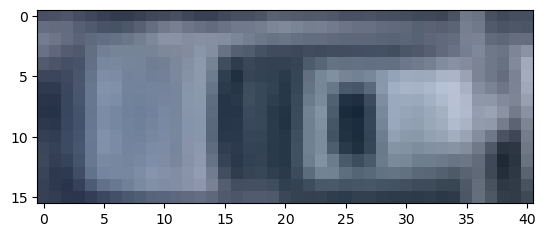

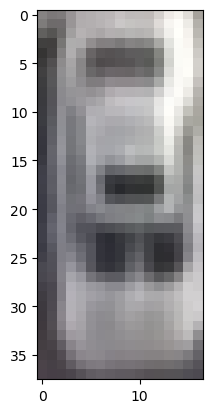

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  461


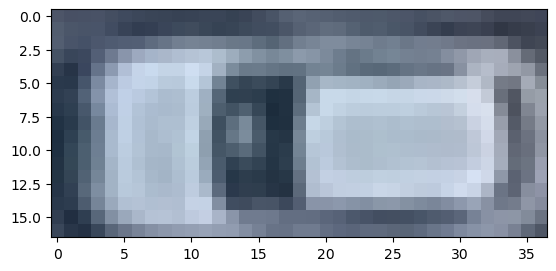

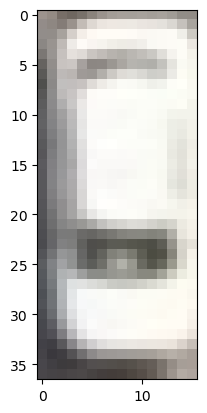

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  471


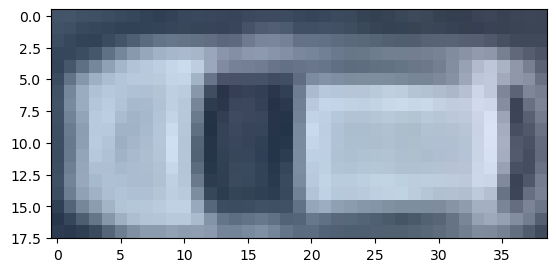

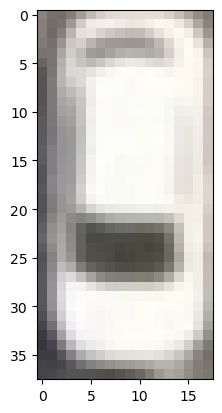

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  473


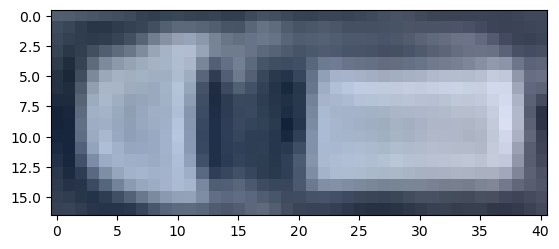

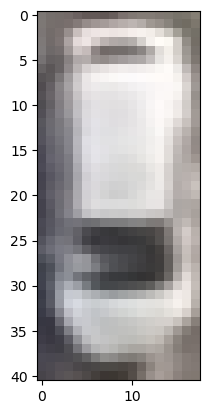

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  477


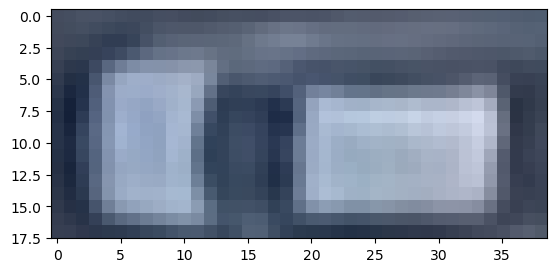

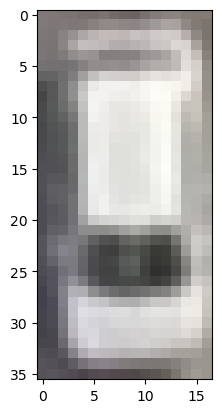

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  490


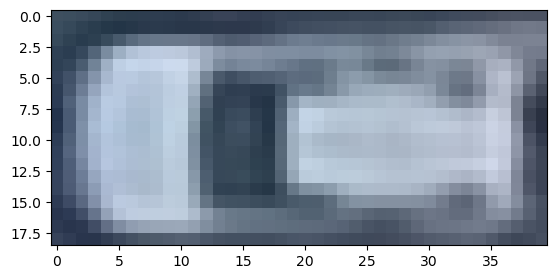

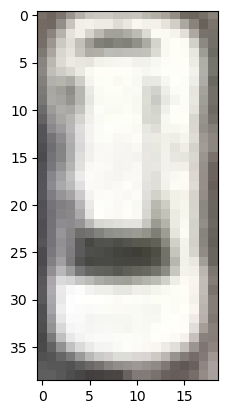

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  495


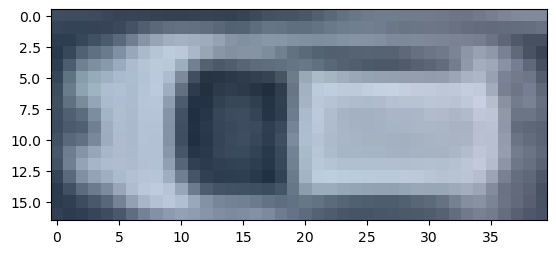

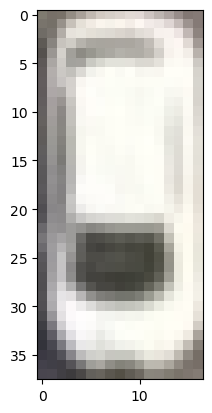

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  504


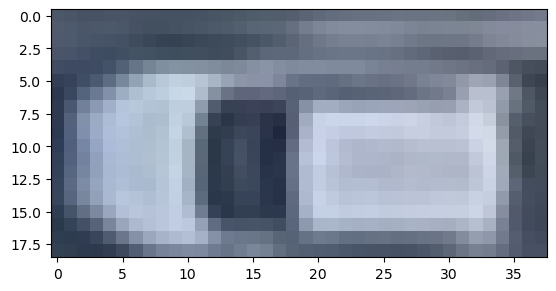

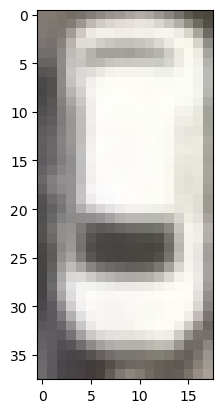

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  560


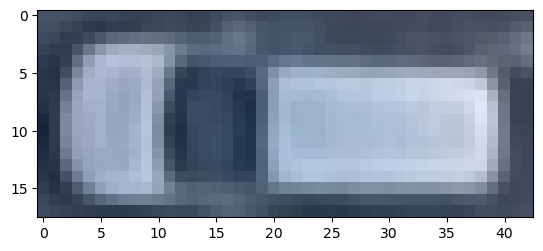

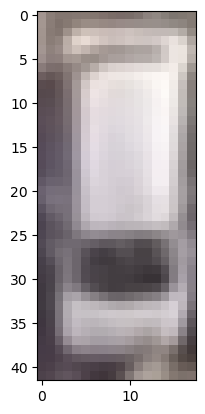

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  589


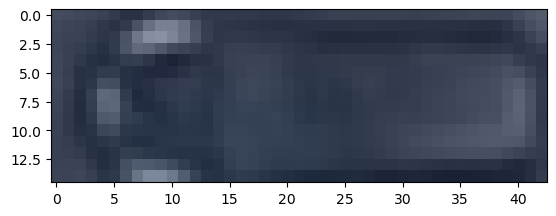

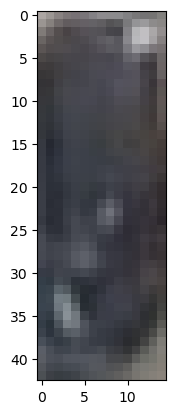

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  616


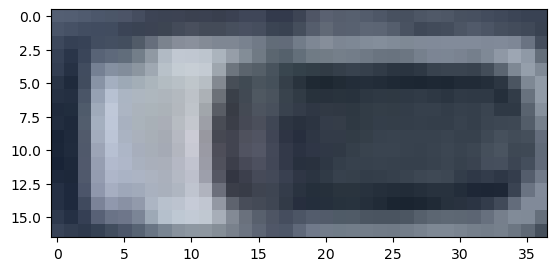

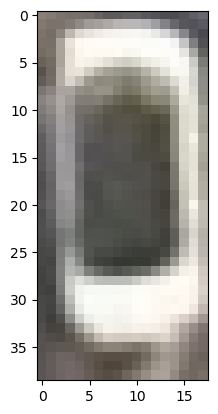

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  630


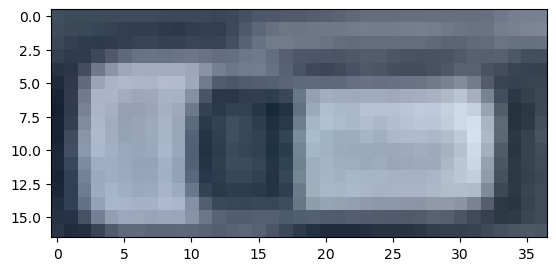

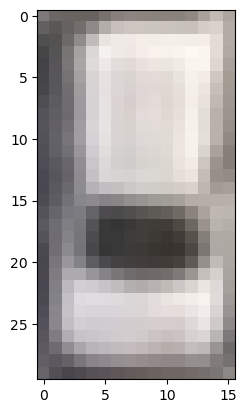

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  631


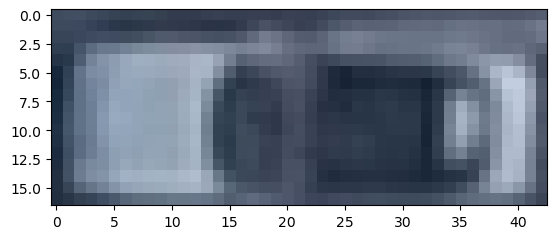

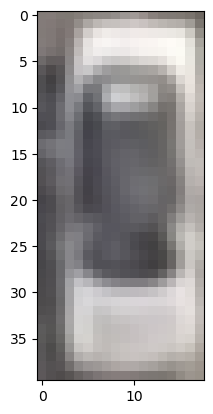

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  635


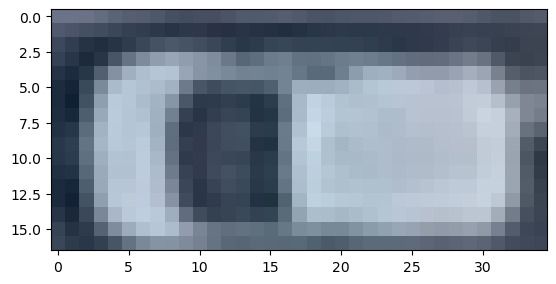

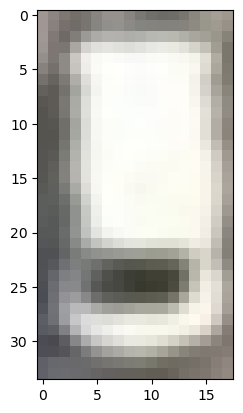

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  648


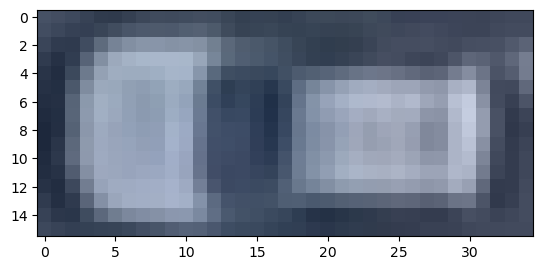

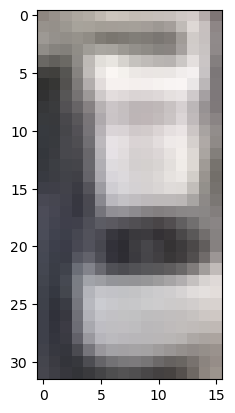

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  649


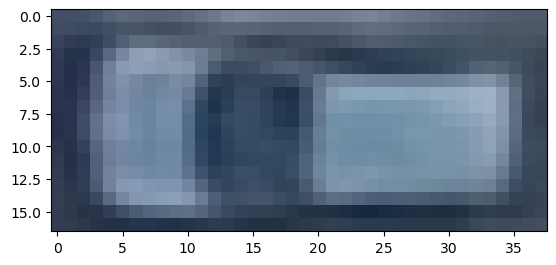

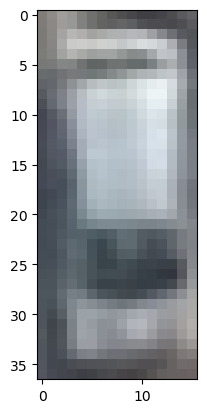

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  653


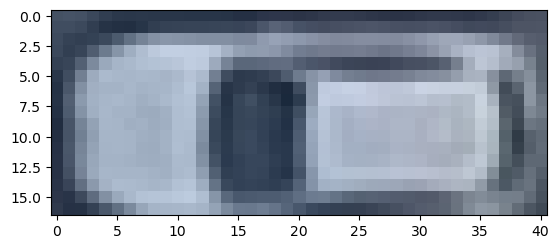

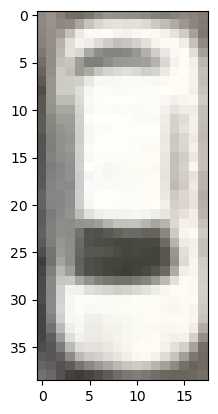

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  659


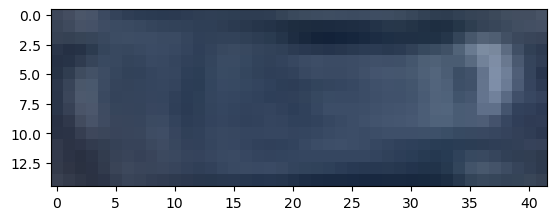

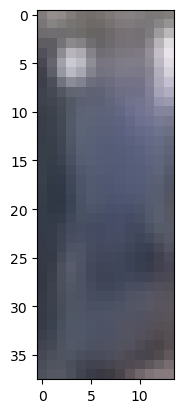

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  661


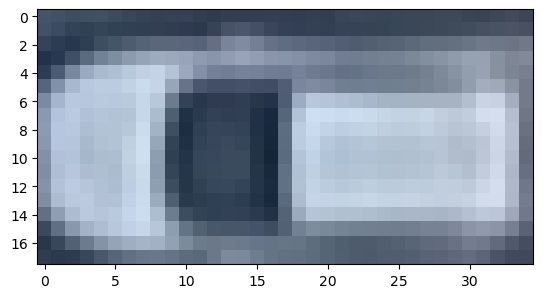

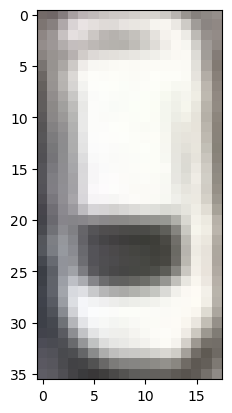

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  664


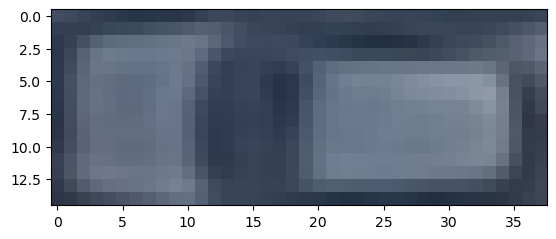

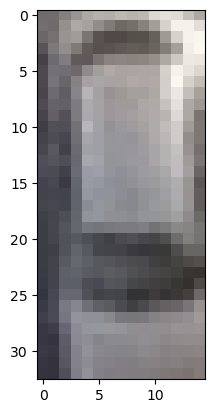

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  667


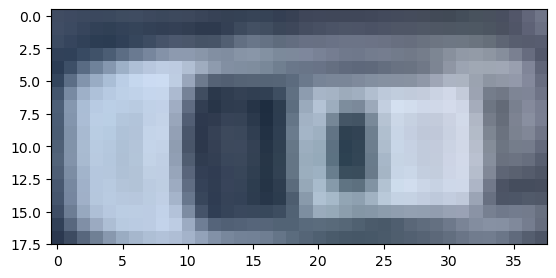

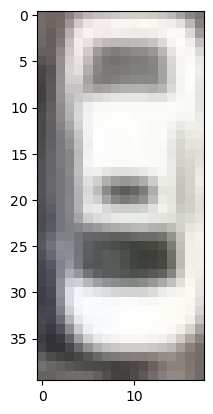

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  670


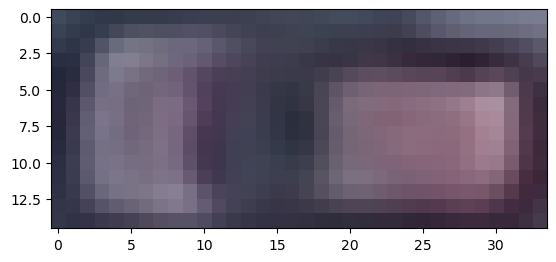

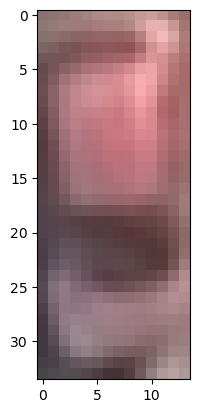

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  688


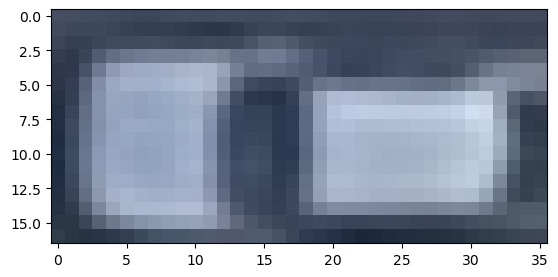

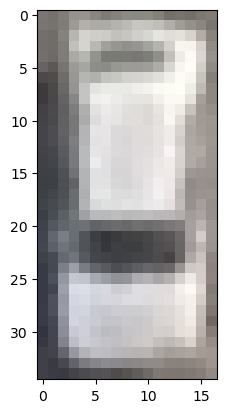

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  696


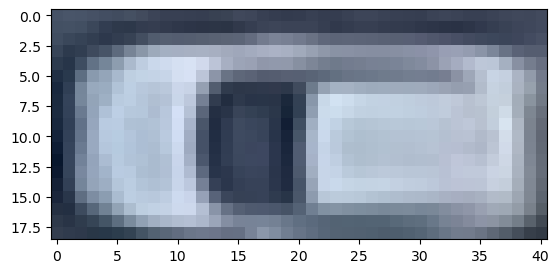

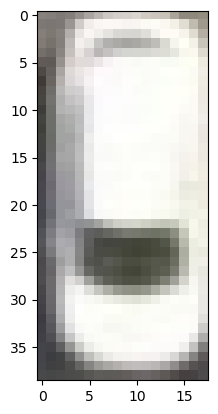

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  699


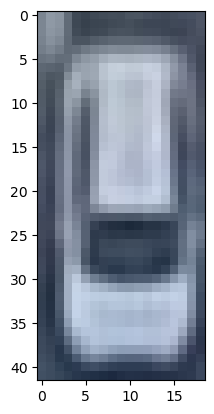

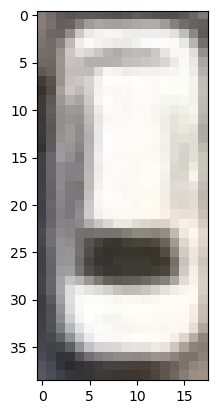

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  704


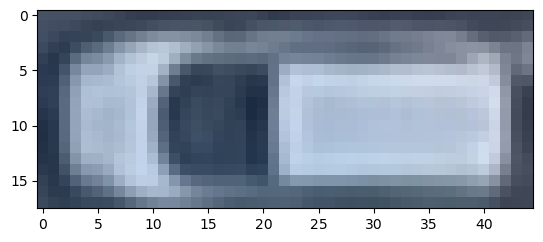

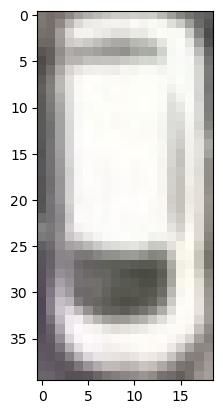

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  730


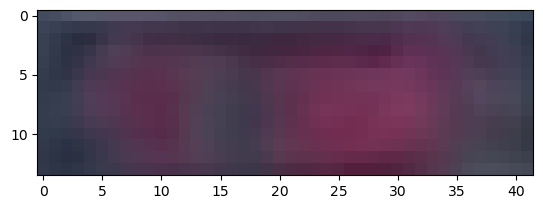

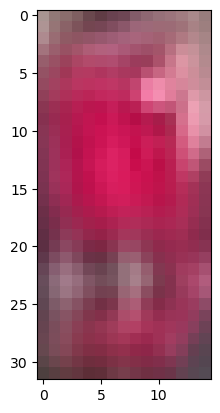

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  731


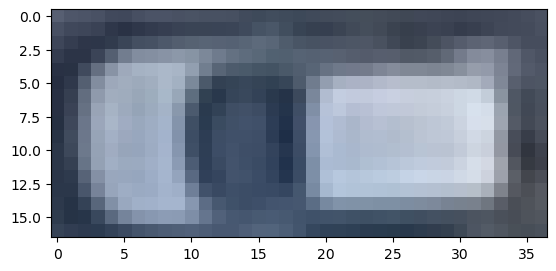

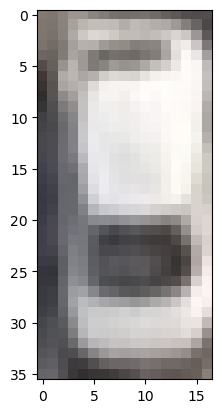

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  743


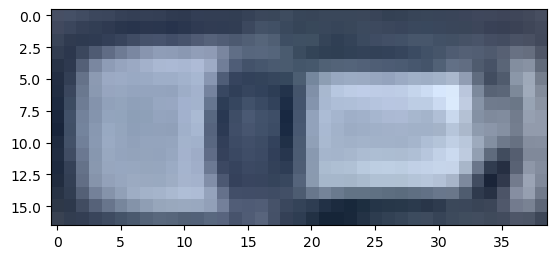

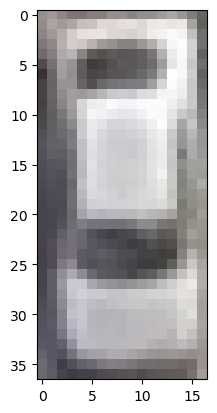

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  744


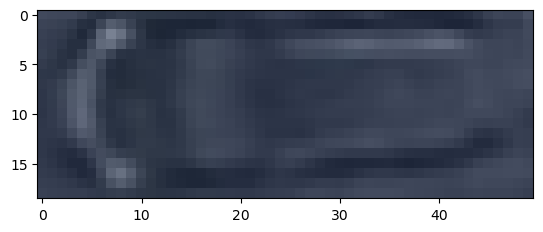

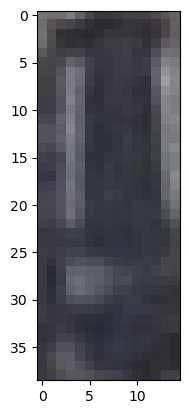

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  749


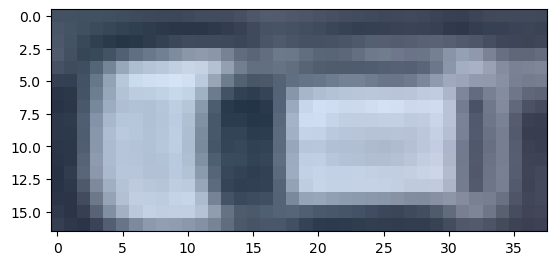

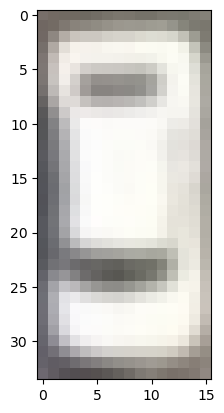

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  785


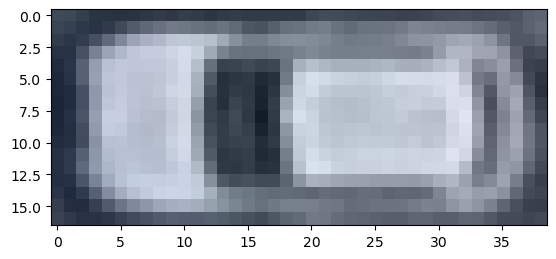

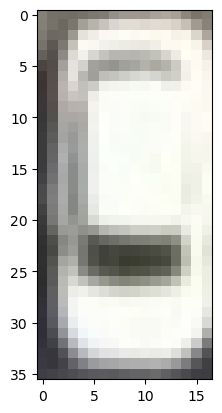

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  807


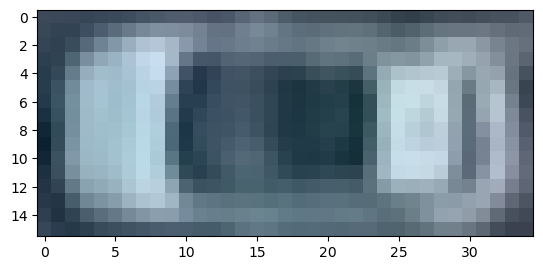

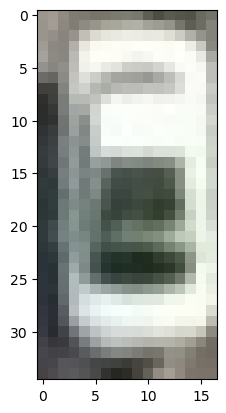

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  829


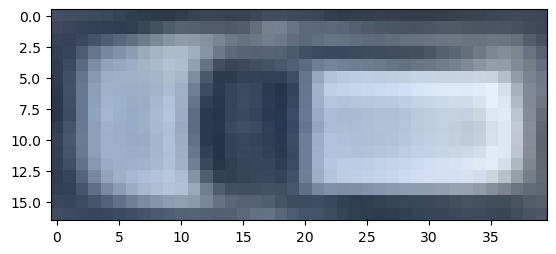

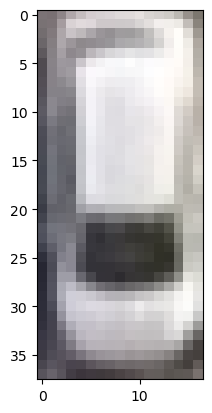

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  832


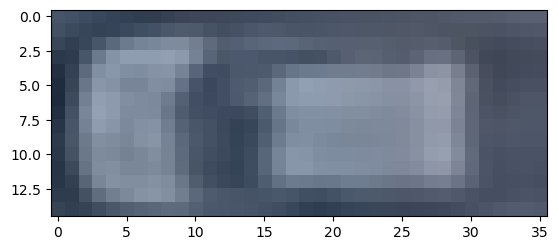

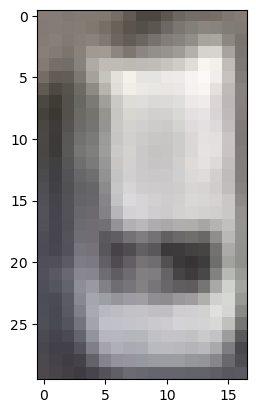

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  841


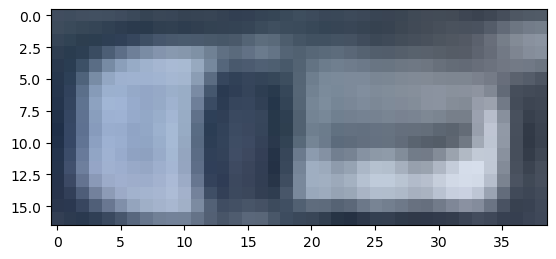

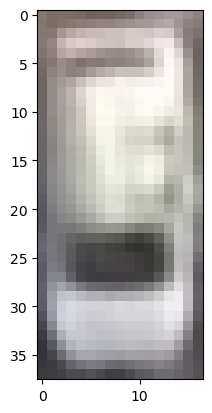

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  850


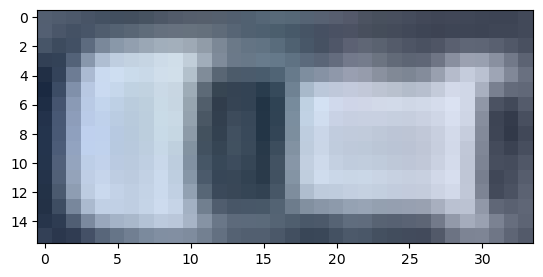

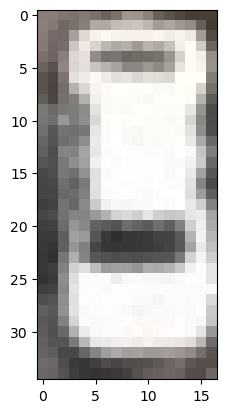

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  866


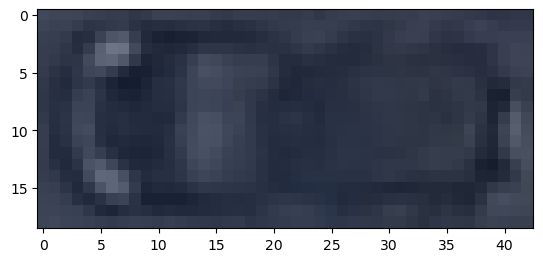

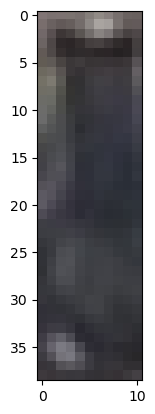

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  876


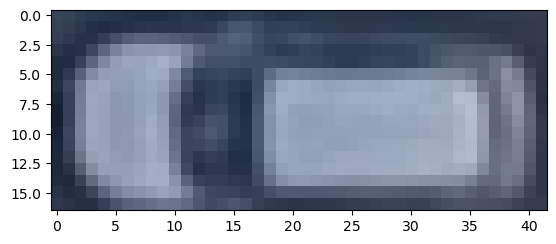

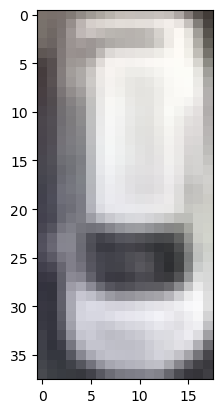

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  894


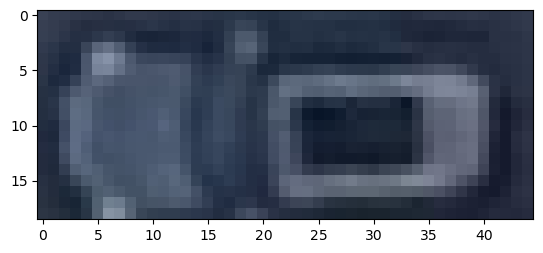

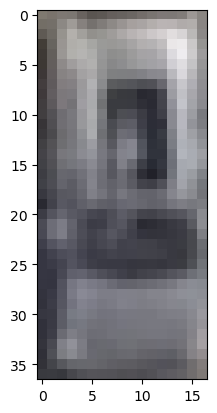

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  901


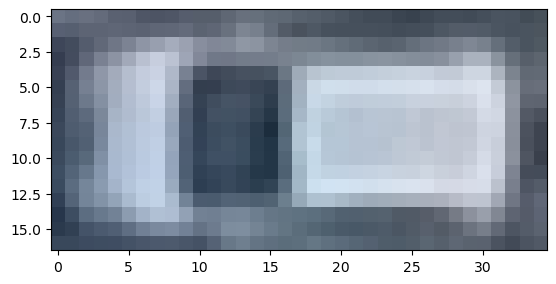

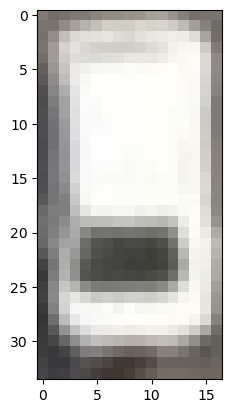

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  935


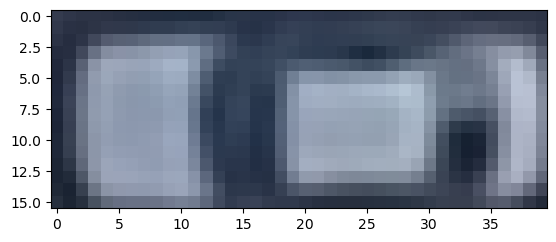

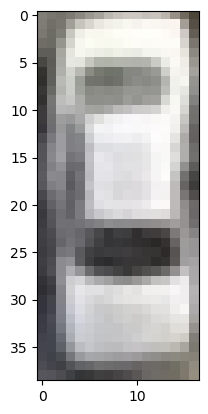

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  939


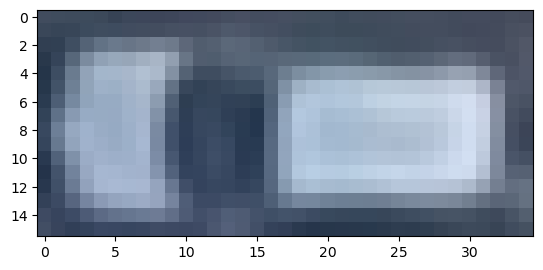

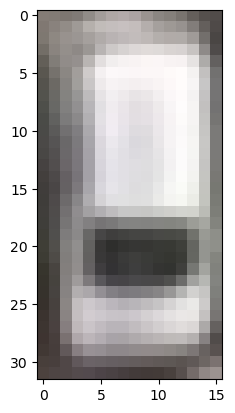

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  958


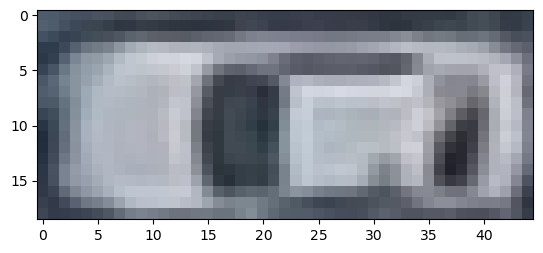

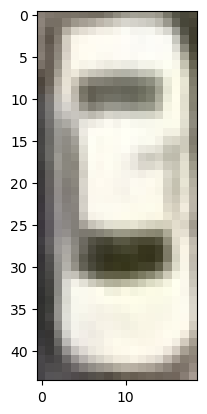

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  962


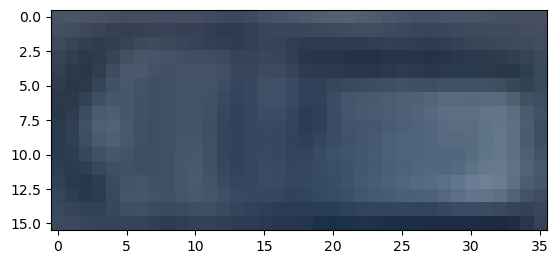

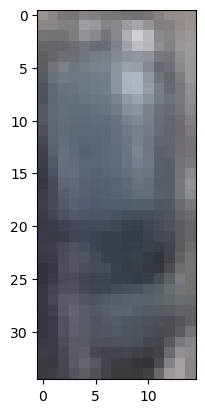

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  968


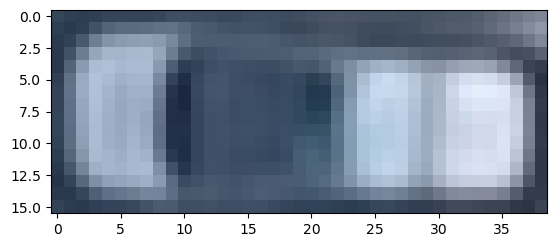

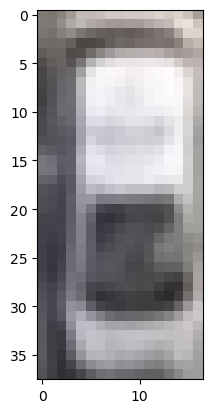

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  973


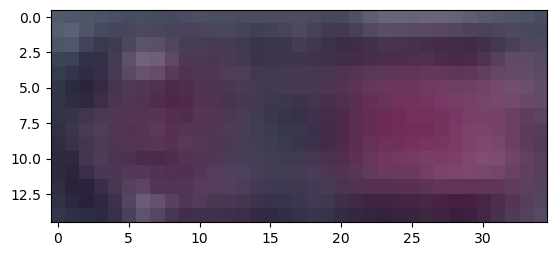

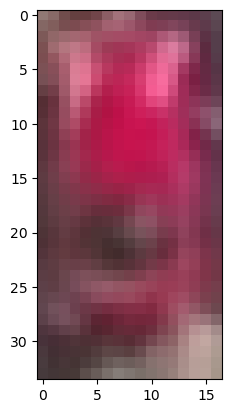

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1078


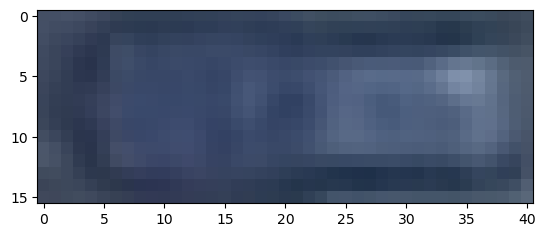

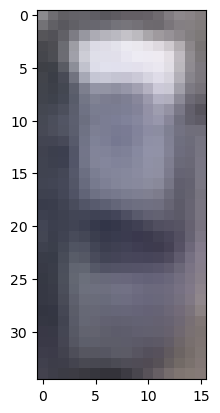

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1084


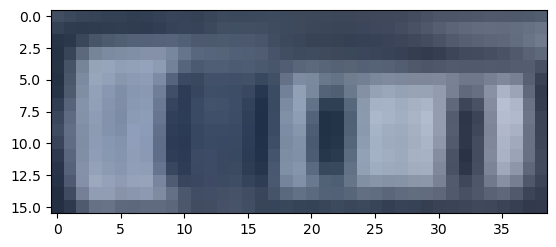

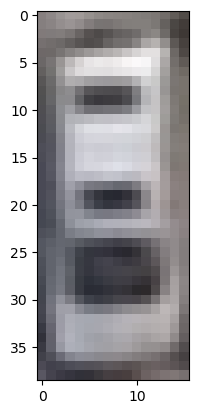

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1086


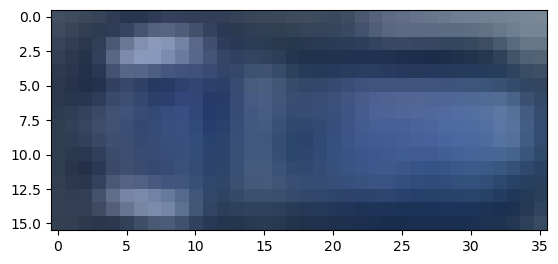

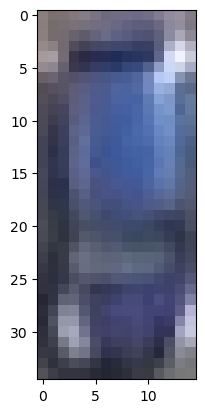

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1096


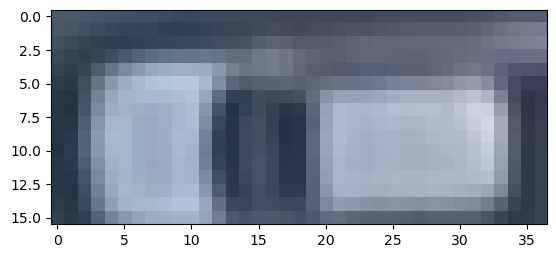

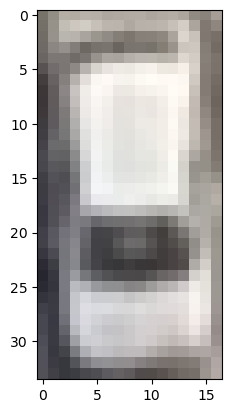

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1115


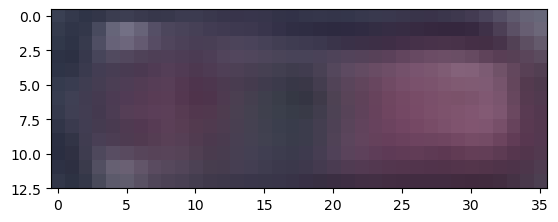

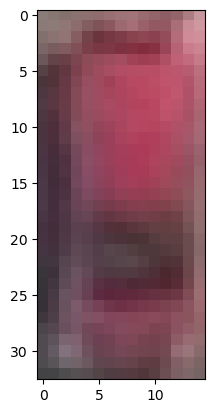

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1119


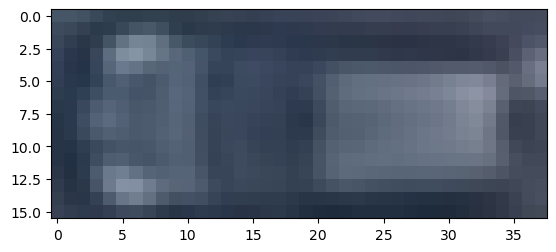

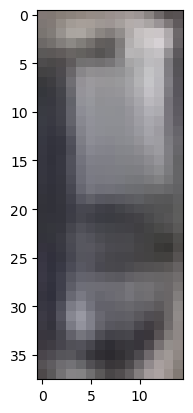

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1127


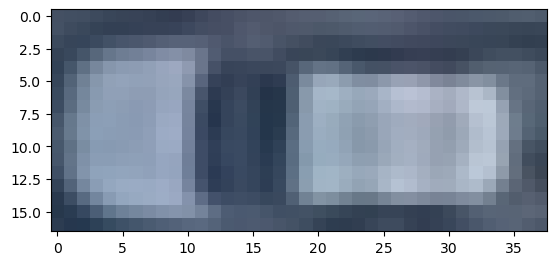

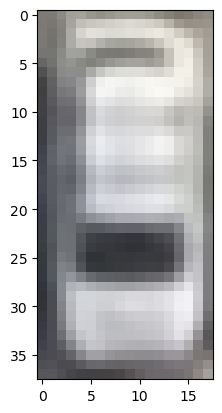

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1130


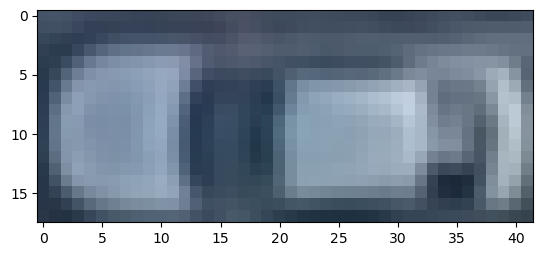

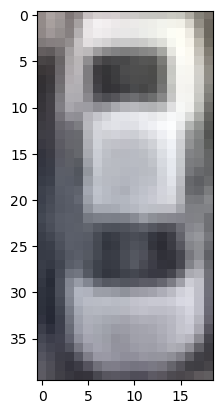

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1145


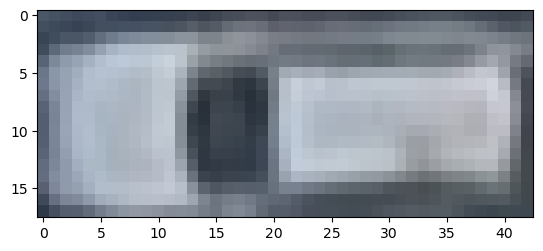

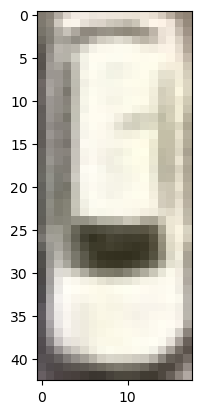

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1150


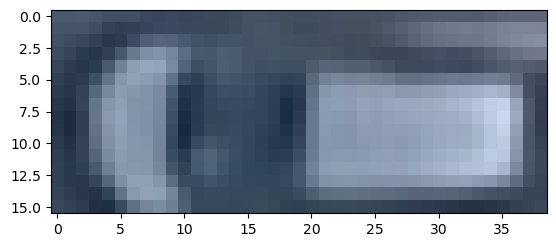

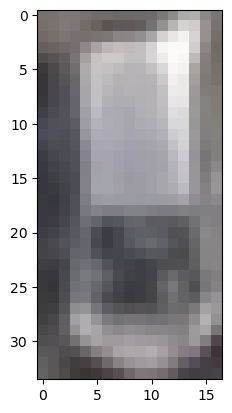

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1185


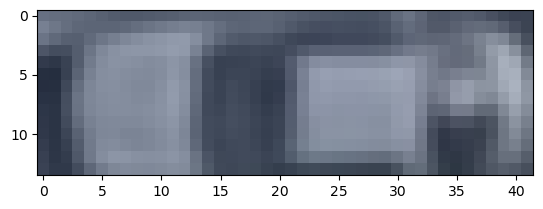

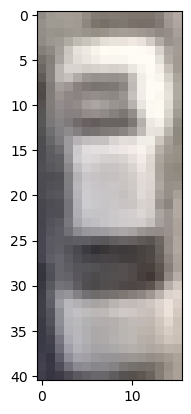

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1194


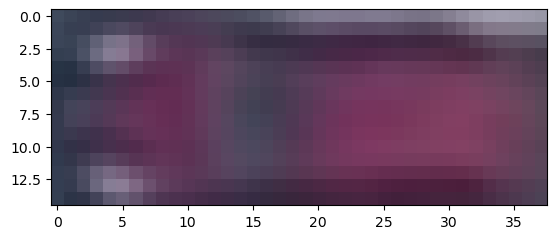

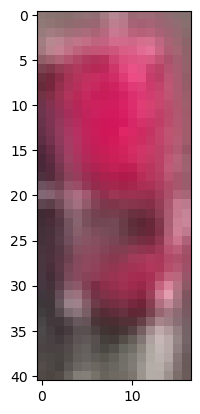

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1211


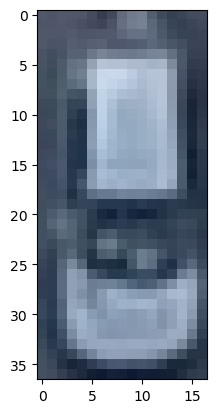

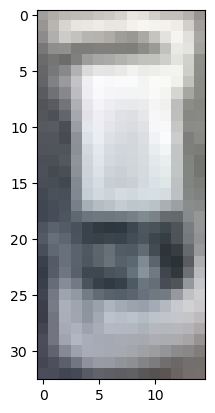

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1228


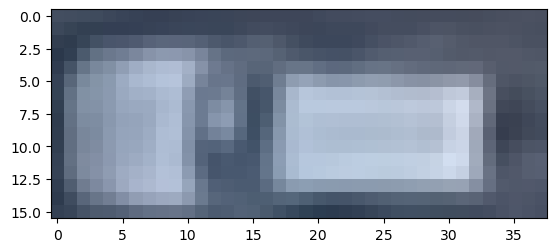

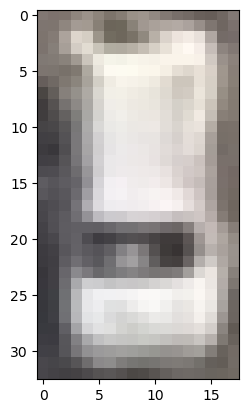

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1238


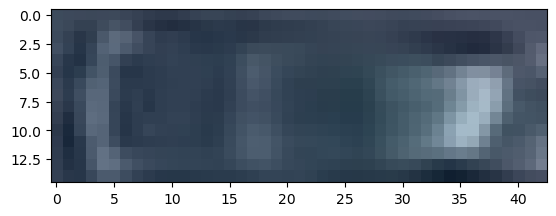

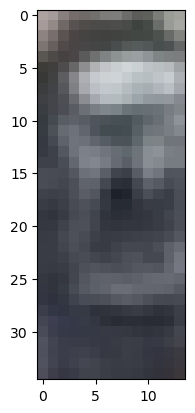

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1267


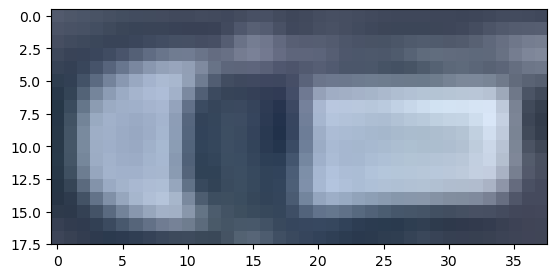

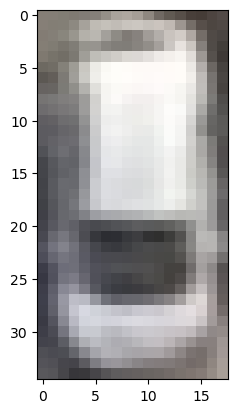

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1311


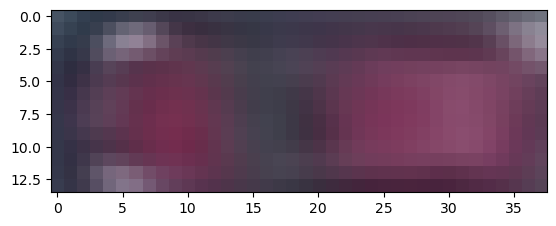

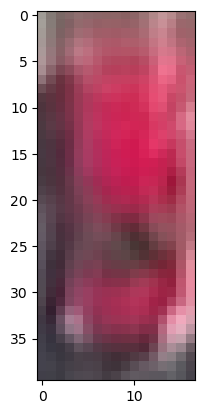

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1321


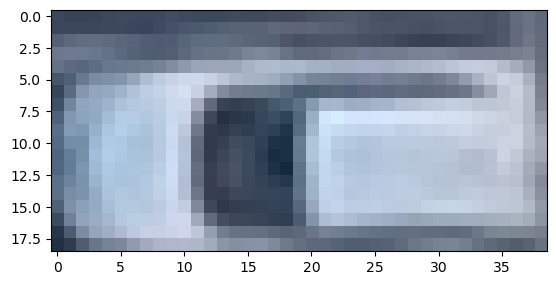

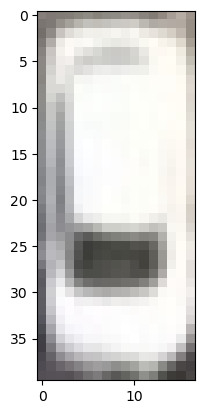

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1341


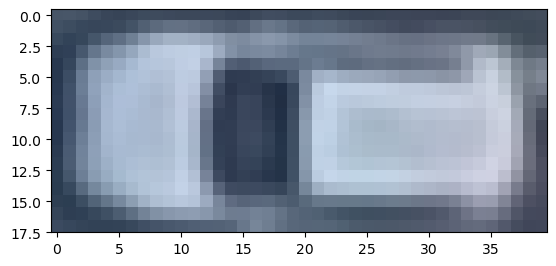

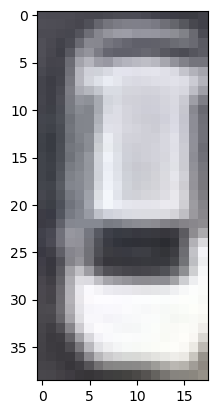

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1343


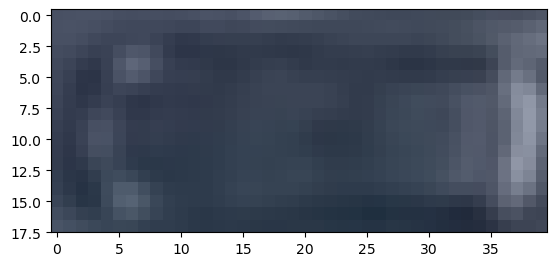

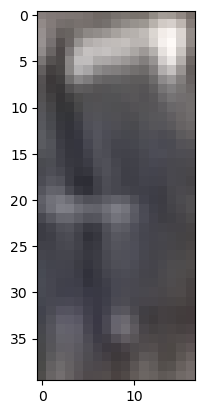

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1345


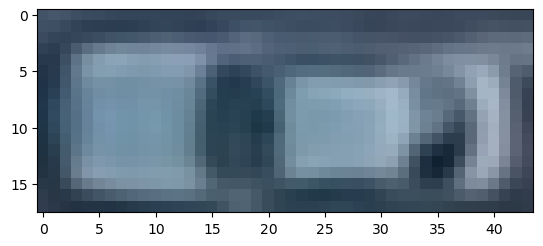

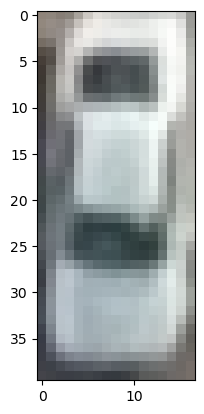

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1356


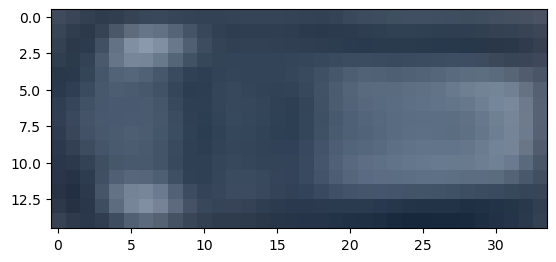

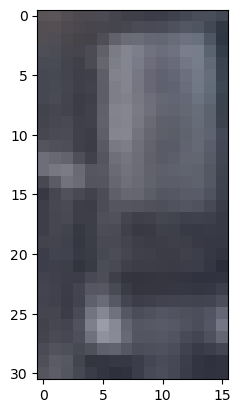

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1369


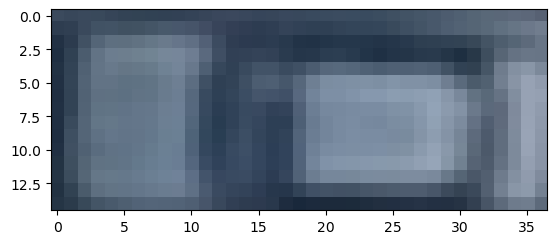

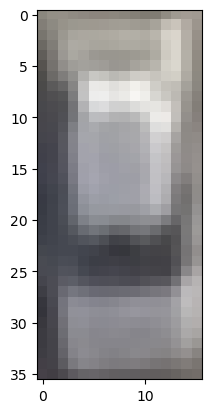

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1376


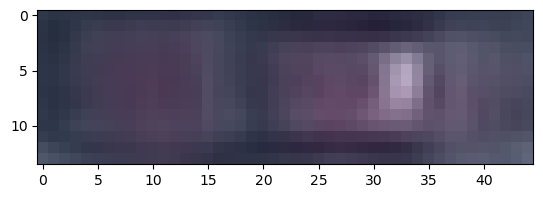

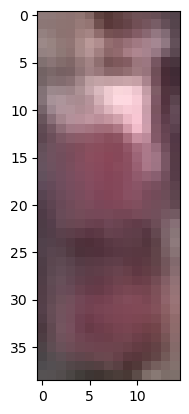

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1378


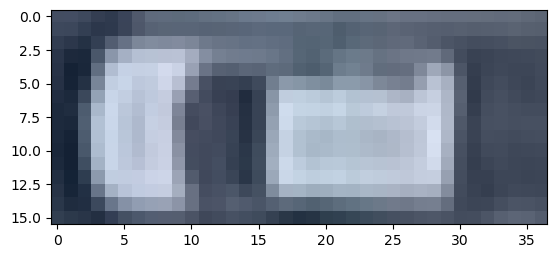

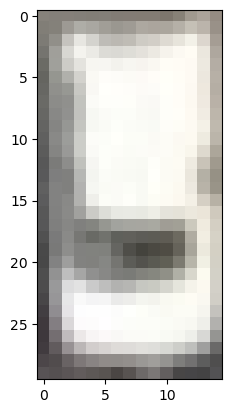

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1410


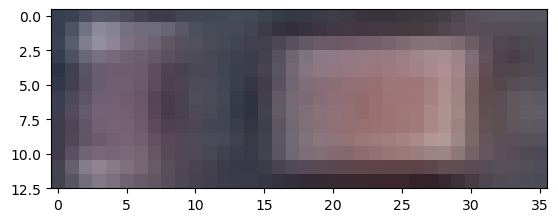

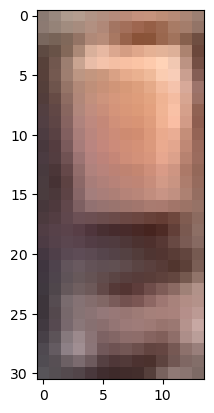

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1443


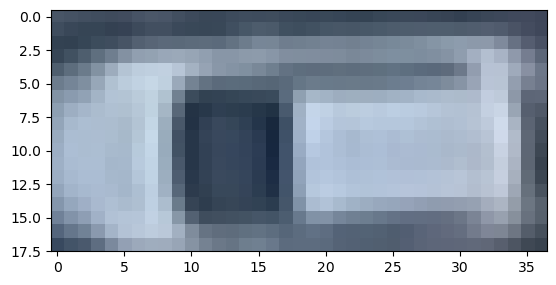

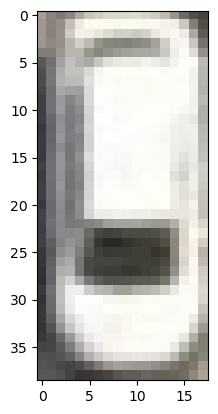

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1445


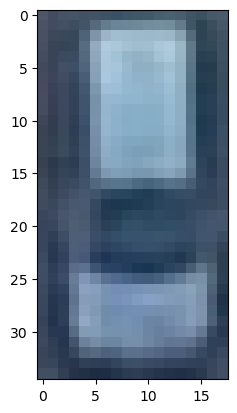

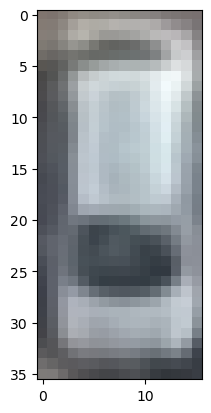

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1457


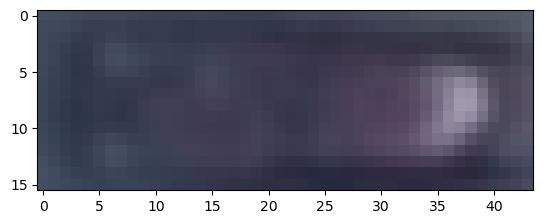

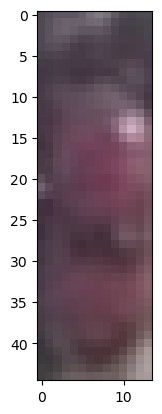

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1475


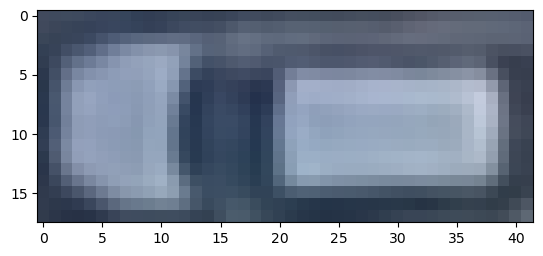

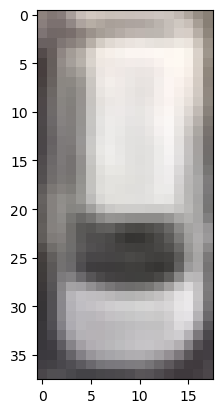

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1517


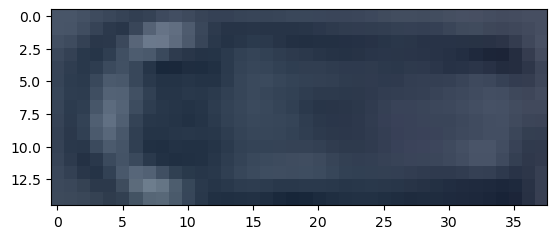

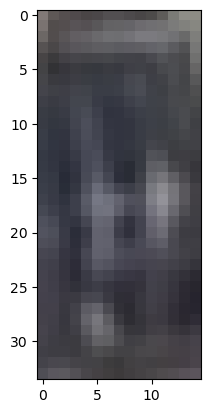

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1532


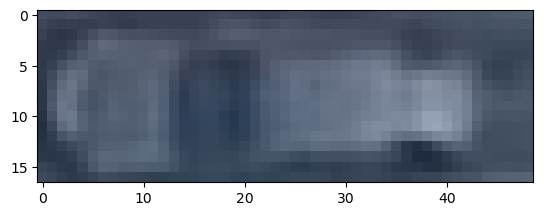

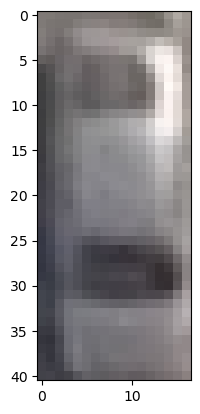

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1543


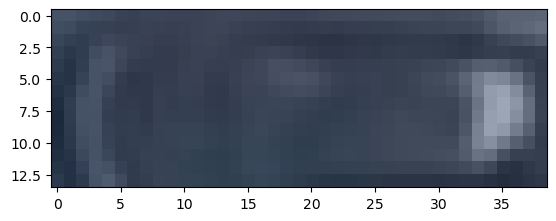

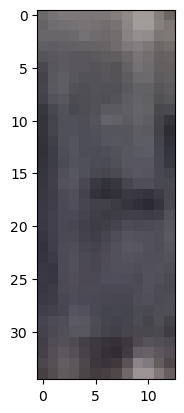

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1545


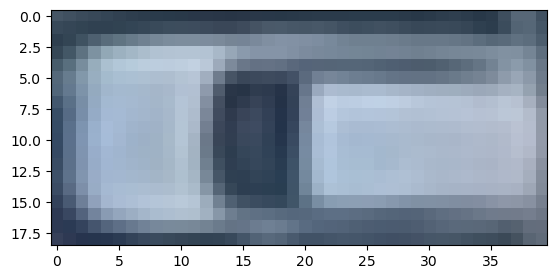

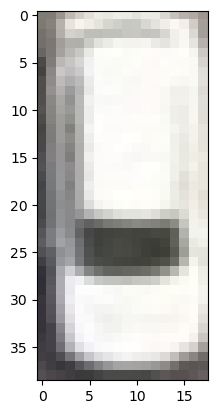

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1552


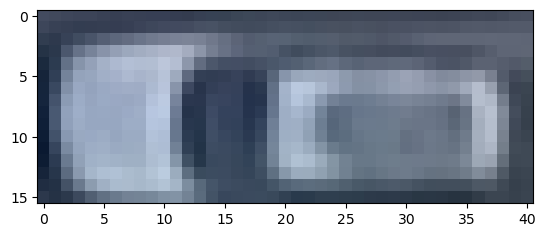

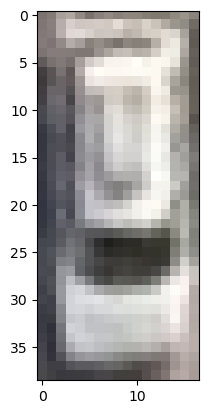

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1572


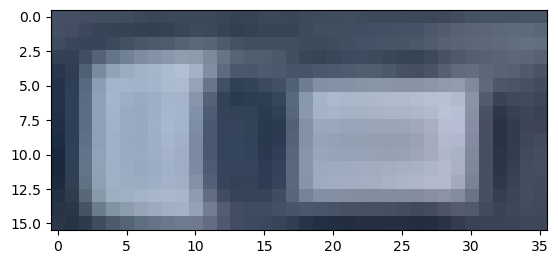

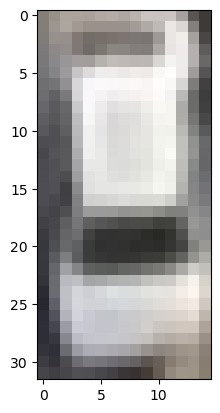

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1574


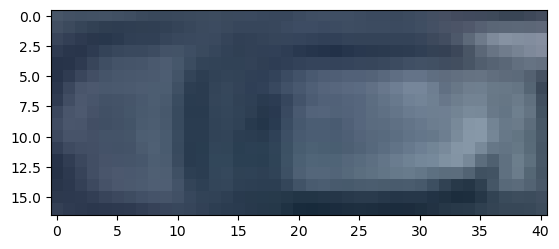

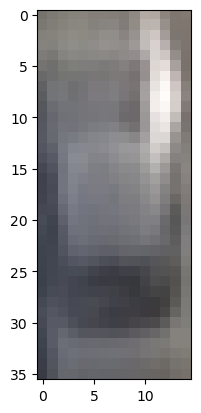

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1595


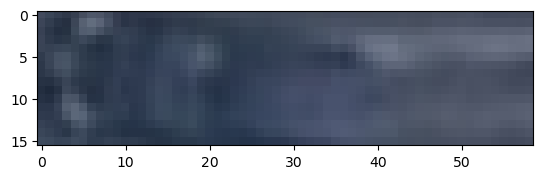

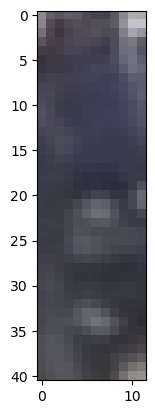

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1612


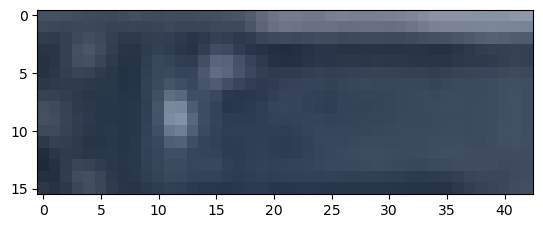

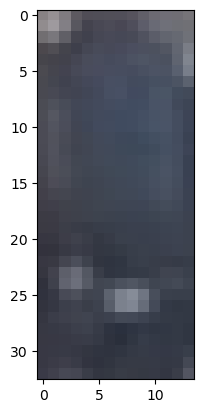

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1619


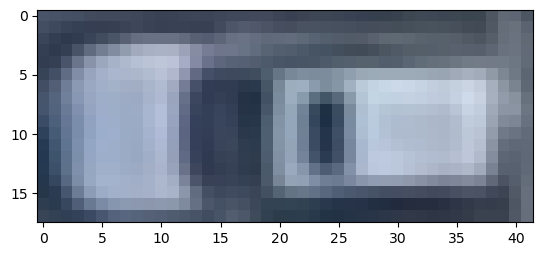

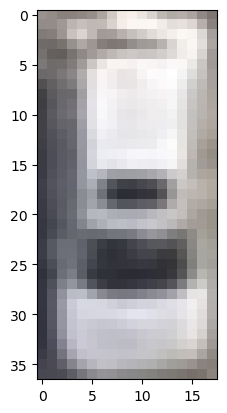

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1654


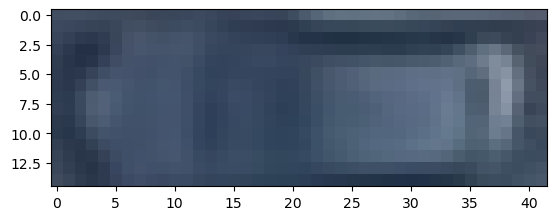

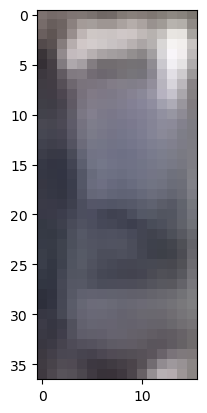

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1728


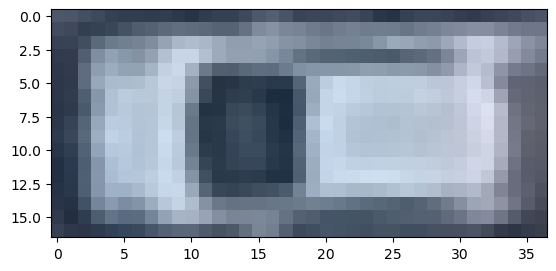

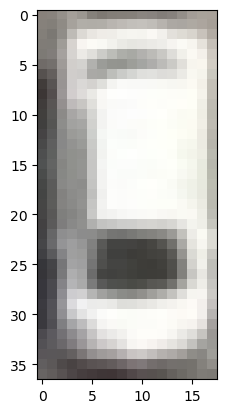

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1733


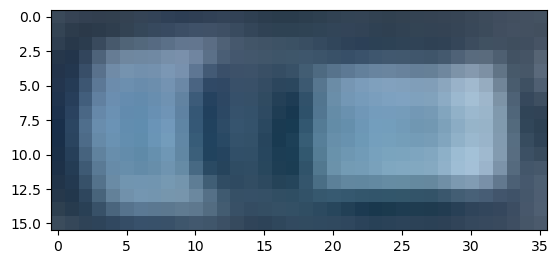

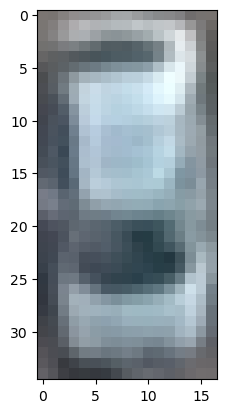

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1752


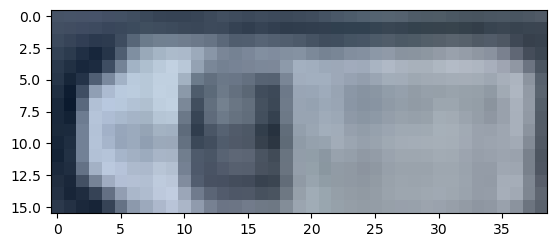

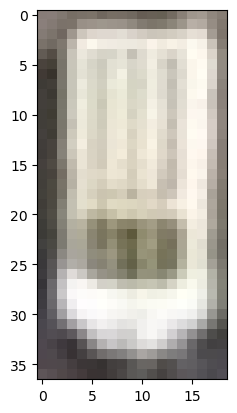

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1767


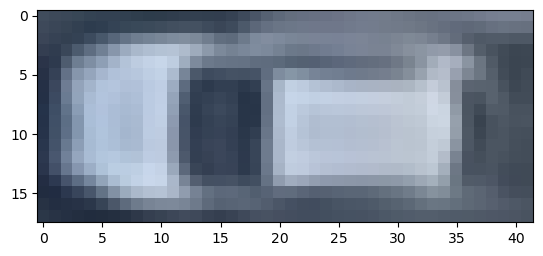

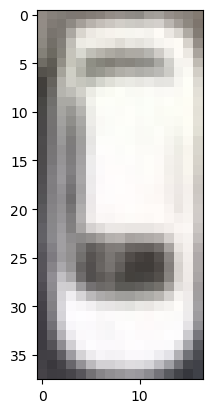

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1775


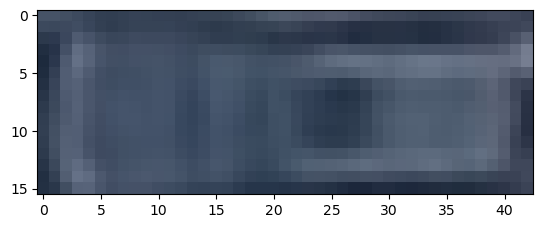

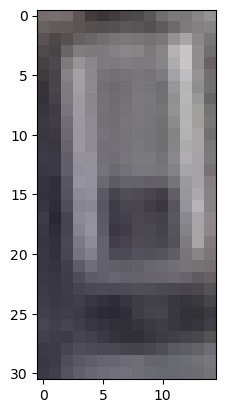

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1777


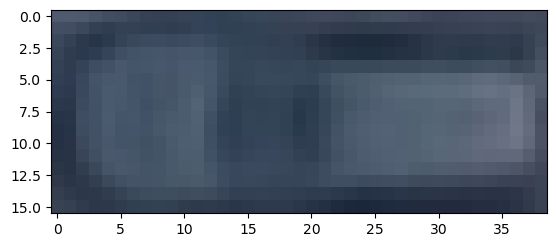

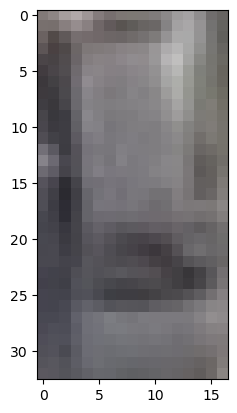

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1778


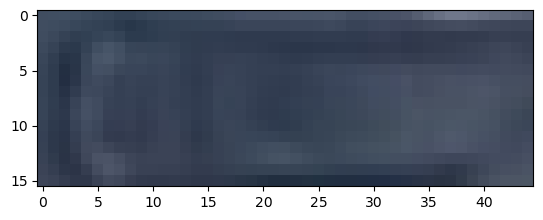

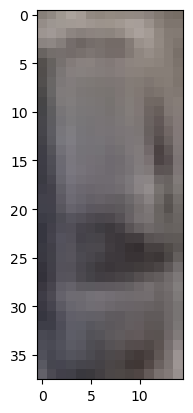

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1779


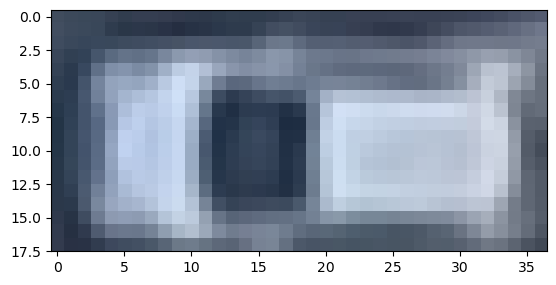

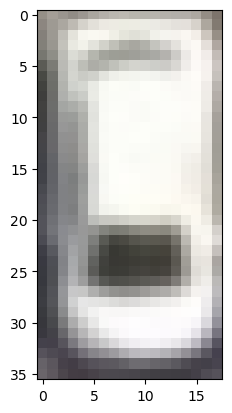

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1786


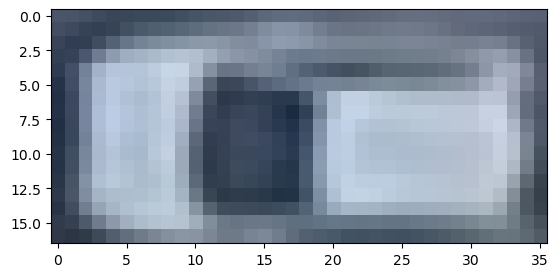

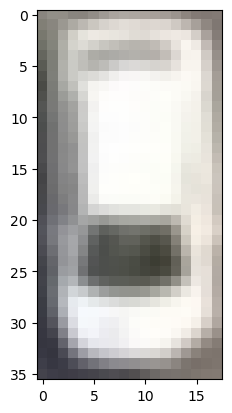

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1790


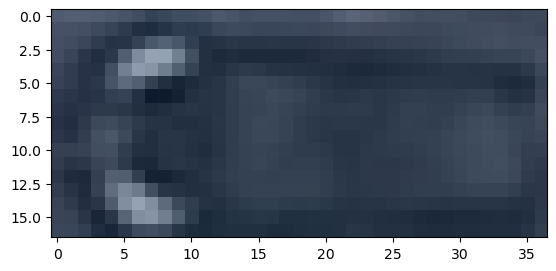

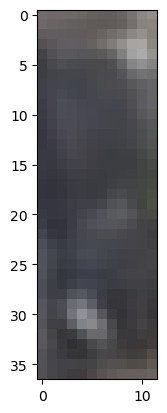

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1808


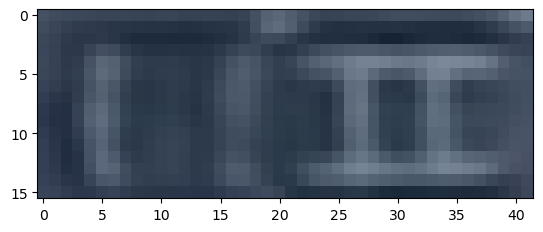

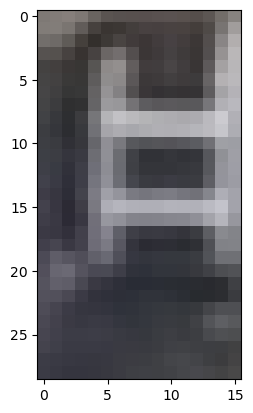

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1822


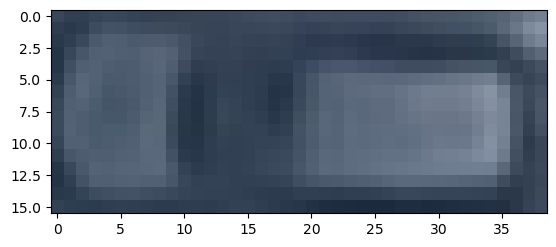

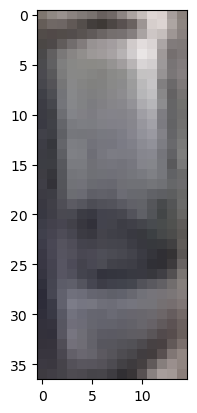

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
ID:  1861


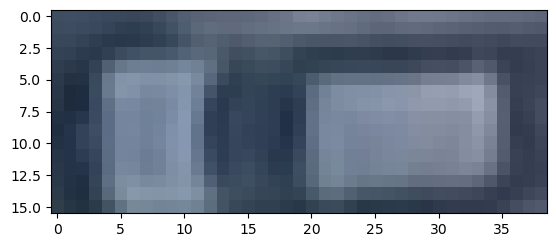

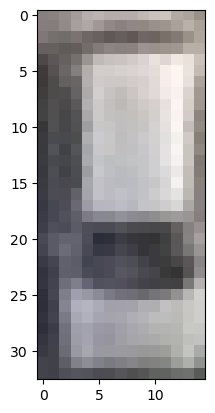

load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
load checkpoint from local path: /home/yura/mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


In [61]:
v_patches_pair = {} #v_id: (start_patch, end_patch)
for v_id in travel_time.keys():
    tmp1, tmp2 = get_v_patches(v_id, start_dict, end_dict)
    if tmp1 is not None and tmp2 is not None:
        print("ID: ", v_id)
        show_image_inline(tmp1)
        show_image_inline(tmp2)
        v_patches_pair[v_id] = (tmp1, tmp2)

In [121]:
for k in v_patches_pair.keys():
    v_patches_pair[k] = (v_patches_pair[k][0], cv2.rotate(v_patches_pair[k][1], cv2.ROTATE_90_CLOCKWISE))

In [184]:
white = []
non_white = []
for k in v_patches_pair.keys():
    #print(k, int(v_patches_pair[k][0].mean()))
    if int(v_patches_pair[k][0].mean()) > 91:
        white.append(k)
    else:
        non_white.append(k)
    #show_image_inline(v_patches_pair[k][0])

60


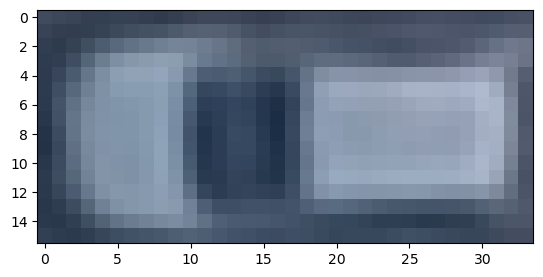

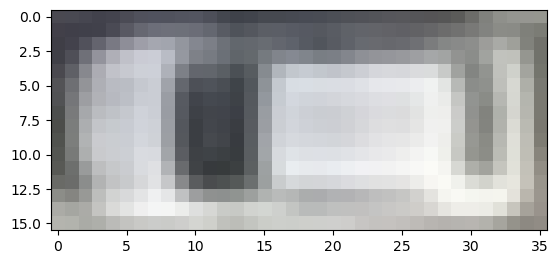

61


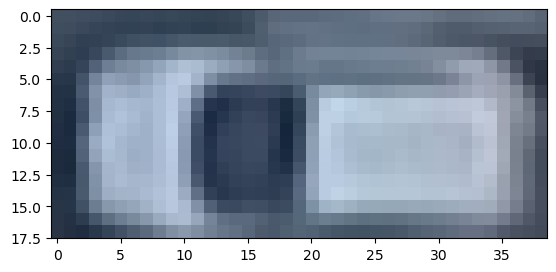

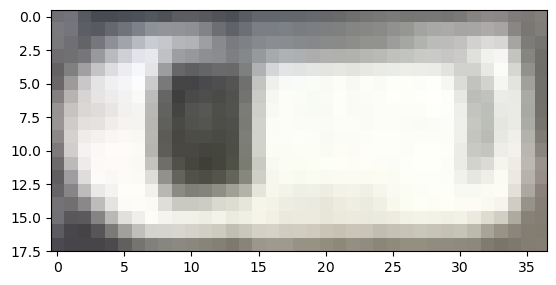

62


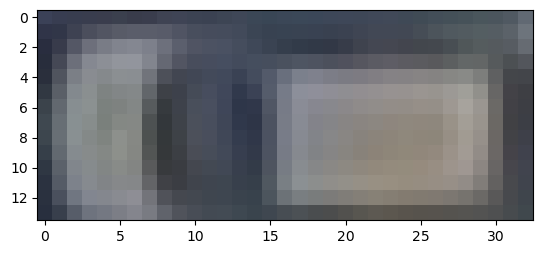

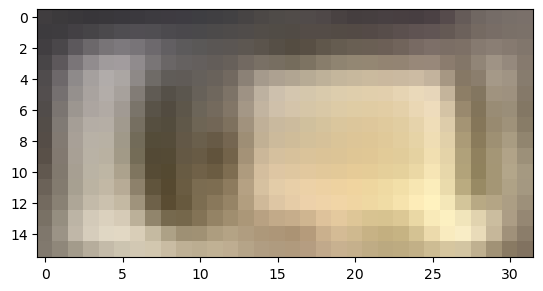

160


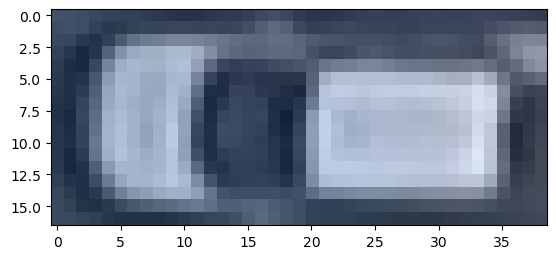

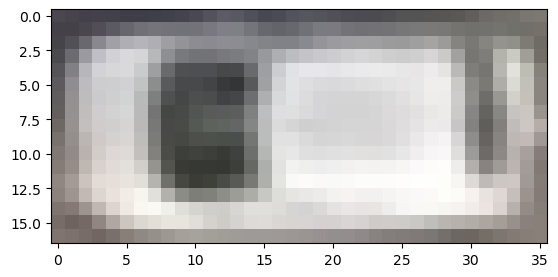

161


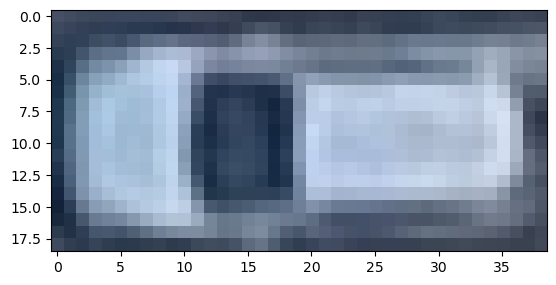

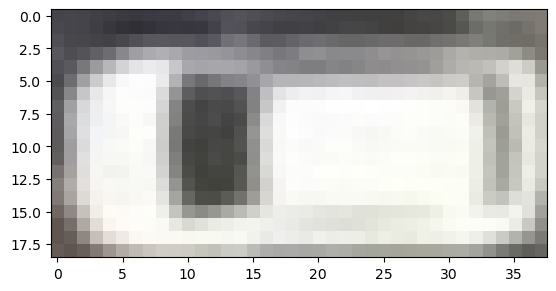

164


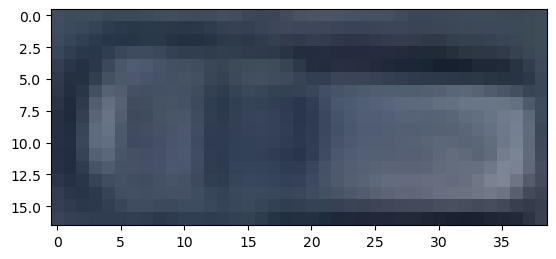

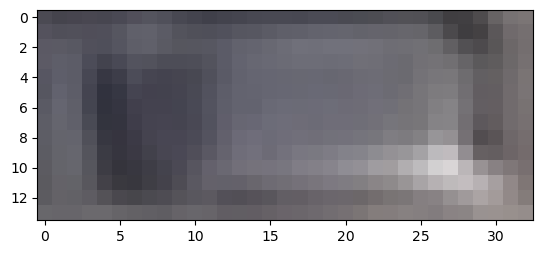

192


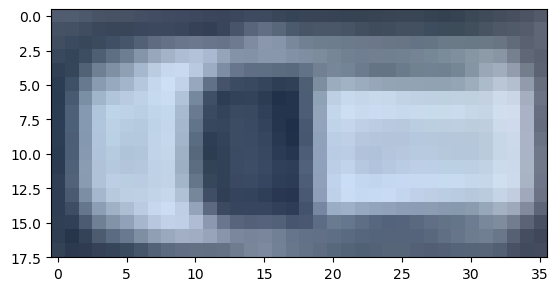

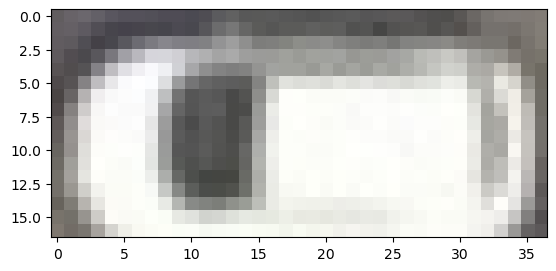

205


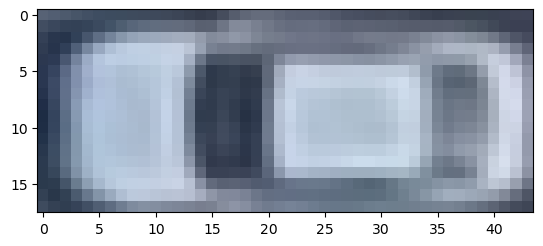

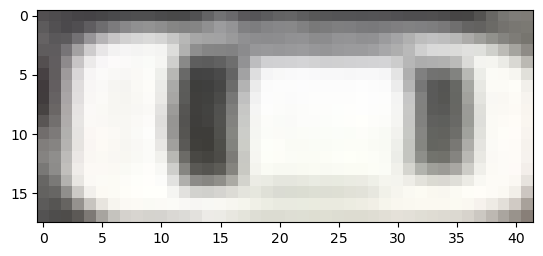

212


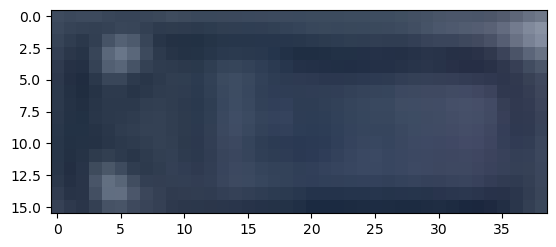

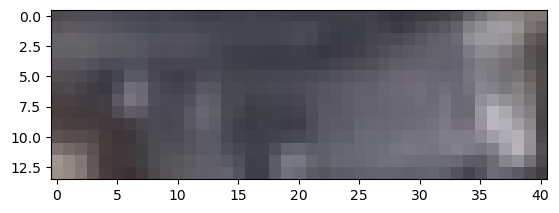

213


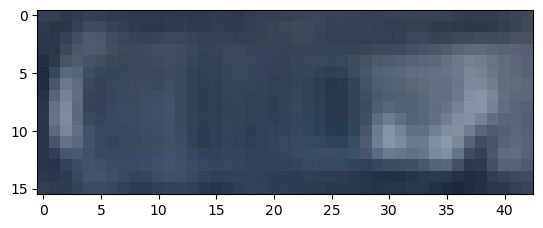

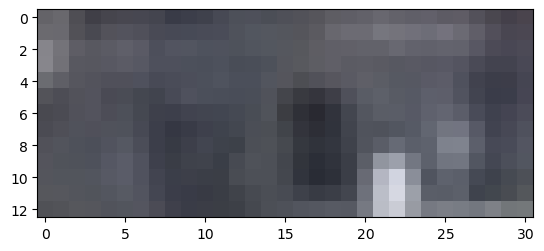

222


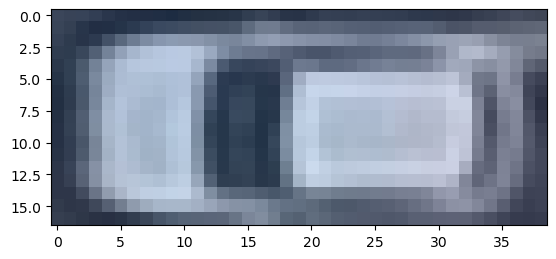

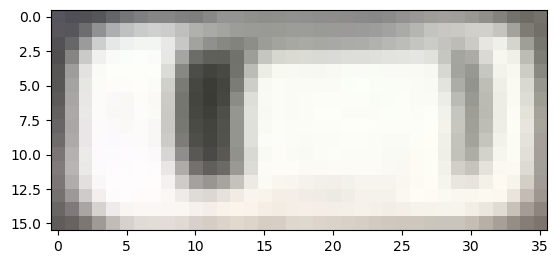

229


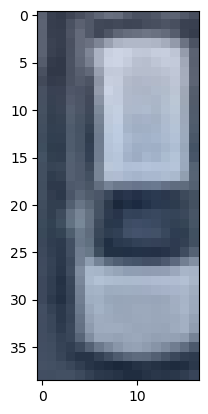

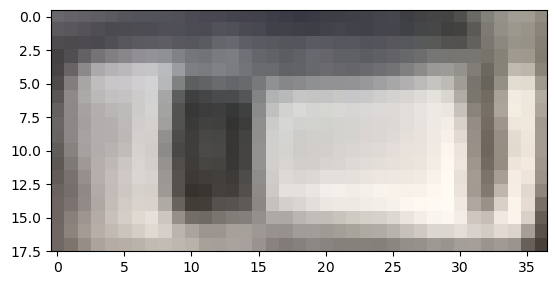

236


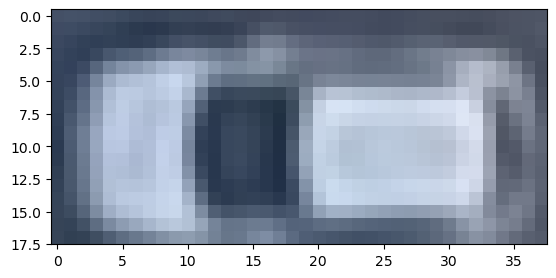

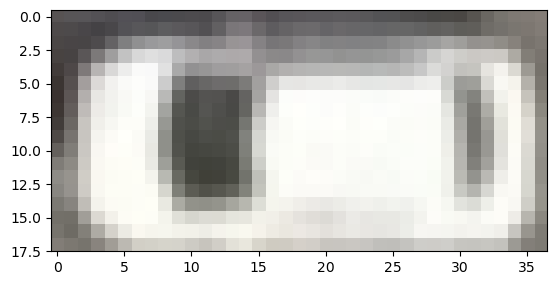

237


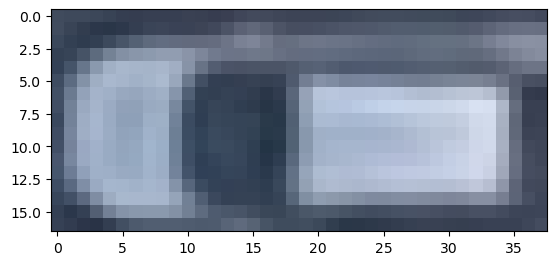

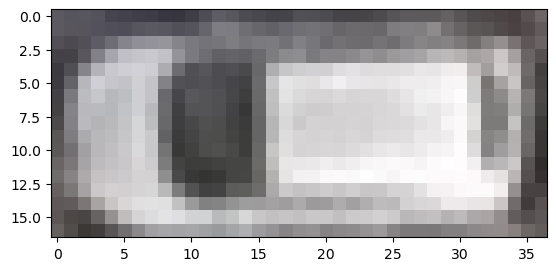

261


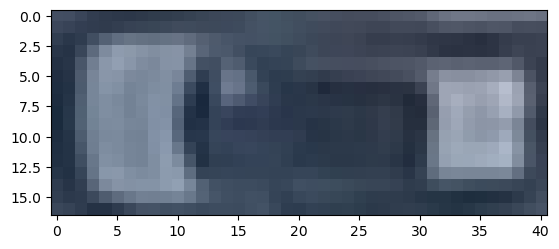

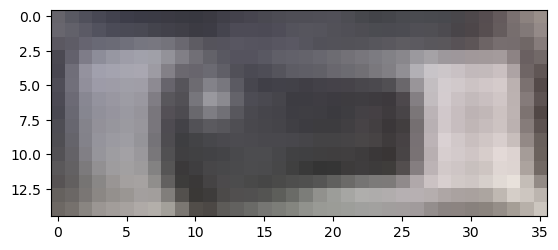

274


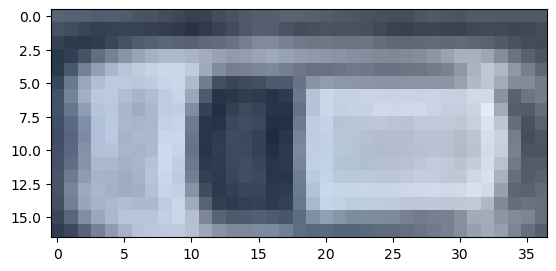

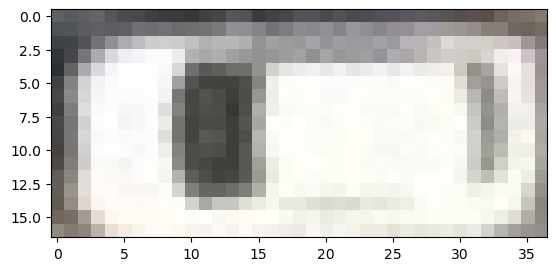

304


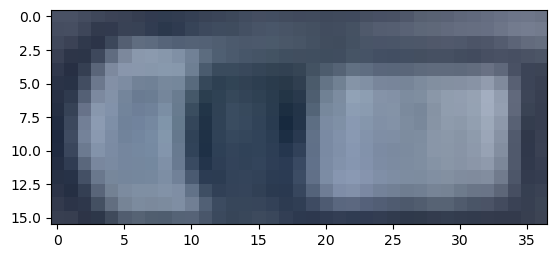

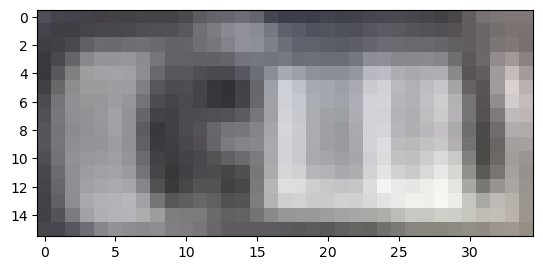

382


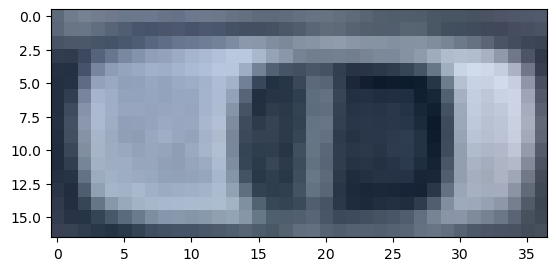

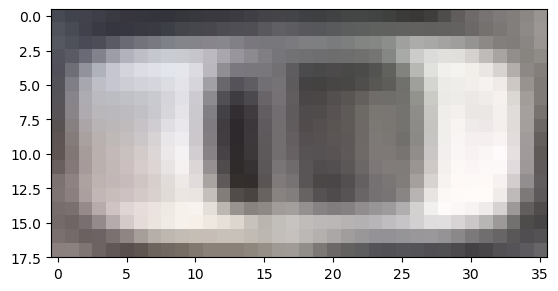

417


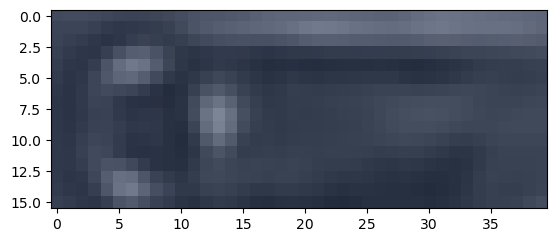

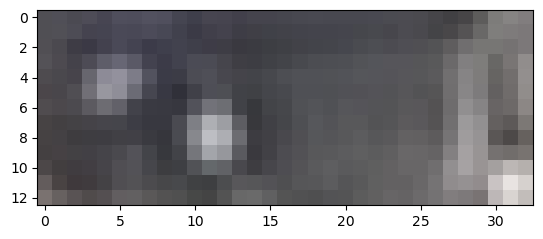

424


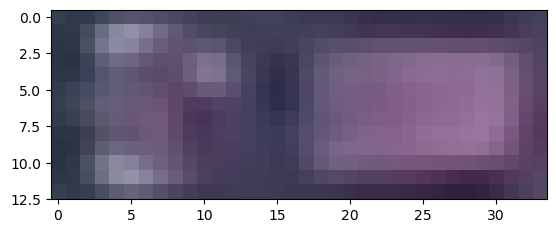

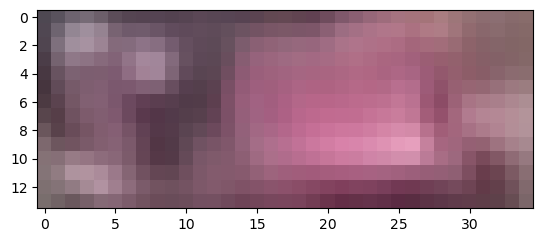

429


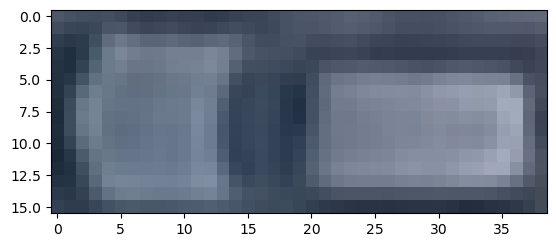

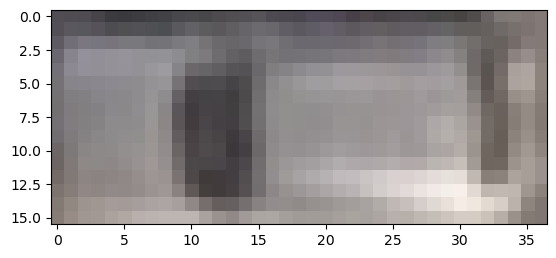

432


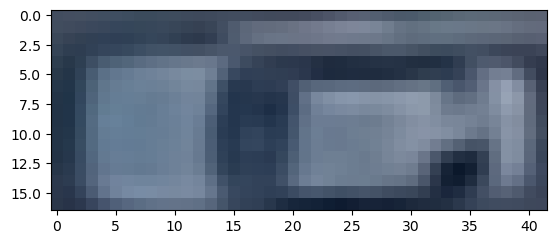

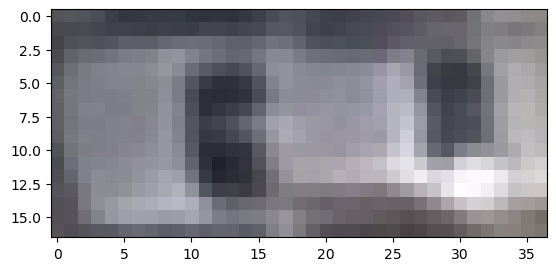

438


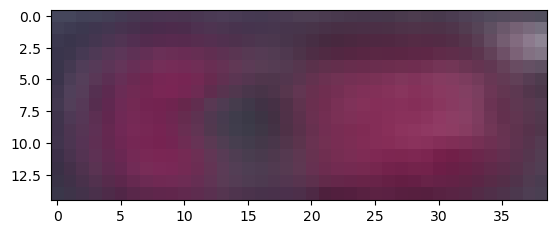

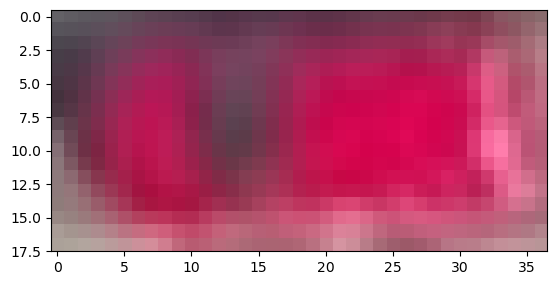

455


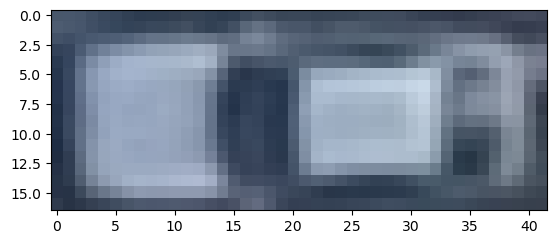

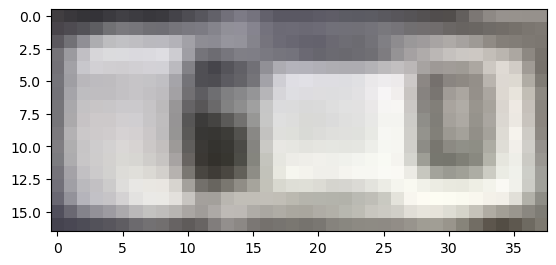

456


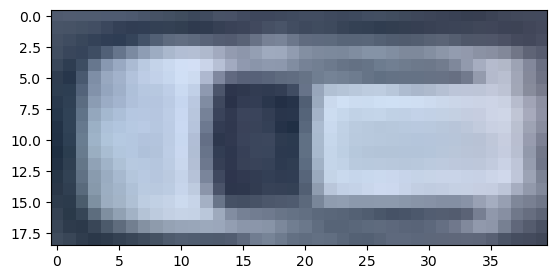

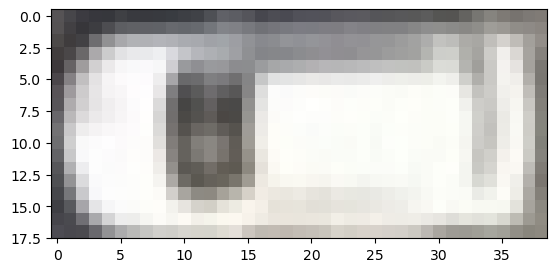

457


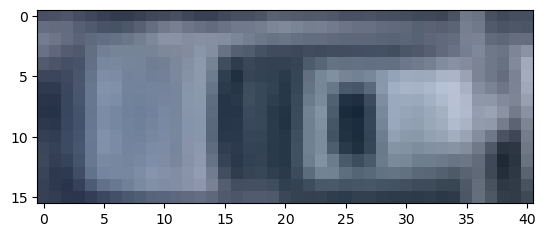

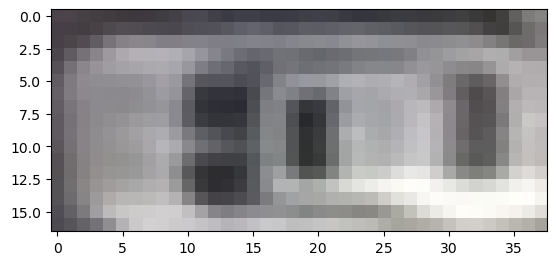

461


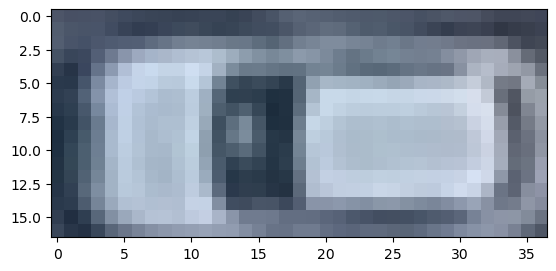

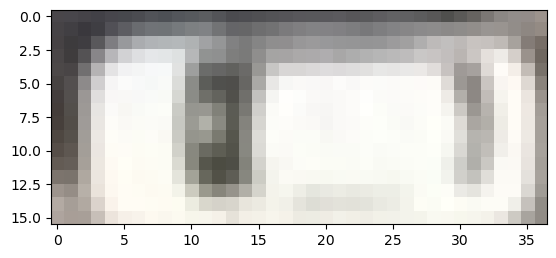

471


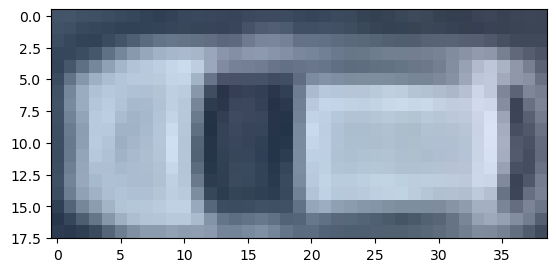

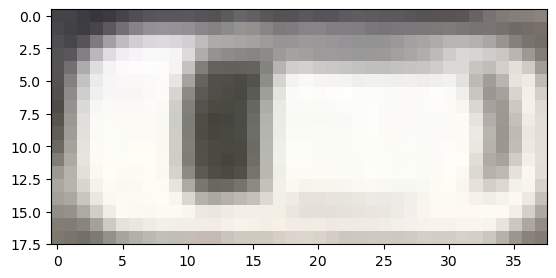

473


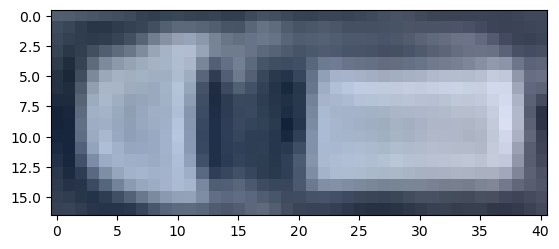

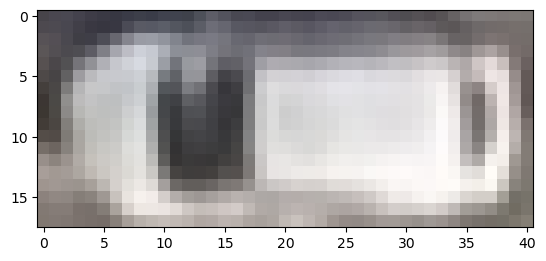

477


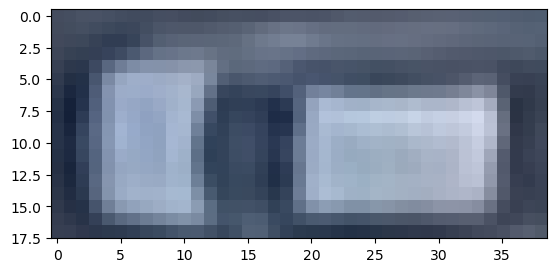

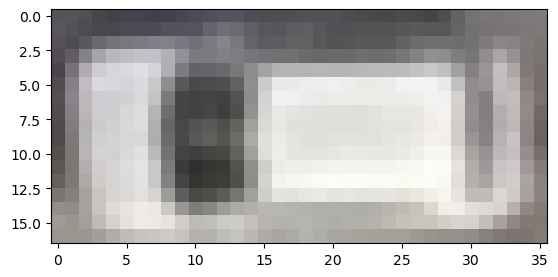

490


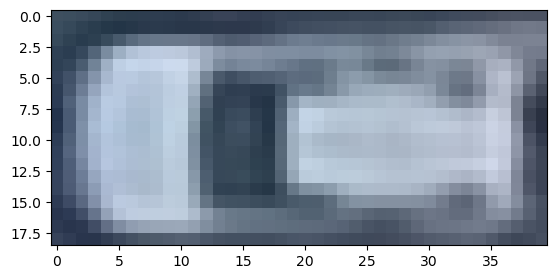

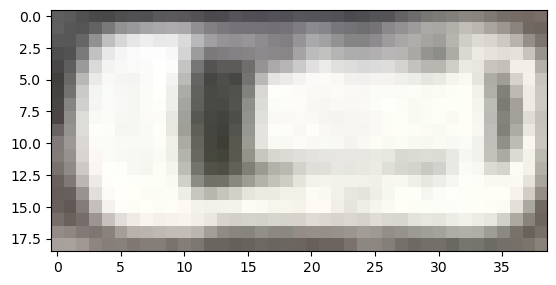

495


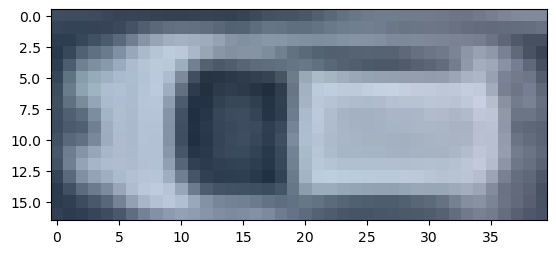

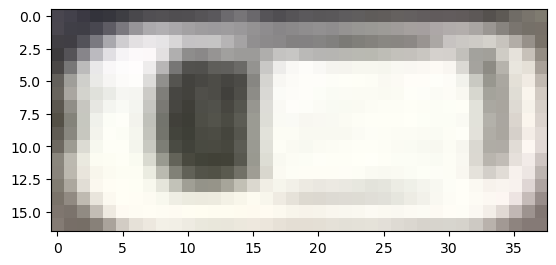

504


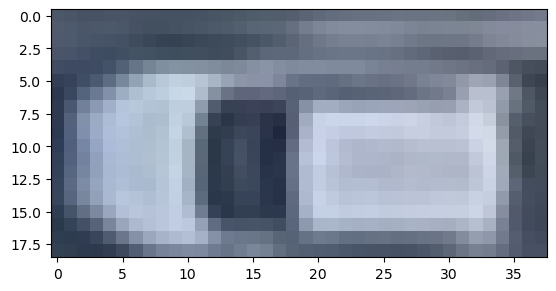

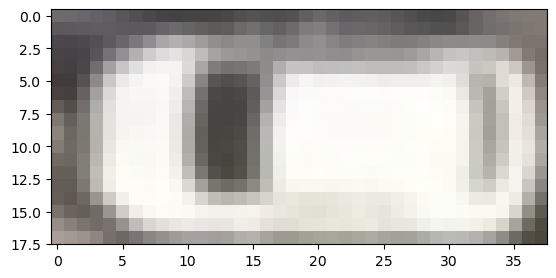

560


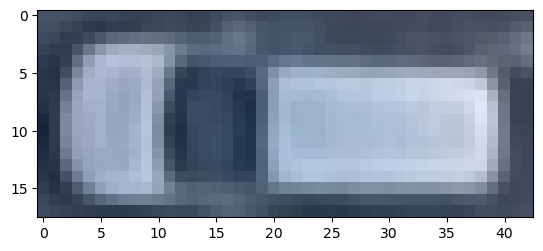

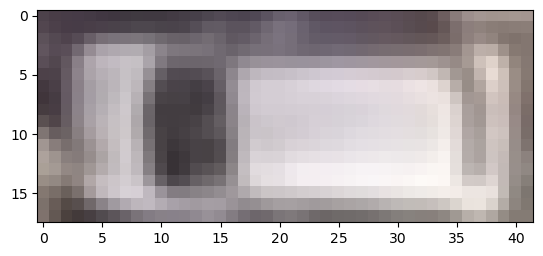

589


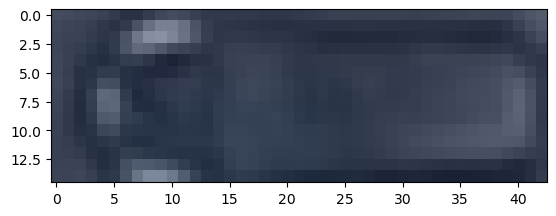

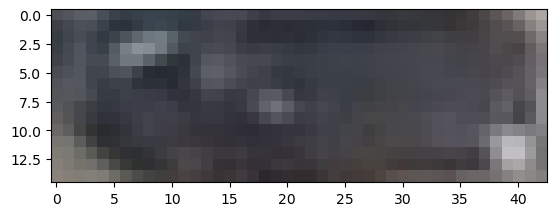

616


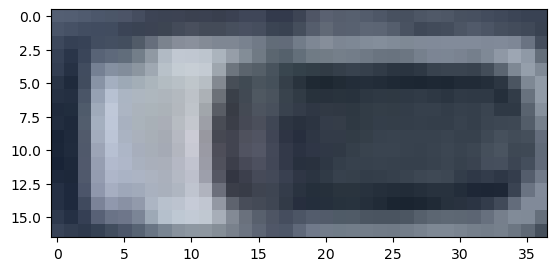

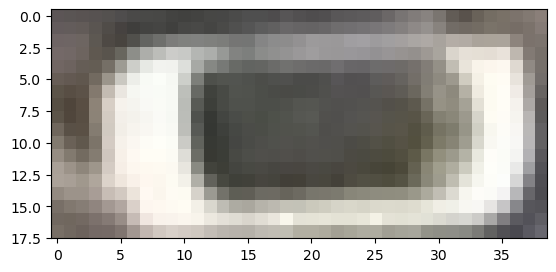

630


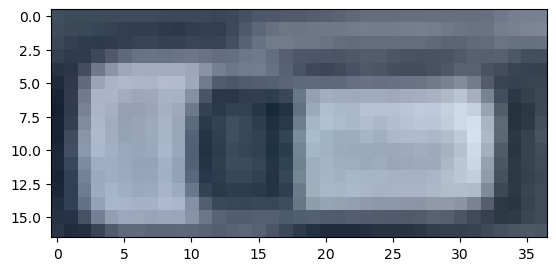

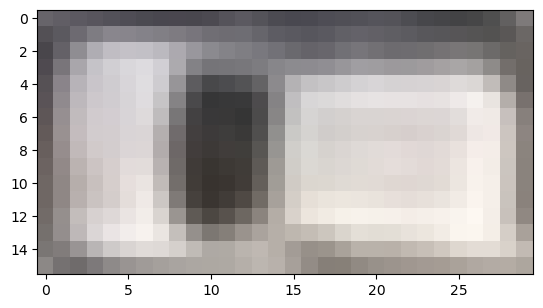

631


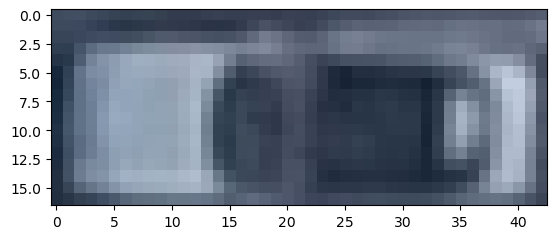

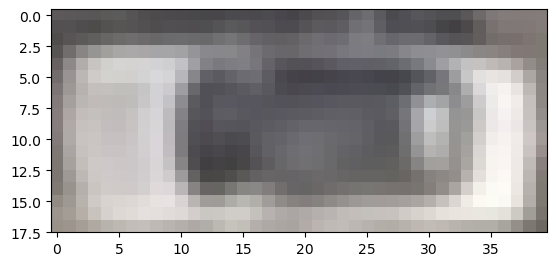

635


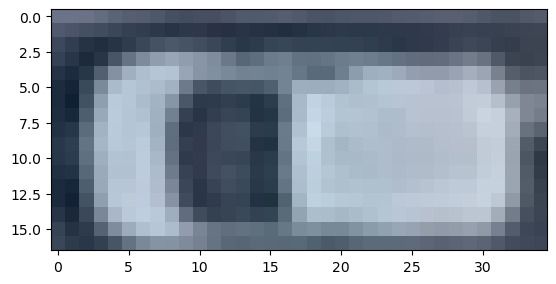

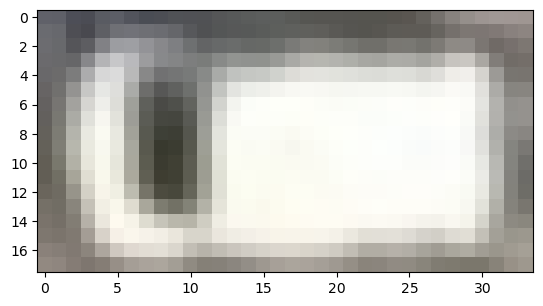

648


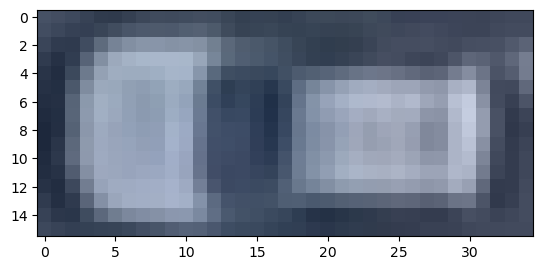

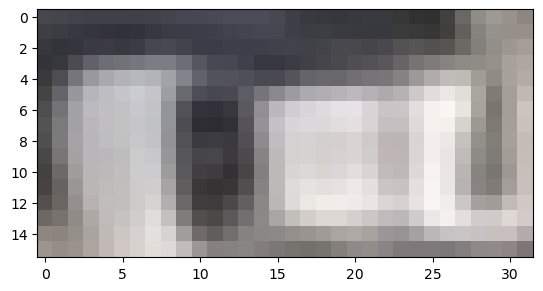

649


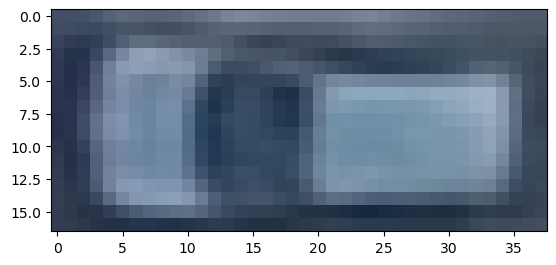

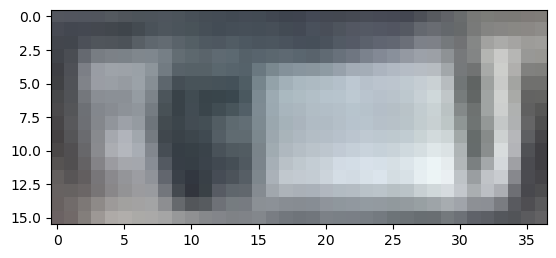

653


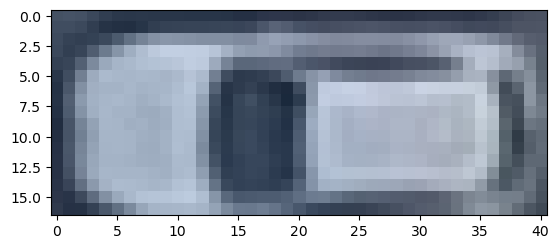

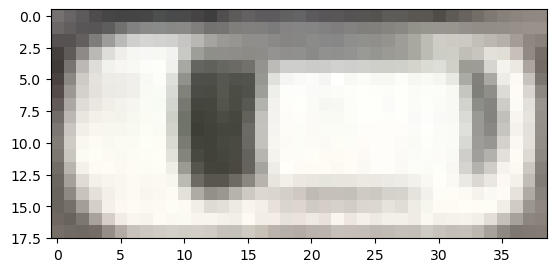

659


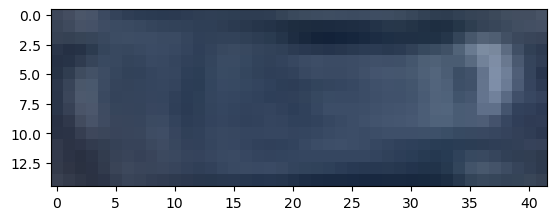

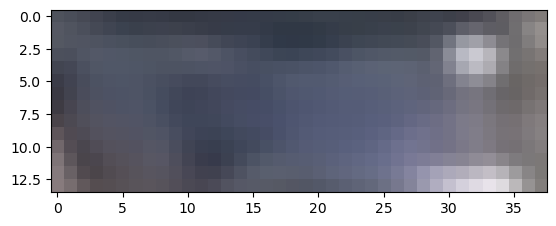

661


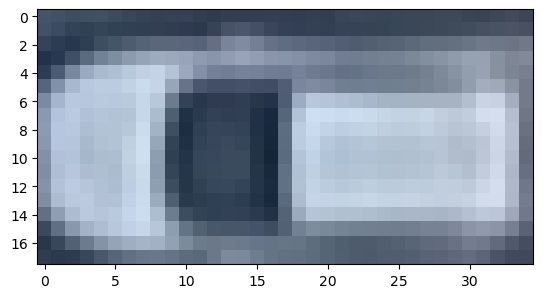

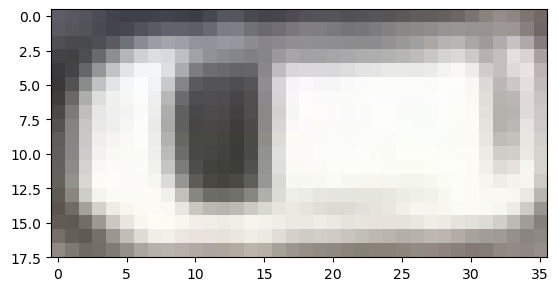

664


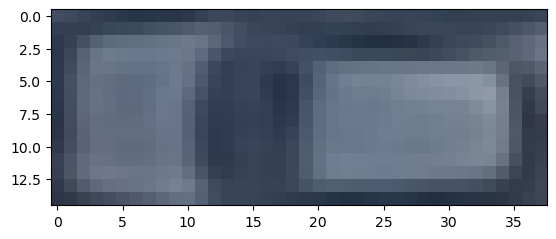

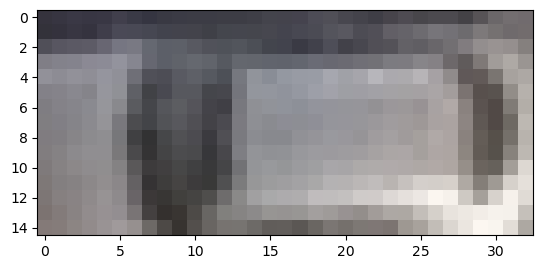

667


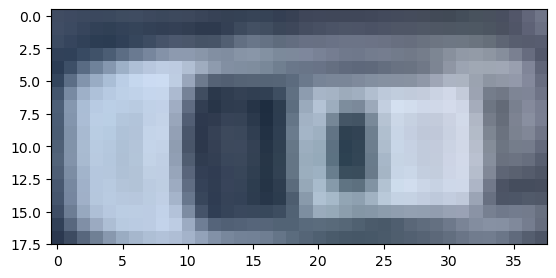

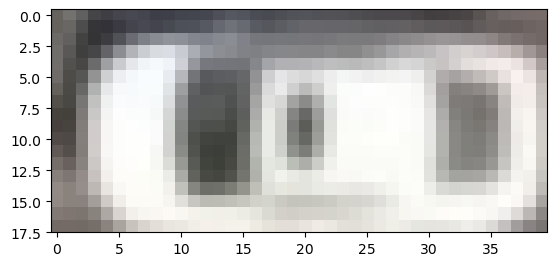

670


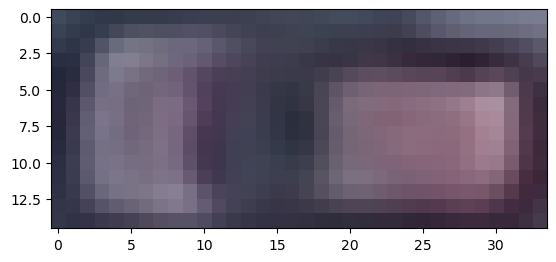

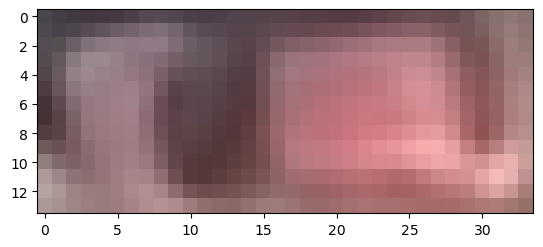

688


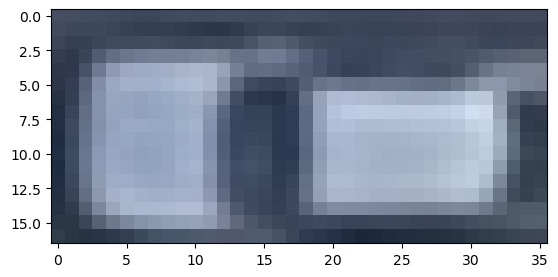

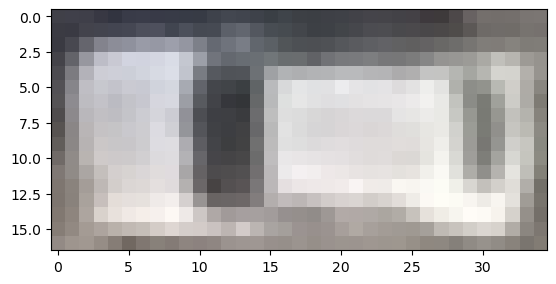

696


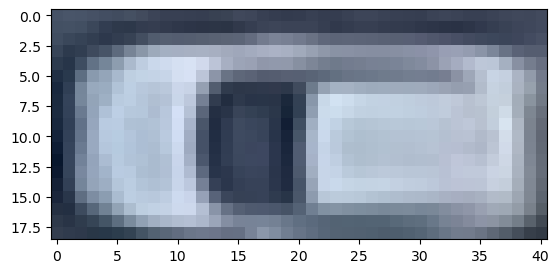

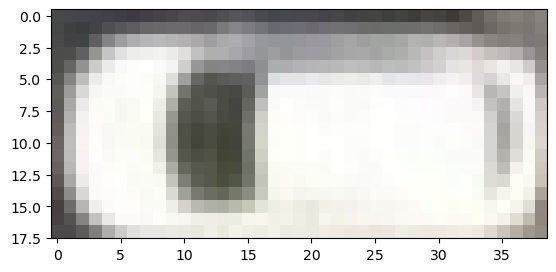

699


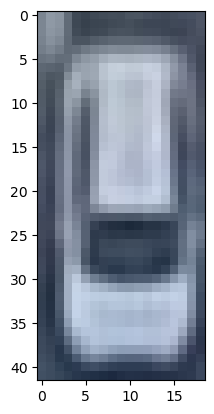

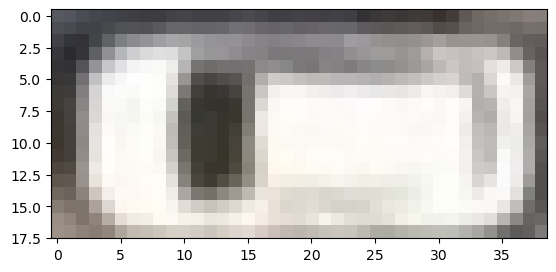

704


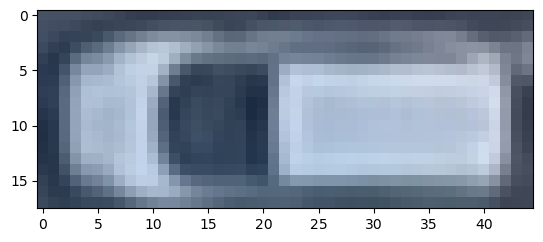

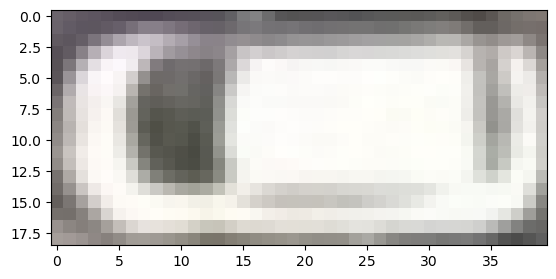

730


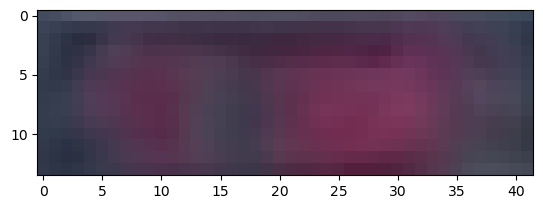

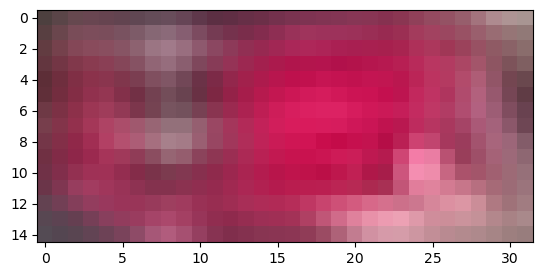

731


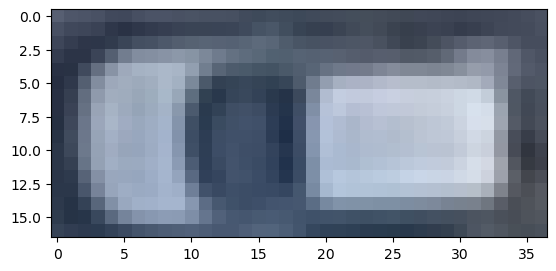

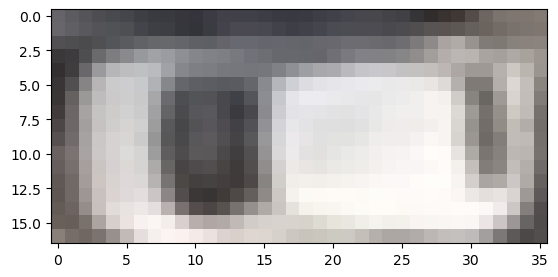

743


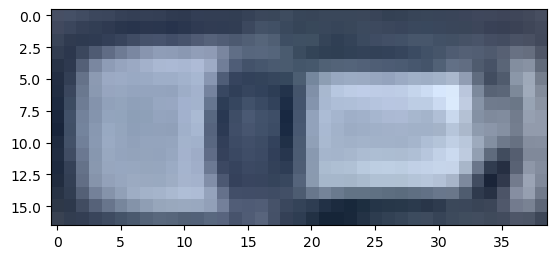

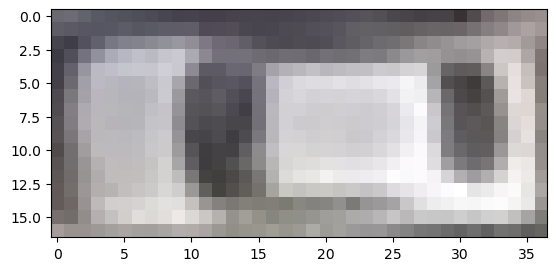

744


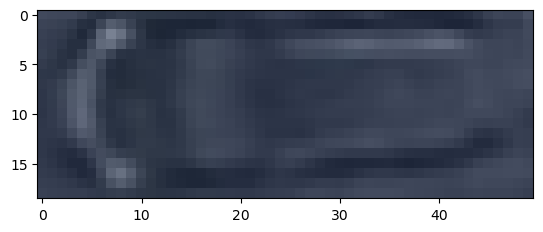

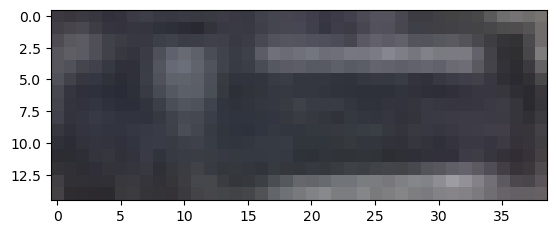

749


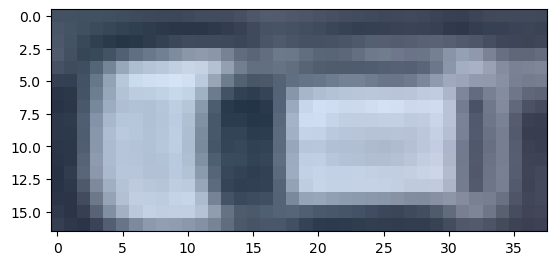

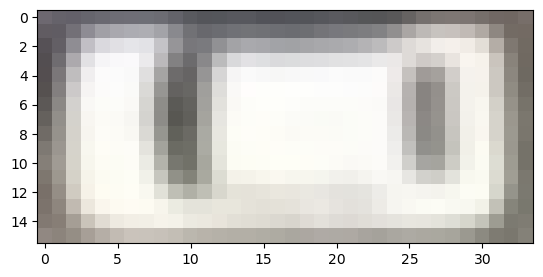

785


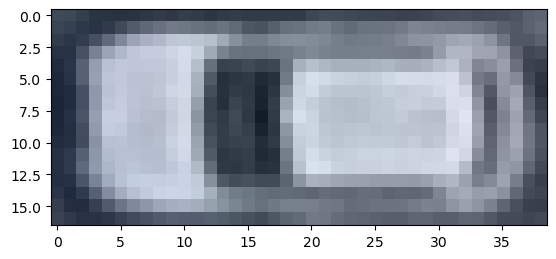

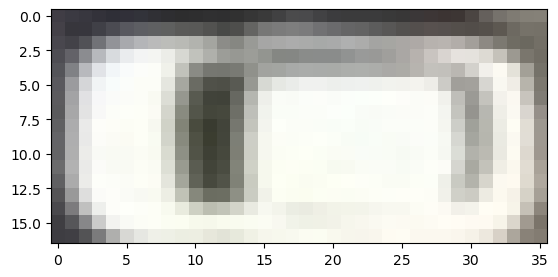

807


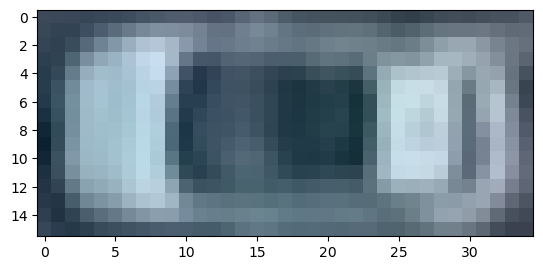

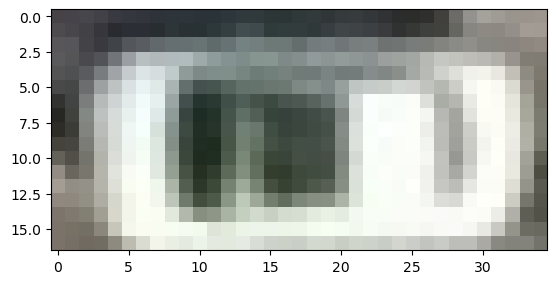

829


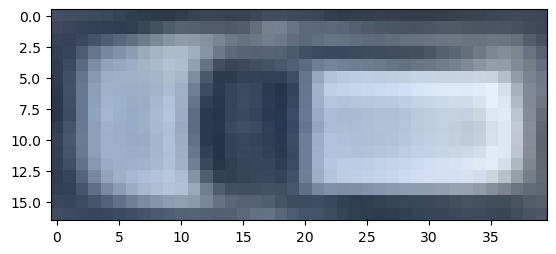

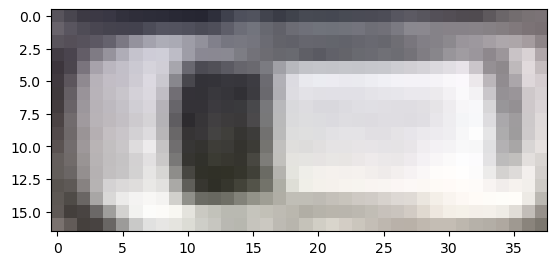

832


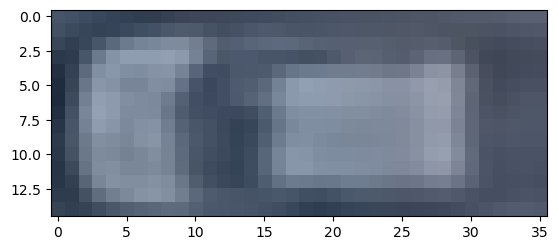

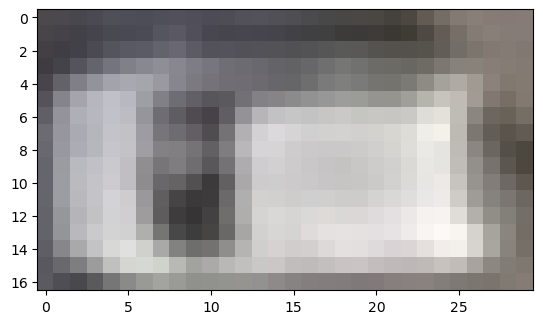

841


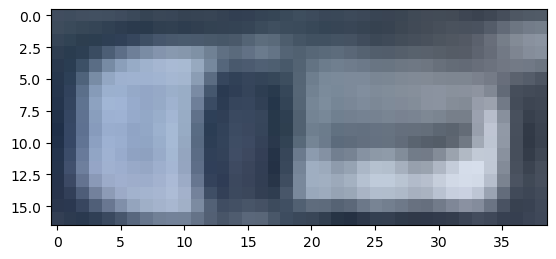

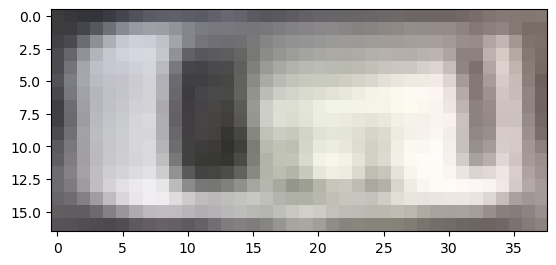

850


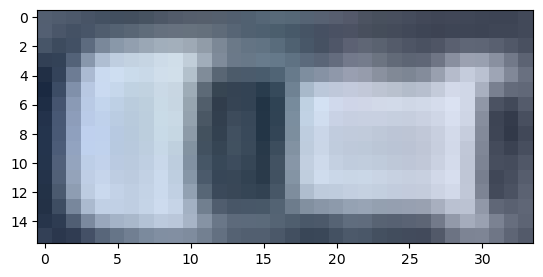

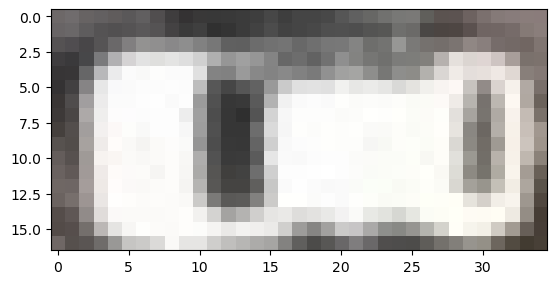

866


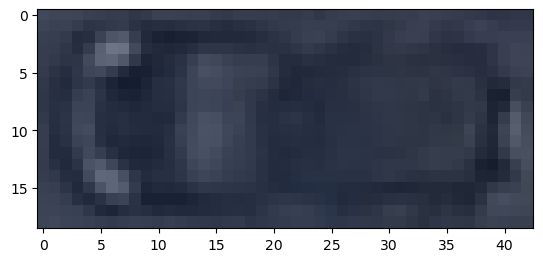

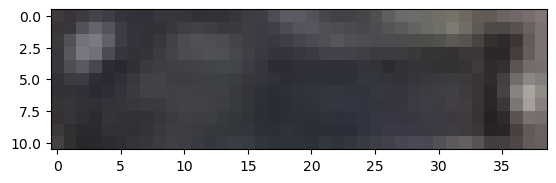

876


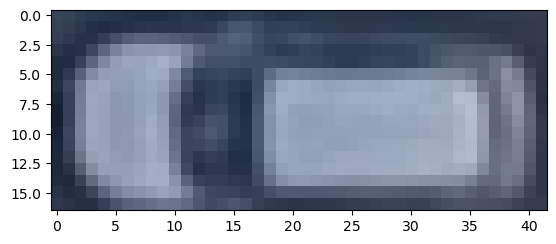

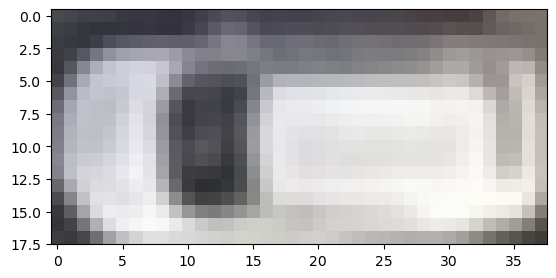

894


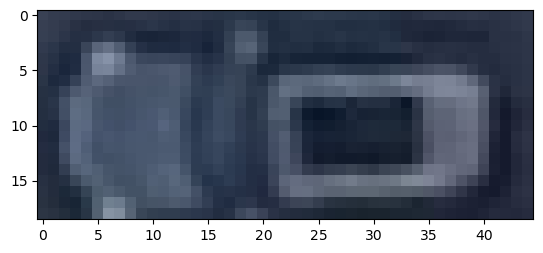

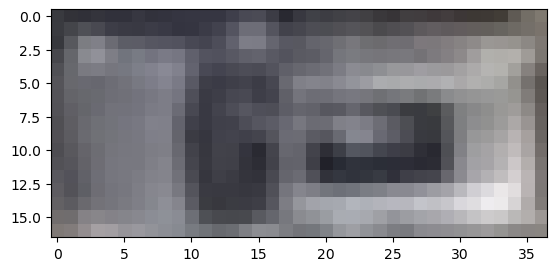

901


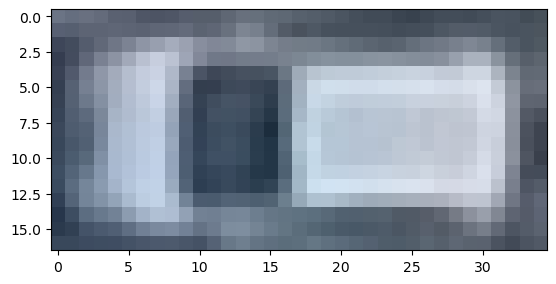

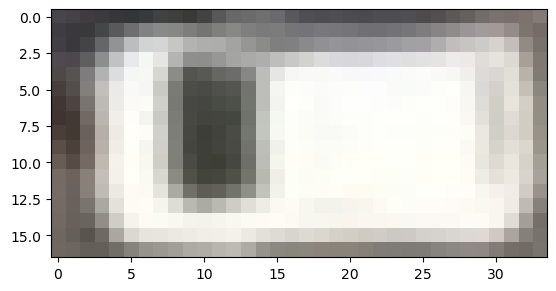

935


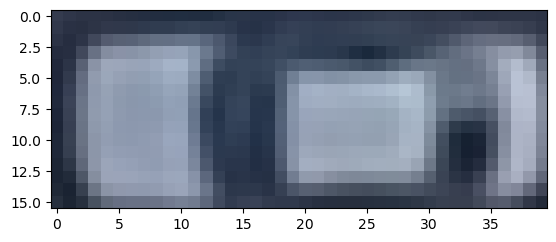

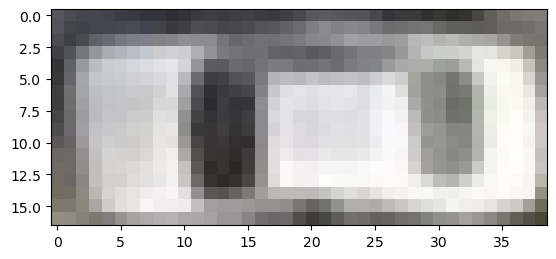

939


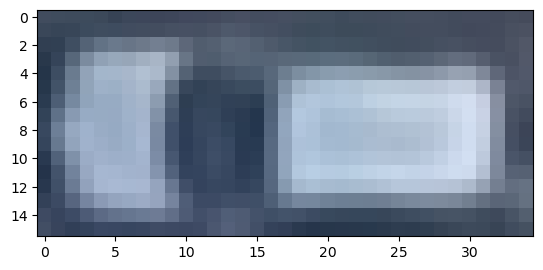

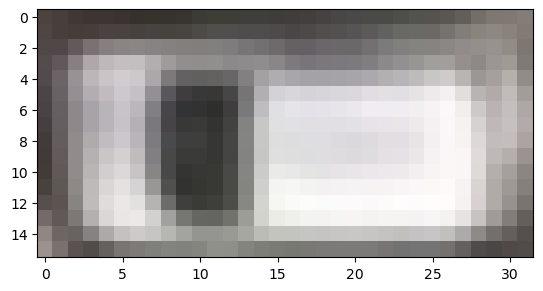

958


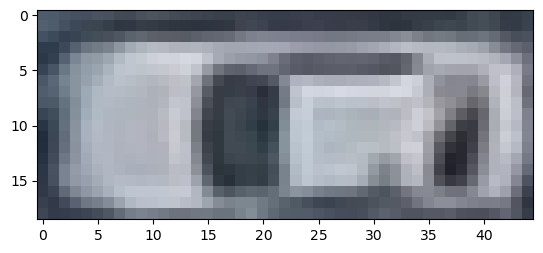

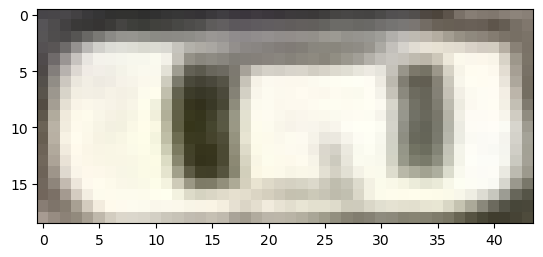

962


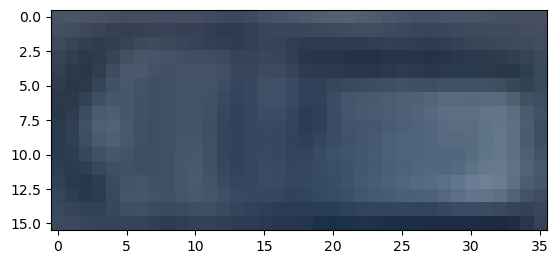

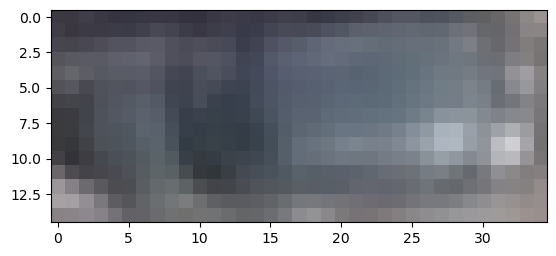

968


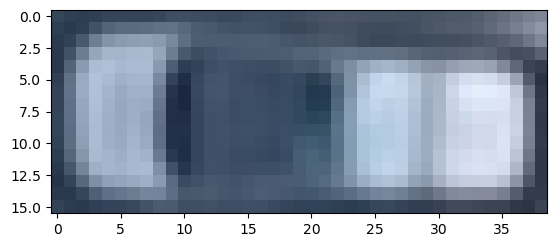

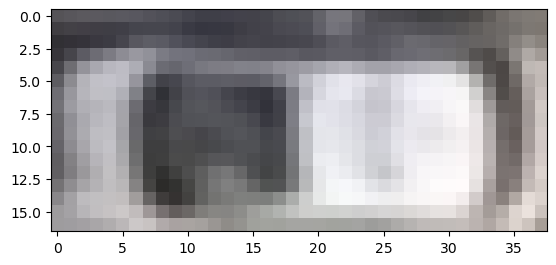

973


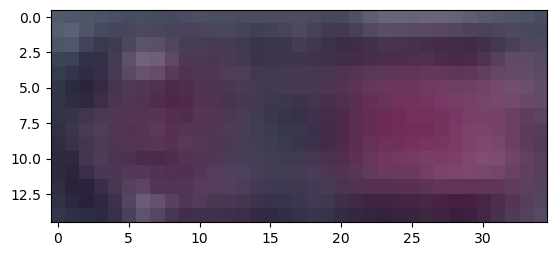

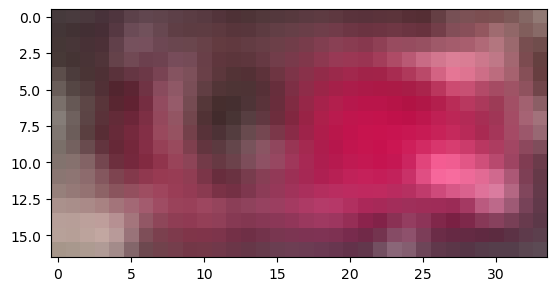

1078


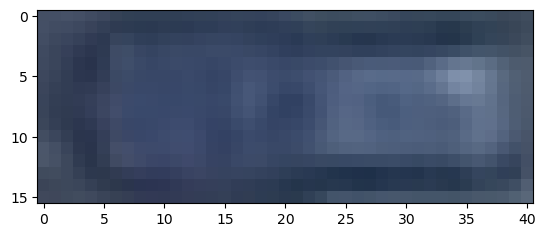

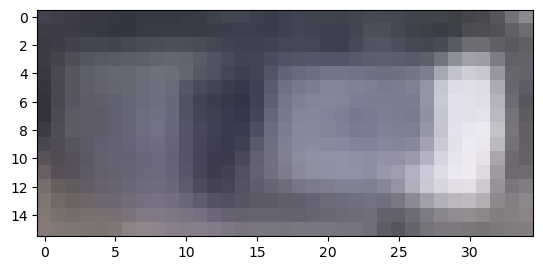

1084


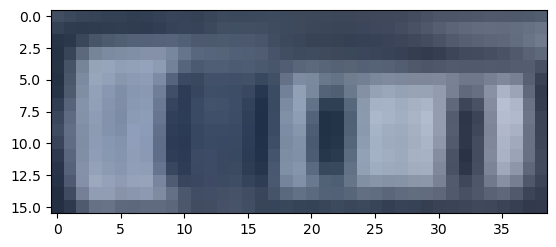

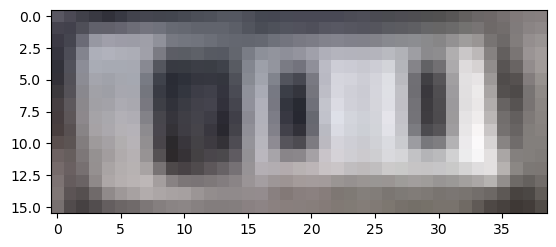

1086


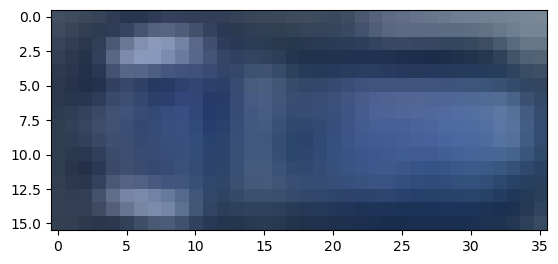

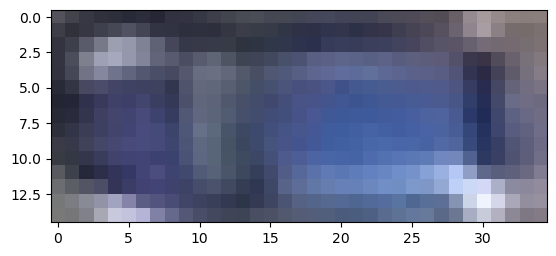

1096


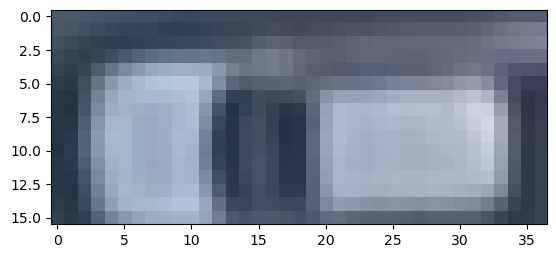

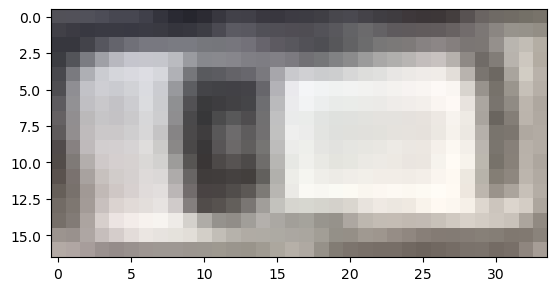

1115


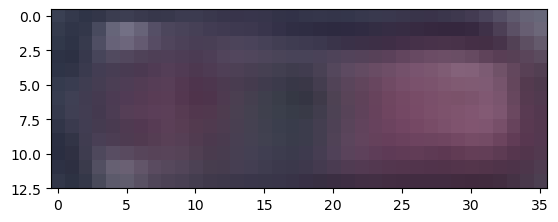

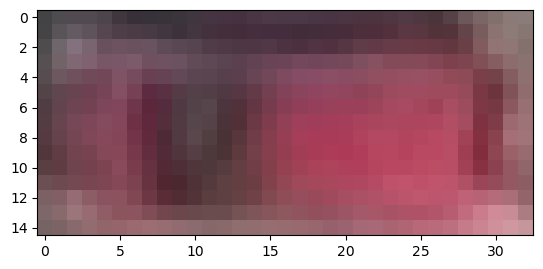

1119


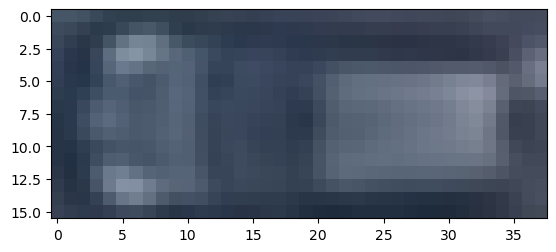

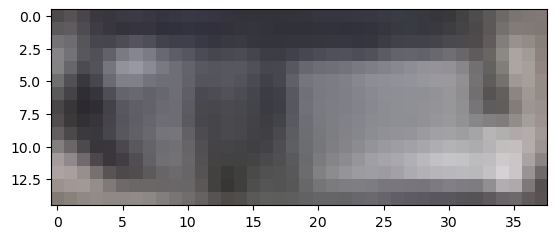

1127


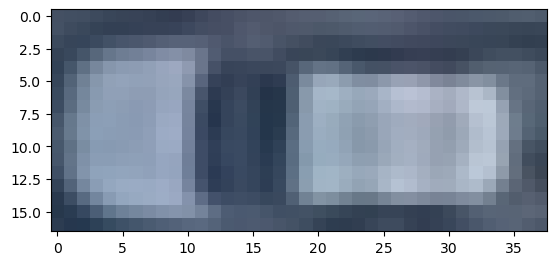

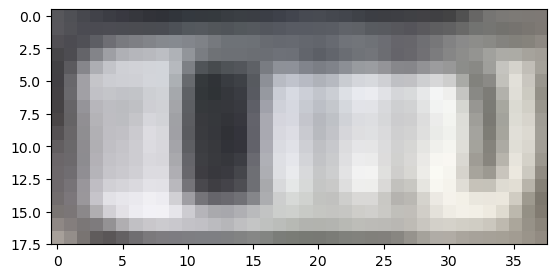

1130


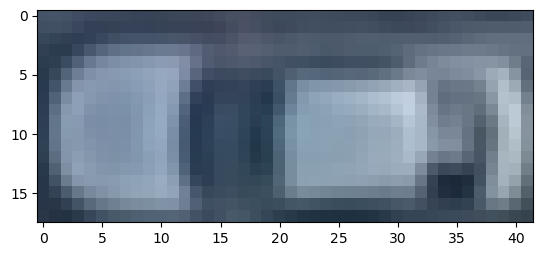

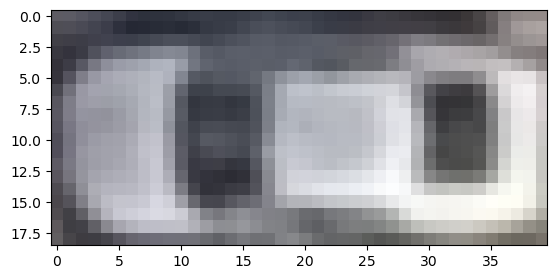

1145


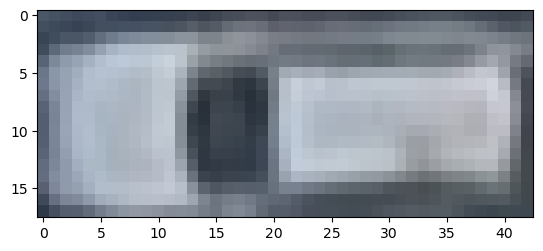

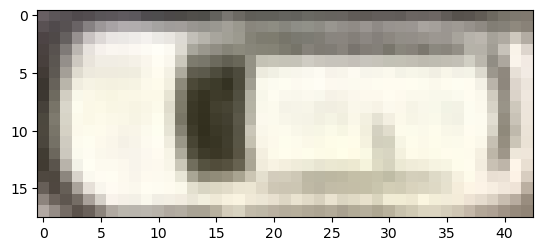

1150


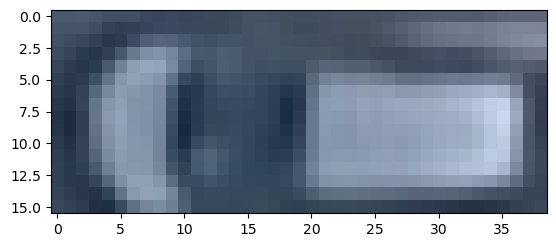

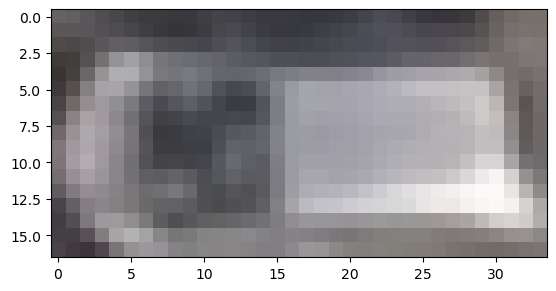

1185


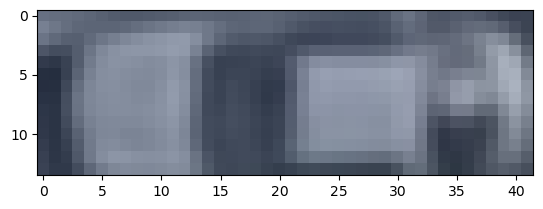

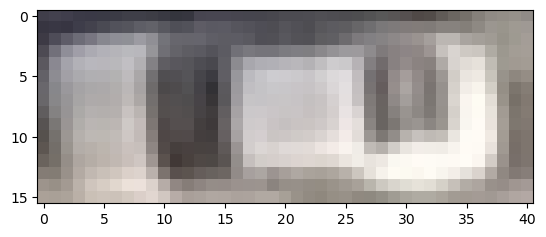

1194


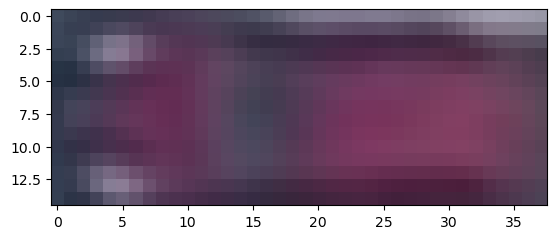

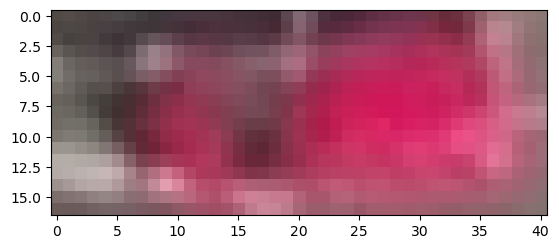

1211


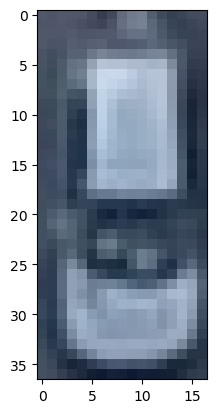

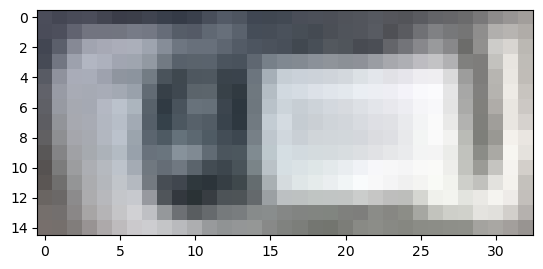

1228


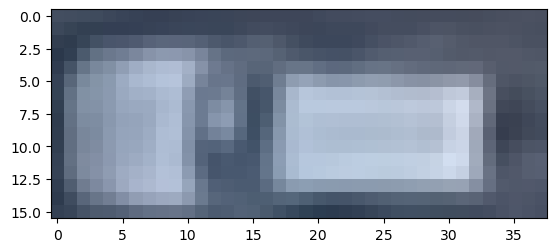

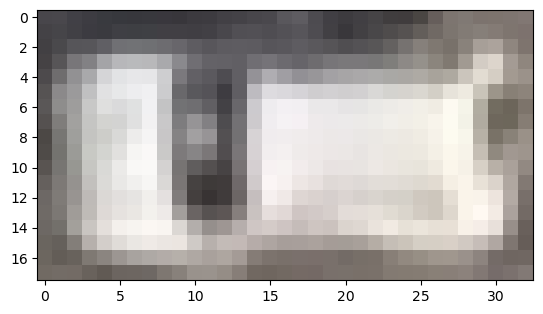

1238


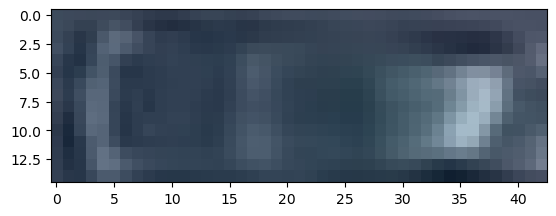

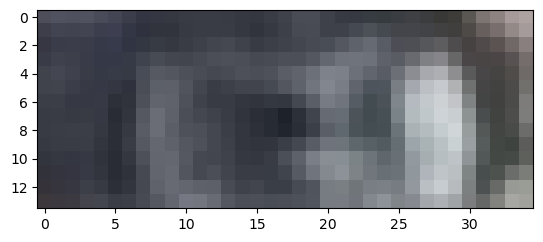

1267


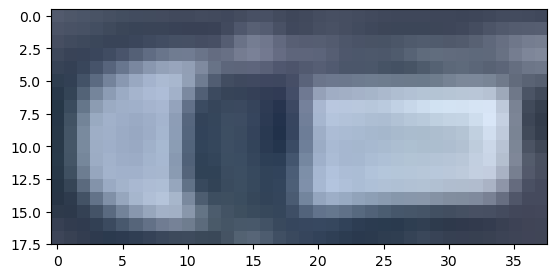

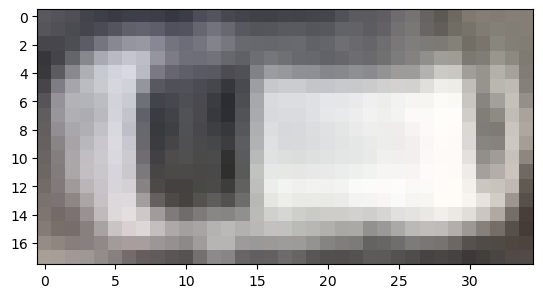

1311


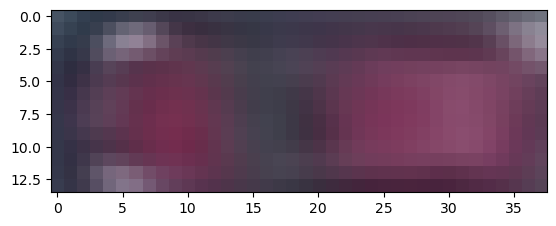

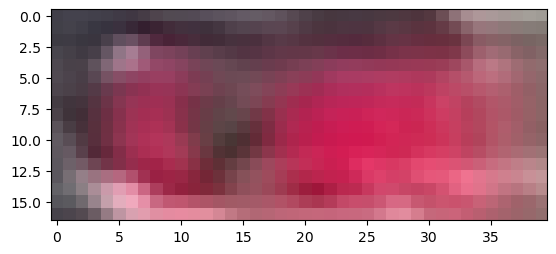

1321


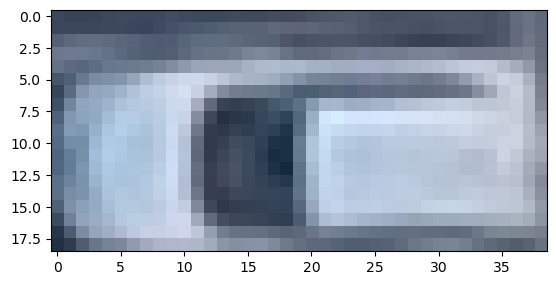

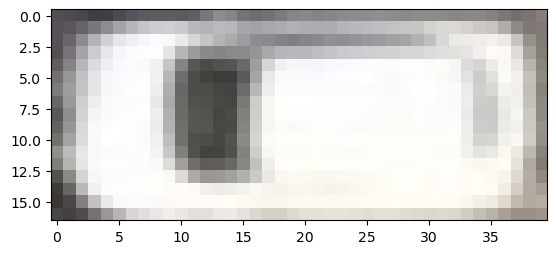

1341


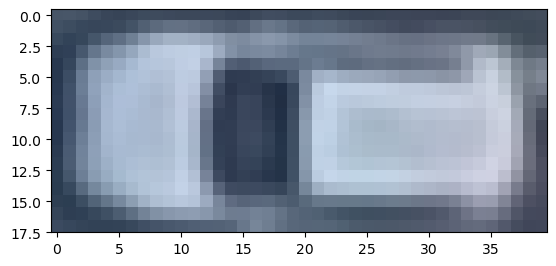

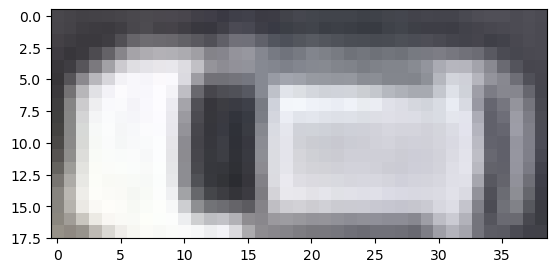

1343


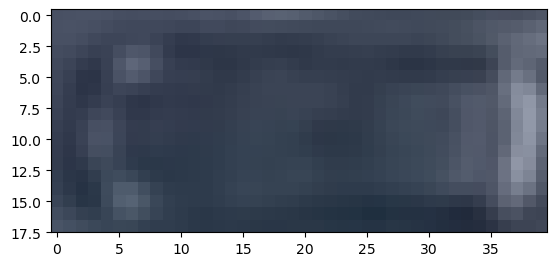

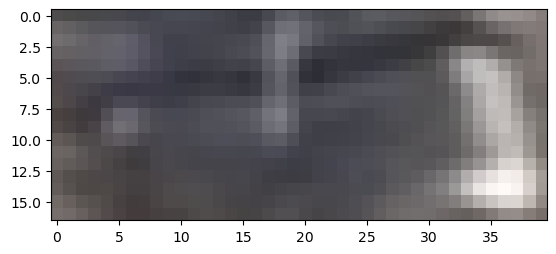

1345


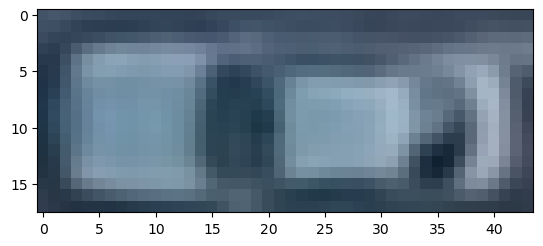

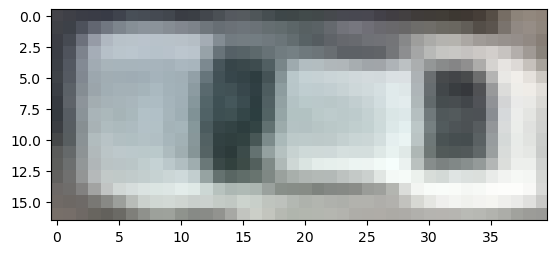

1356


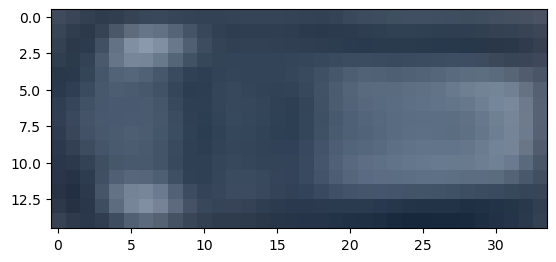

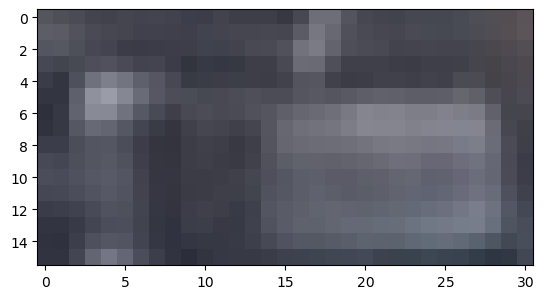

1369


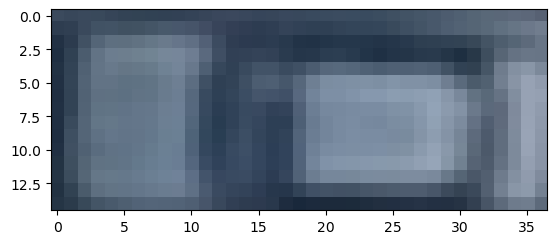

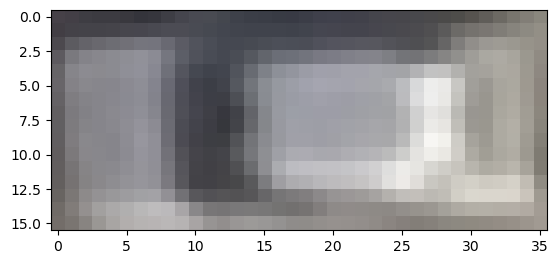

1376


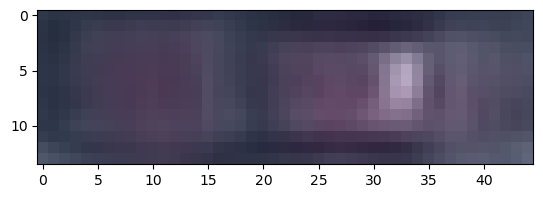

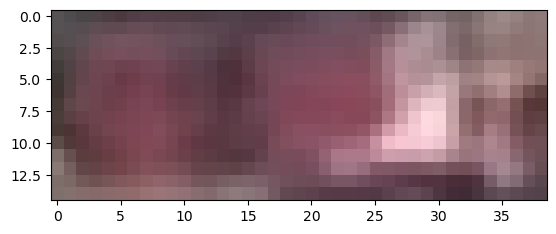

1378


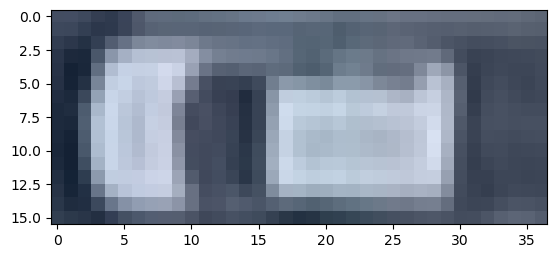

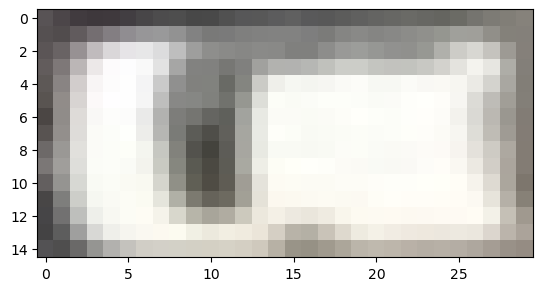

1410


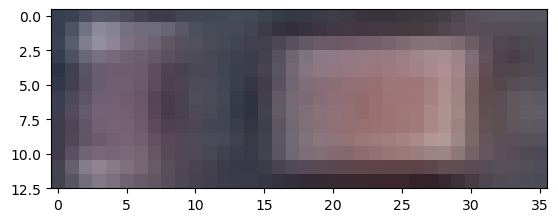

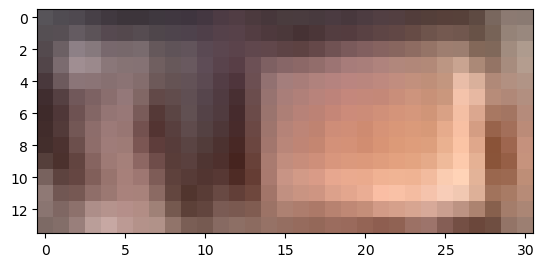

1443


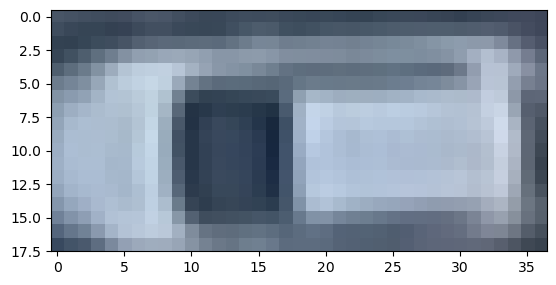

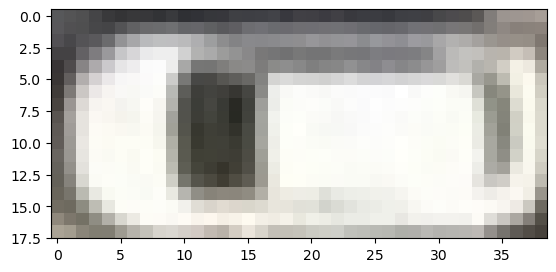

1445


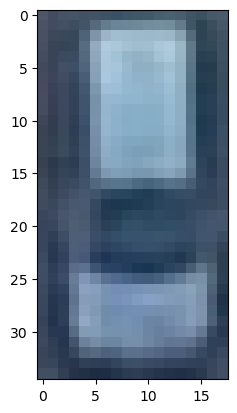

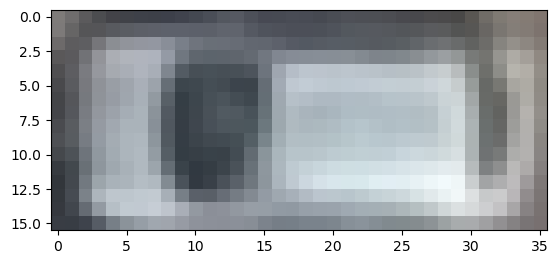

1457


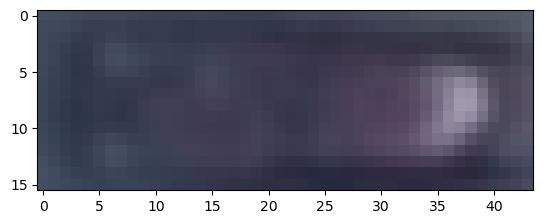

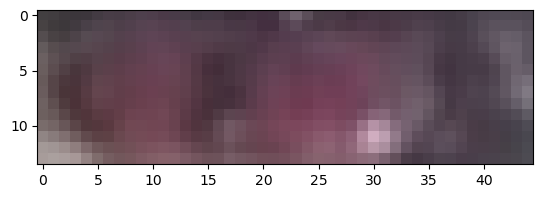

1475


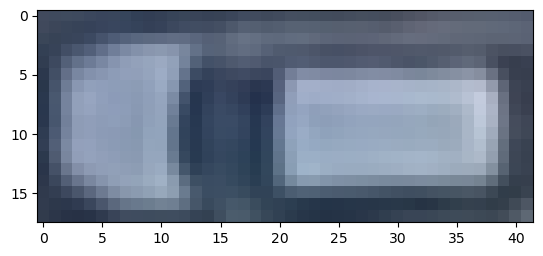

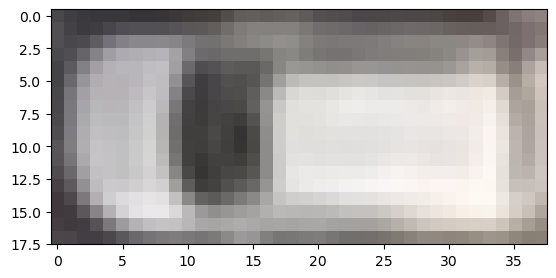

1517


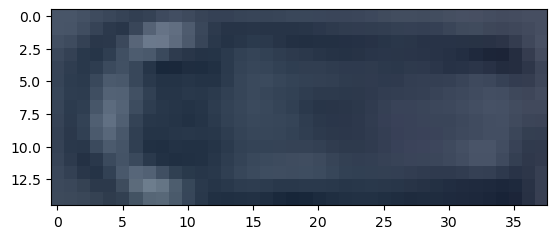

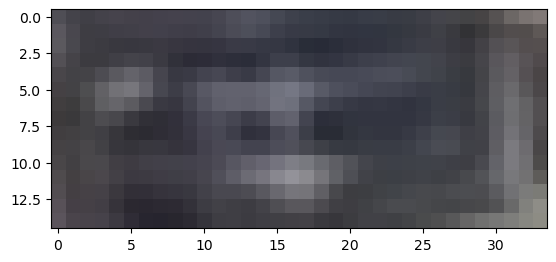

1532


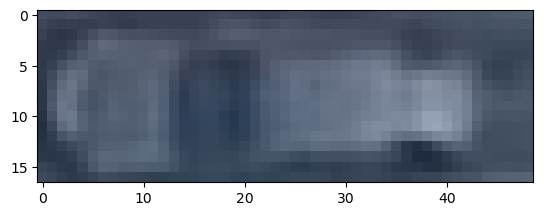

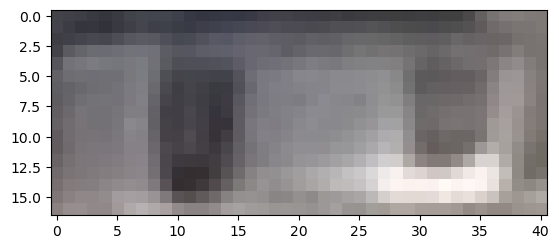

1543


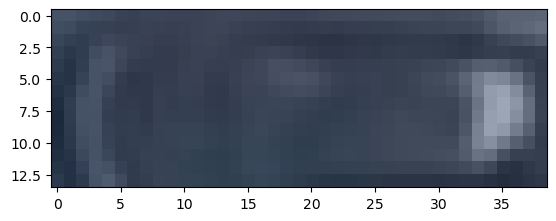

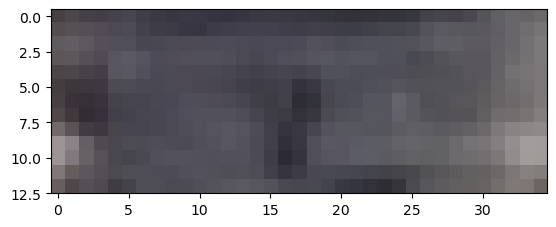

1545


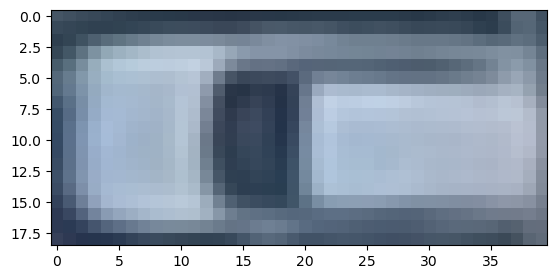

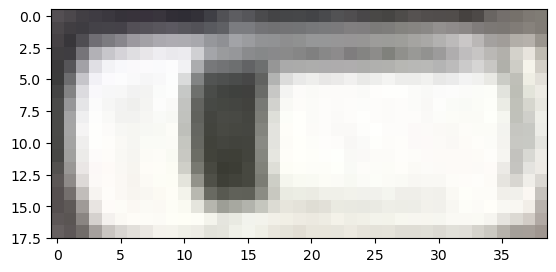

1552


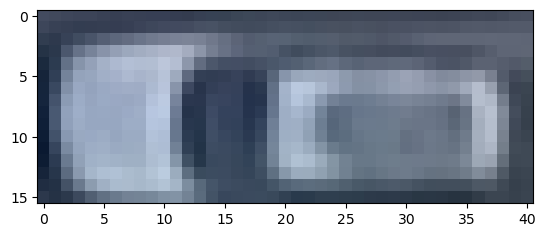

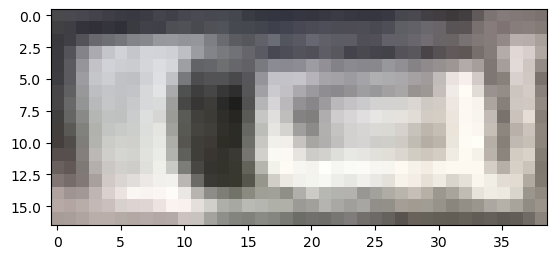

1572


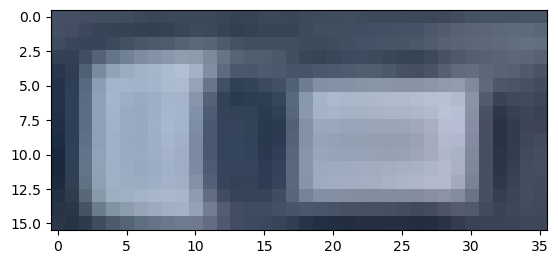

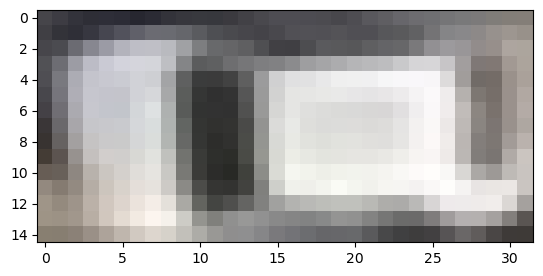

1574


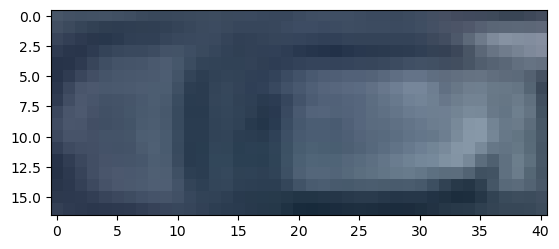

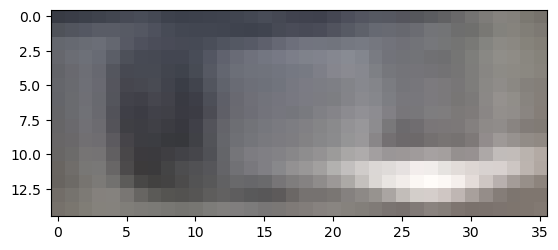

1595


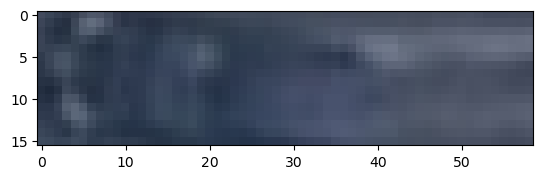

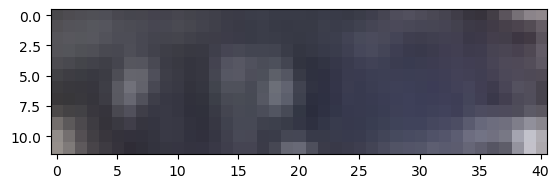

1612


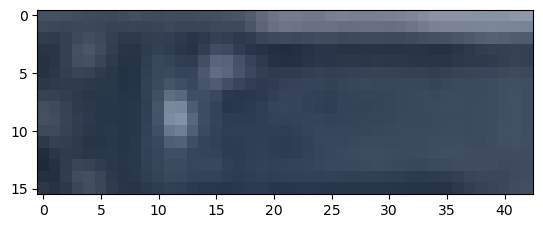

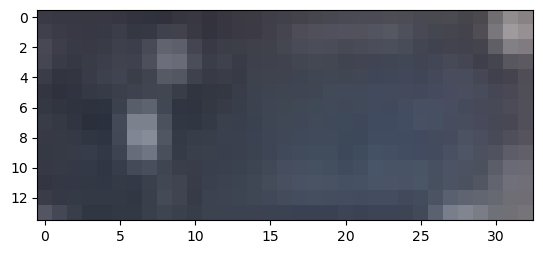

1619


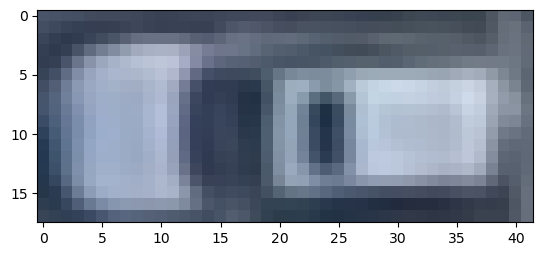

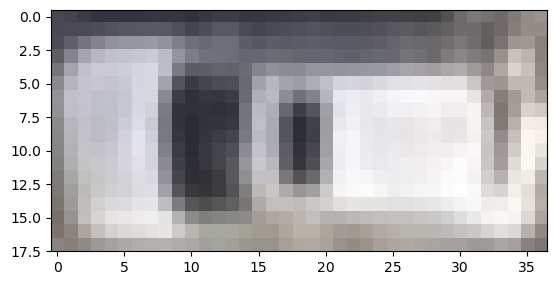

1654


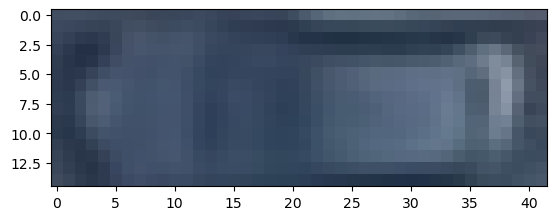

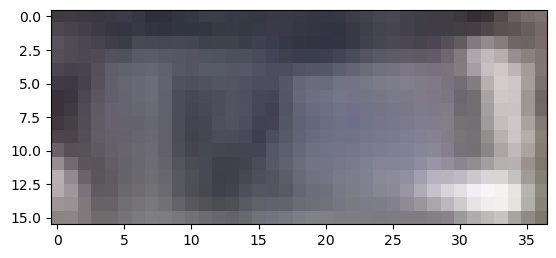

1728


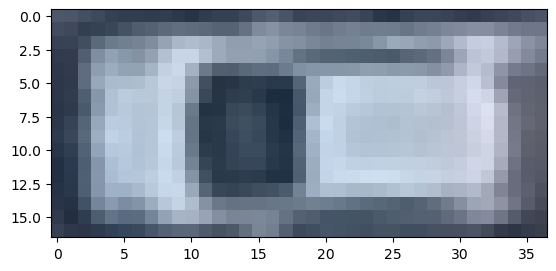

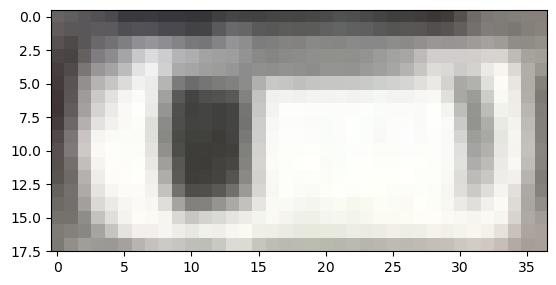

1733


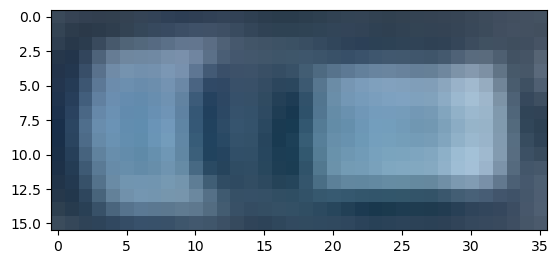

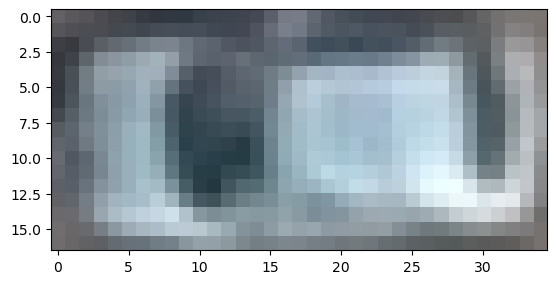

1752


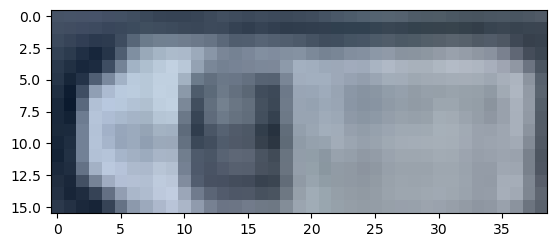

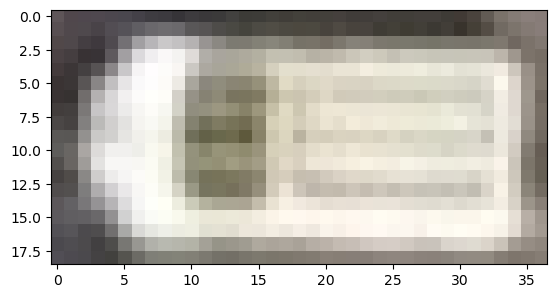

1767


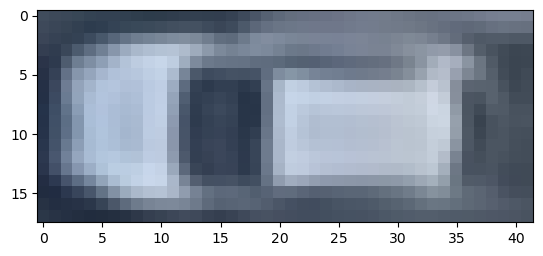

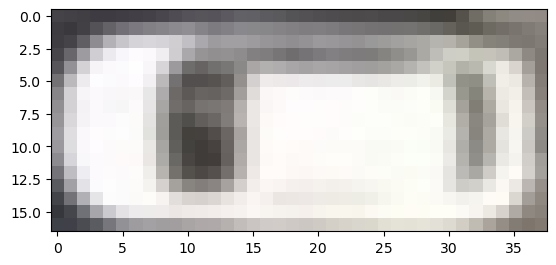

1775


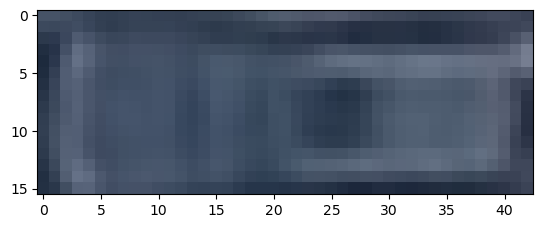

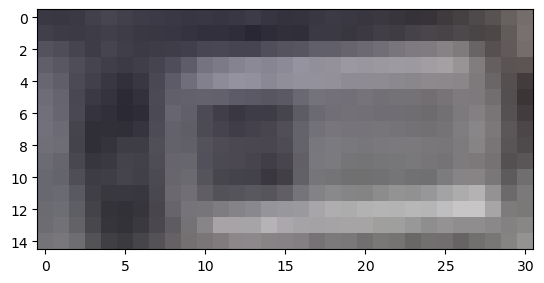

1777


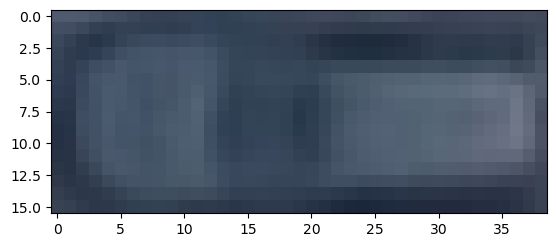

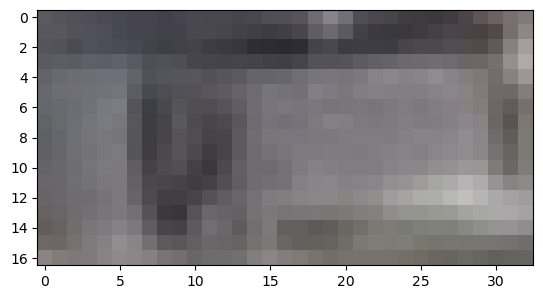

1778


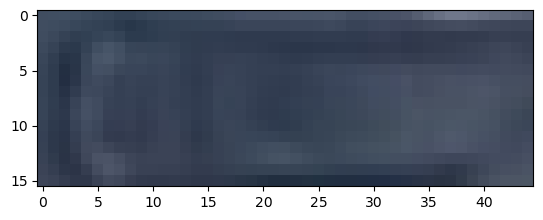

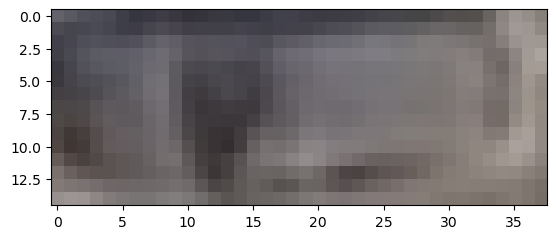

1779


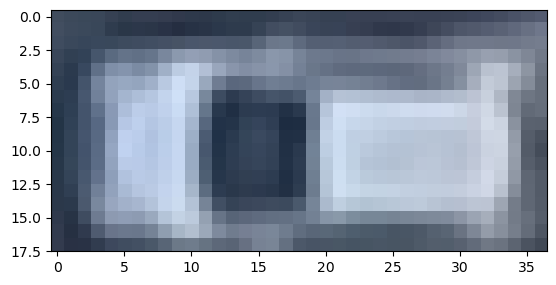

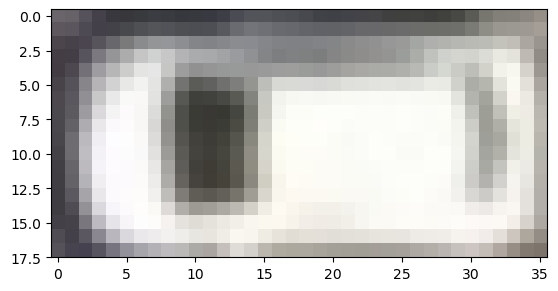

1786


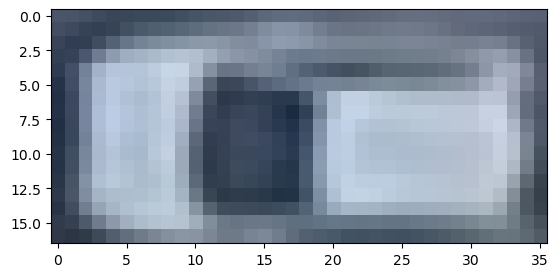

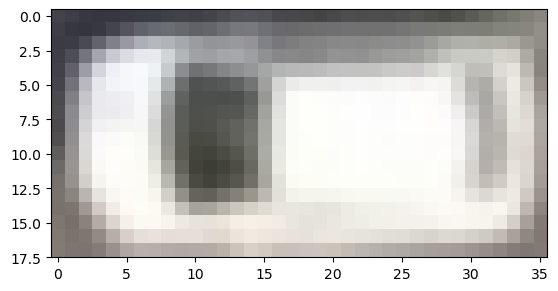

1790


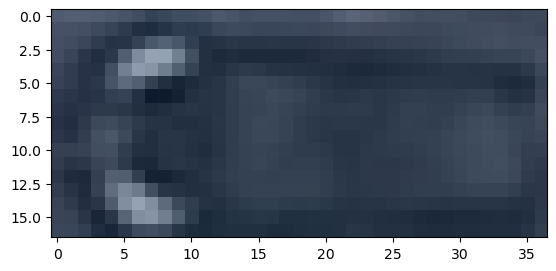

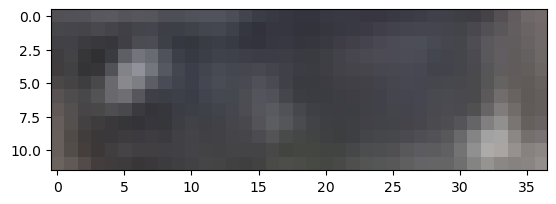

1808


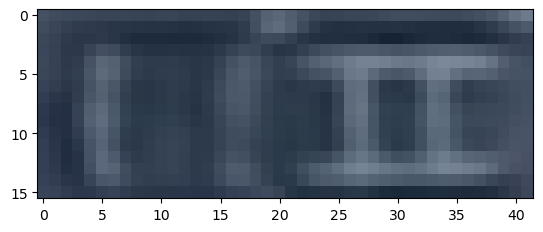

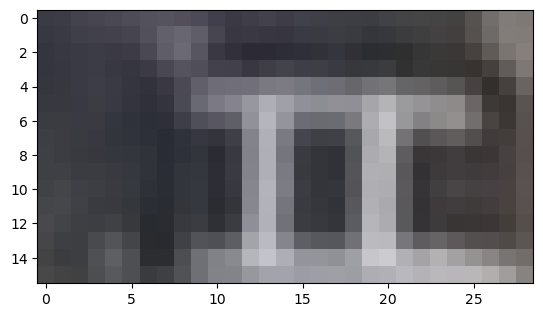

1822


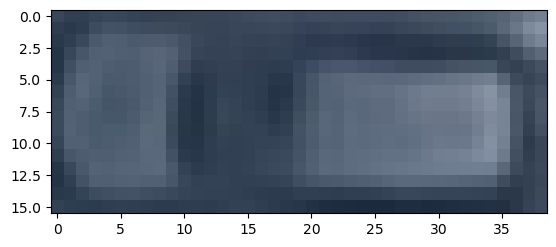

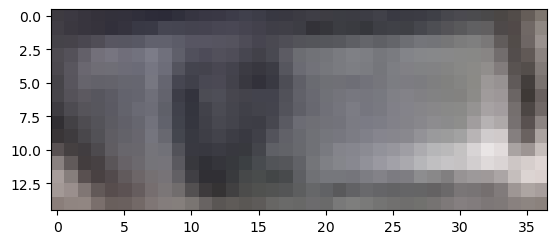

1861


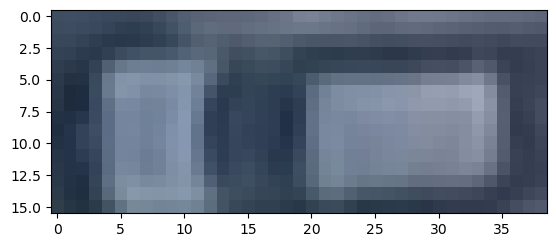

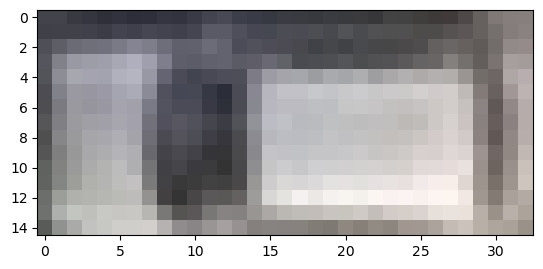

In [122]:
for k in v_patches_pair.keys():
    print(k)
    show_image_inline(v_patches_pair[k][0])
    show_image_inline(v_patches_pair[k][1])

## Visual Component : Strong Baseline 

In [112]:
import torch
from torch.backends import cudnn
import torchvision.transforms as T
import torchvision.transforms.functional as fn
from scipy.spatial import distance

In [113]:
# encoding: utf-8
class visual_reidentifier:
    from PIL import Image
    import sys
    sys.path.append('../reid-strong-baseline/')
    from config import cfg
    from data import make_data_loader, make_data_loader_single
    from engine.inference import inference
    from modeling import build_model
    from utils.logger import setup_logger
    
    model = None
    transform = None
    
    def __init__(self):
        num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1

        cfg.merge_from_file('/home/yura/ReID/reid-strong-baseline/configs/softmax_triplet_with_center.yml')
        cfg.merge_from_list(['MODEL.DEVICE_ID', "('0')", \
                            #'DATASETS.NAMES', "('vrai')", \
                            'DATASETS.ROOT_DIR', "('/home/yura/data')", \
                            'TEST.NECK_FEAT', "('after')", \
                            'TEST.FEAT_NORM', "('yes')", \
                            'MODEL.PRETRAIN_CHOICE', "('self')", \
                            'TEST.WEIGHT', "('../log_VRAI/resnet50_model_120.pth')"])
        cfg.freeze()

        if cfg.MODEL.DEVICE == "cuda":
            os.environ['CUDA_VISIBLE_DEVICES'] = cfg.MODEL.DEVICE_ID
        cudnn.benchmark = True

        #train_data, val_data, num_query, num_classes = make_data_loader_single(cfg, 0)
        #train_img, train_pid, train_camid, train_fp = train_data
        #val_img, val_pid, val_camid, val_fp = val_data

        model = build_model(cfg, 576) # VRAI dataset's train num classes = 576
        model.load_param(cfg.TEST.WEIGHT)
        
        self.model = model
        #print(model)
        
        
        normalize_transform = T.Normalize(mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD)
        transform = T.Compose([
                    T.Resize(cfg.INPUT.SIZE_TEST),
                    T.ToTensor(),
                    normalize_transform
                ])
        self.transform = transform
    
    def cosine_score(self, img_tuple):
        (img1, img2) = img_tuple
        img1, img2 = Image.fromarray(img1), Image.fromarray(img2)
        img1, img2 = self.transform(img1), self.transform(img2)
        
        #plt.imshow(np.moveaxis(img1.detach().numpy(), 0, -1))
        #plt.show()
        #plt.imshow(np.moveaxis(img2.detach().numpy(), 0, -1))
        #plt.show()

        batchsize = 64

        img1 = img1.unsqueeze(0).repeat(batchsize, 1, 1, 1)
        img2 = img2.unsqueeze(0).repeat(batchsize, 1, 1, 1)

        # model() output a tuple ([64, 576] and [64, 2048])
        # 576 = train size
        out1 = self.model(img1)
        out2 = self.model(img2)

        feat1 = out1[1].detach().numpy()[0]
        feat2 = out2[1].detach().numpy()[0]
        #print(feat1)
        #print(feat2)

        cos_dis = distance.cosine(feat1, feat2)

        #print("COSINE distance : ", cos_dis)
        return cos_dis



In [114]:
viz_reid = visual_reidentifier()

resnet50


In [327]:
len(v_patches_pair.keys())

126

In [324]:
viz_reid.cosine_score((cv2.imread("/home/yura/data/VRAI_/images_gallery/00000039_0002_00000001.jpg"), 
                       cv2.imread("/home/yura/data/VRAI_/images_gallery/00000039_0002_00000004.jpg")))

0.0008973479270935059

In [325]:
viz_reid.cosine_score((cv2.imread("/home/yura/data/VRAI_/images_gallery/00000074_0001_00000008.jpg"), 
                       cv2.imread("/home/yura/data/VRAI_/images_gallery/00000039_0002_00000004.jpg")))

0.0016788840293884277

In [328]:
viz_reid.cosine_score((v_patches_pair[222][0], v_patches_pair[222][1]))

0.0016196370124816895

In [329]:
viz_reid.cosine_score((v_patches_pair[222][0], v_patches_pair[438][1]))

0.00205075740814209

In [330]:
viz_reid.cosine_score((v_patches_pair[222][0], v_patches_pair[1654][0]))

0.001464545726776123

In [125]:
v_patches_pair_sim = {}
for k in v_patches_pair.keys():
    v_patches_pair_sim[k] = viz_reid.cosine_score(v_patches_pair[k])

In [140]:
v_patches_pair_mis_sim = {}
for k in v_patches_pair.keys():
    k_mis = random.sample(set(v_patches_pair.keys()) - set([k]), 1)[0]
    v_patches_pair_mis_sim[k] = viz_reid.cosine_score((v_patches_pair[k][0], v_patches_pair[k_mis][1]))

In [155]:
import matplotlib.pyplot as plt

In [172]:
len(v_patches_pair_sim.keys())

126

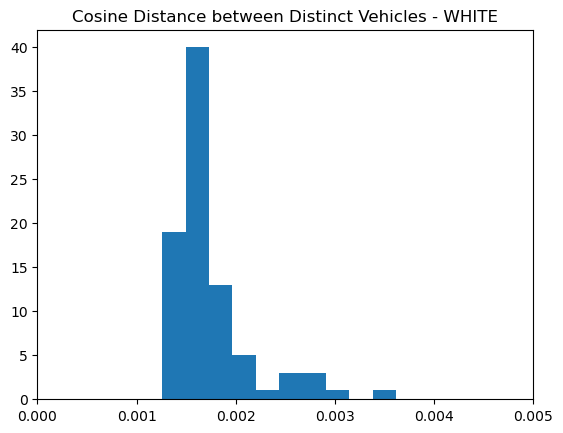

In [188]:
fig, ax = plt.subplots()
ax.hist([v_patches_pair_mis_sim[k] for k in white])
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between Distinct Vehicles - WHITE")
plt.show()

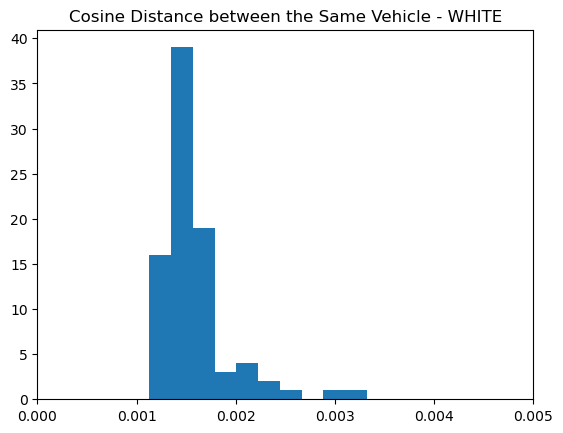

In [189]:
fig, ax = plt.subplots()
ax.hist([v_patches_pair_sim[k] for k in white])
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between the Same Vehicle - WHITE")
plt.show()

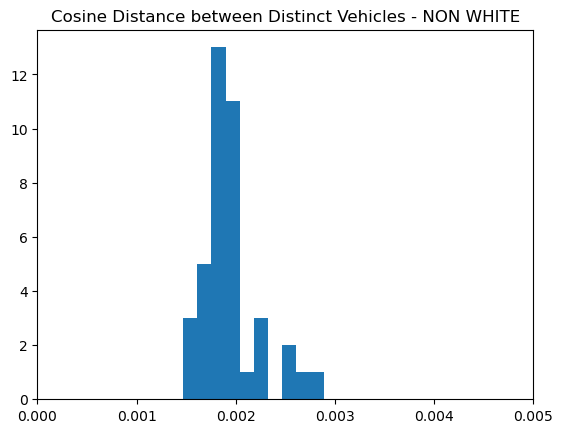

In [190]:
fig, ax = plt.subplots()
ax.hist([v_patches_pair_mis_sim[k] for k in non_white])
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between Distinct Vehicles - NON WHITE")
plt.show()

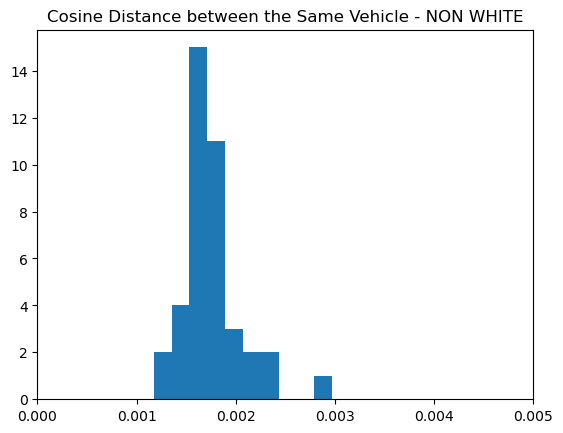

In [191]:
fig, ax = plt.subplots()
ax.hist([v_patches_pair_sim[k] for k in non_white])
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between the Same Vehicle - NON WHITE")
plt.show()

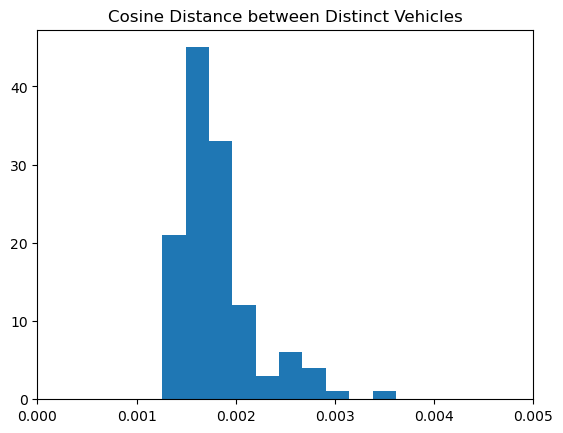

In [169]:
fig, ax = plt.subplots()
ax.hist(list(v_patches_pair_mis_sim.values()))
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between Distinct Vehicles")
plt.show()

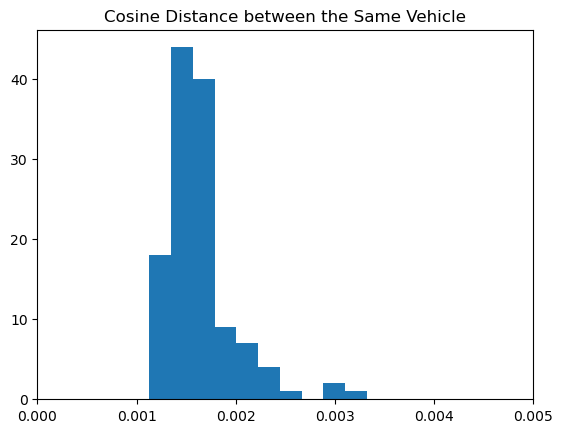

In [170]:
fig, ax = plt.subplots()
ax.hist(list(v_patches_pair_sim.values()))
ax.set_xlim([0, 0.005])
plt.title("Cosine Distance between the Same Vehicle")
plt.show()

## Temporal Component

In [211]:
def get_label(v_id, travel_time):
    return travel_time[v_id]


# Current set of Features = [Timestamp (hour, min, sec) as total second value + historical pixel position]
def get_v_feature(v_id, start_dict, historical_nb=0):
    def _get_v_position(v_id, annot):
        feat = annot[annot.ID == v_id][["x_img [px]", "y_img [px]"]].values[0].tolist()
        return feat
    
    def _get_v_timestamp(v_id, annot):
        feat = annot[annot.ID == v_id]["AbsTime [s]"].values[0]
        return feat
    
    # based on y pixel position
    # Output : lane 1, 2, 3, 4 : leftmost lane == 1
    def _get_manual_lane(y_pos):
        if y_pos > 1180:
            return 4
        elif y_pos > 1157:
            return 3
        elif y_pos > 1128:
            return 2
        else:
            return 1
        
    def _get_v_lane(v_id, annot):
        feat = _get_manual_lane(annot[annot.ID == v_id]["y_img [px]"].values[0])
        return feat
    
    frame_nb = get_frame_nb(start_dict[v_id])
    
    #_, annot = get_frame_annot("%05d" % (frame_nb))
    v_feat = [] #[_get_v_timestamp(v_id, annot), _get_v_lane(v_id, annot)]
    
    for i in range(historical_nb+1):
        _, annot = get_frame_annot("%05d" % (frame_nb-i), annot_post_process=False)
        v_feat.append(_get_v_position(v_id, annot))
        
    return v_feat

#feat = get_v_feature(60, start_dict, historical_nb=10)

In [221]:
Xs_train = []
ys_train = []
for tr_v_id in tqdm(train_v_ids):
    if tr_v_id == 162:
        continue
    X = get_v_feature(tr_v_id, start_dict, historical_nb=HISTORICAL_NB)
    y = get_label(tr_v_id, travel_time)
    
    Xs_train.append(X)
    ys_train.append(y)
    
Xs_train = np.array(Xs_train).reshape(len(Xs_train), -1)
ys_train = np.array(ys_train)

100%|█████████████████████████████████████████| 120/120 [02:11<00:00,  1.10s/it]


In [222]:
Xs_test = []
ys_test = []
for ts_v_id in tqdm(test_v_ids):
    X = get_v_feature(ts_v_id, start_dict, historical_nb=HISTORICAL_NB)
    y = get_label(ts_v_id, travel_time)
    
    Xs_test.append(X)
    ys_test.append(y)
    
Xs_test = np.array(Xs_test).reshape(len(Xs_test), -1)
ys_test = np.array(ys_test)

100%|███████████████████████████████████████████| 52/52 [00:56<00:00,  1.09s/it]


In [60]:
Xs_train_0 = []
ys_train_0 = []
for tr_v_id in train_v_ids:
    X = get_v_feature(tr_v_id, start_dict, historical_nb=0)
    y = get_label(tr_v_id, travel_time)
    
    Xs_train_0.append(X)
    ys_train_0.append(y)
    
Xs_train_0 = np.array(Xs_train_0).reshape(len(Xs_train_0), -1)
ys_train_0 = np.array(ys_train_0)

In [61]:
list(map(lambda x: x[0], Xs_train_0))

[3071,
 3072,
 3076,
 3084,
 3086,
 3071,
 3080,
 3088,
 3079,
 3079,
 3081,
 3097,
 3074,
 3101,
 3100,
 3079,
 3068,
 3094,
 3080,
 3069,
 3081,
 3075,
 3063,
 3077,
 3063,
 3074,
 3077,
 3073,
 3098,
 3078,
 3072,
 3077,
 3074,
 3089,
 3076,
 3072,
 3096,
 3076,
 3092,
 3084,
 3074,
 3061,
 3072,
 3071,
 3091,
 3071,
 3074,
 3064,
 3086,
 3100,
 3064,
 3096,
 3080,
 3070,
 3067,
 3082,
 3081,
 3083,
 3079,
 3076,
 3071,
 3091,
 3077,
 3072,
 3078,
 3090,
 3073,
 3087,
 3073,
 3075,
 3083,
 3086,
 3081,
 3096,
 3070,
 3079,
 3068,
 3076,
 3078,
 3077,
 3086,
 3065,
 3065,
 3087,
 3071,
 3078,
 3077,
 3063,
 3086,
 3066,
 3088,
 3069,
 3067,
 3082,
 3073,
 3077,
 3090,
 3072,
 3068,
 3084,
 3086,
 3063,
 3076,
 3094,
 3079,
 3073,
 3104,
 3064,
 3063,
 3069,
 3079,
 3077,
 3072,
 3088,
 3068,
 3085,
 3066,
 3088,
 3064,
 3086,
 3077]

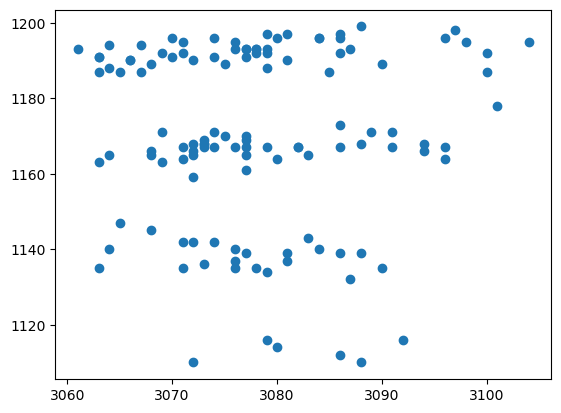

In [72]:
plt.scatter(list(map(lambda x: x[0], Xs_train_0)), list(map(lambda x: x[1], Xs_train_0)))

In [306]:
ys_train.mean()

40.084033613445385

In [277]:
print(mean_squared_error([36 for _ in range(ys_test.shape[0])], ys_test, squared=False))

23.008092221918528


In [305]:
ys_test.std()

22.304556808819804

In [310]:
print(mean_squared_error([np.mean(ys_train) for _ in range(ys_test.shape[0])], ys_test, squared=False))

22.359192160257198


In [273]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

Xs_train_normalized = normalize(Xs_train, norm='l2')
Xs_test_normalized = normalize(Xs_test, norm='l2')
reg = LinearRegression().fit(Xs_train_normalized, ys_train)
print(reg.score(Xs_train_normalized, ys_train))
print(reg.score(Xs_test_normalized, ys_test))
                                   
print(mean_squared_error(ys_test, reg.predict(Xs_test_normalized), squared=False))

0.35736736491934096
0.021214227684961395
22.06670159463105


In [234]:
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import normalize

Xs_train_normalized = normalize(Xs_train, norm='l2')
Xs_test_normalized = normalize(Xs_test, norm='l2')
reg = PoissonRegressor().fit(Xs_train_normalized, ys_train)
print(reg.score(Xs_train_normalized, ys_train))
print(reg.score(Xs_test_normalized, ys_test))

print(mean_squared_error(ys_test, reg.predict(Xs_test_normalized)))

9.800599616316408e-05
-0.005483634516093794
499.9137438586092


In [320]:
from sklearn.neural_network import MLPRegressor

Xs_train_normalized = normalize(Xs_train, norm='l2')
Xs_test_normalized = normalize(Xs_test, norm='l2')

reg = MLPRegressor(hidden_layer_sizes=(32,), random_state=1, max_iter=300).fit(Xs_train_normalized, ys_train)

print(reg.score(Xs_train_normalized, ys_train))
print(reg.score(Xs_test_normalized, ys_test))

print(mean_squared_error(ys_test, reg.predict(Xs_test_normalized), squared=False))

-1.505173222720753
-1.1688748255523675
32.848144474725125


In [322]:
# first neural network with keras tutorial
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses

# load the dataset
# split into input (X) and output (y) variables
#X = dataset[:,0:8]
#y = dataset[:,8]
# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(22,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation=None))
# compile the keras model
model.compile(loss=losses.MeanSquaredError(), optimizer='adam', metrics=['mse'])
# fit the keras model on the dataset
model.fit(Xs_train_normalized, ys_train, epochs=150, batch_size=10)
# evaluate the keras model
ys_test_pred = model.predict(Xs_test_normalized)
print('MSE: %.2f' % (mean_squared_error(ys_test, ys_test_pred, squared=False)))

Epoch 1/150
12/12 [==============================] - 0s 3ms/step - loss: 2028.6532 - mse: 2028.6532
Epoch 2/150
12/12 [==============================] - 0s 2ms/step - loss: 1966.9274 - mse: 1966.9274
Epoch 3/150
12/12 [==============================] - 0s 2ms/step - loss: 2019.1826 - mse: 2019.1826
Epoch 4/150
12/12 [==============================] - 0s 2ms/step - loss: 2004.1546 - mse: 2004.1546
Epoch 5/150
12/12 [==============================] - 0s 2ms/step - loss: 2010.1131 - mse: 2010.1132
Epoch 6/150
12/12 [==============================] - 0s 2ms/step - loss: 2006.8446 - mse: 2006.8446
Epoch 7/150
12/12 [==============================] - 0s 2ms/step - loss: 2229.3485 - mse: 2229.3485
Epoch 8/150
12/12 [==============================] - 0s 2ms/step - loss: 1909.2062 - mse: 1909.2062
Epoch 9/150
12/12 [==============================] - 0s 2ms/step - loss: 1874.6083 - mse: 1874.6083
Epoch 10/150
12/12 [==============================] - 0s 2ms/step - loss: 1699.3686 - mse: 1699.3686

In [285]:
Xs_train

array([[3061, 1100, 3081, ..., 1117, 3210, 1118],
       [3086, 1167, 3104, ..., 1172, 3257, 1171],
       [3064, 1192, 3084, ..., 1194, 3204, 1195],
       ...,
       [3084, 1196, 3104, ..., 1198, 3274, 1198],
       [3100, 1187, 3129, ..., 1193, 3371, 1193],
       [3088, 1110, 3103, ..., 1117, 3203, 1117]])

In [286]:
Xs_train.shape

(119, 22)

In [290]:
Xs_train_normalized.reshape(Xs_train.shape[0], int(Xs_train.shape[1]/2), 2)

array([[[0.2766, 0.0994],
        [0.2784, 0.0999],
        [0.2803, 0.1003],
        ...,
        [0.2882, 0.1009],
        [0.2892, 0.1009],
        [0.2901, 0.101 ]],

       [[0.275 , 0.104 ],
        [0.2766, 0.1042],
        [0.2782, 0.1043],
        ...,
        [0.2875, 0.1044],
        [0.2889, 0.1044],
        [0.2903, 0.1044]],

       [[0.2747, 0.1069],
        [0.2765, 0.107 ],
        [0.2781, 0.1071],
        ...,
        [0.2855, 0.1071],
        [0.2864, 0.107 ],
        [0.2873, 0.1071]],

       ...,

       [[0.2737, 0.1061],
        [0.2755, 0.1063],
        [0.2772, 0.1064],
        ...,
        [0.2869, 0.1063],
        [0.2887, 0.1063],
        [0.2906, 0.1063]],

       [[0.271 , 0.1038],
        [0.2735, 0.1039],
        [0.2759, 0.1041],
        ...,
        [0.2902, 0.1043],
        [0.2925, 0.1043],
        [0.2947, 0.1043]],

       [[0.2784, 0.1001],
        [0.2797, 0.1002],
        [0.281 , 0.1003],
        ...,
        [0.2877, 0.1007],
        [0.2883

In [287]:
Xs_train.reshape(119, 11, 2)

array([[[3061, 1100],
        [3081, 1105],
        [3102, 1110],
        ...,
        [3189, 1117],
        [3200, 1117],
        [3210, 1118]],

       [[3086, 1167],
        [3104, 1169],
        [3122, 1170],
        ...,
        [3226, 1172],
        [3242, 1172],
        [3257, 1171]],

       [[3064, 1192],
        [3084, 1194],
        [3102, 1195],
        ...,
        [3185, 1195],
        [3195, 1194],
        [3204, 1195]],

       ...,

       [[3084, 1196],
        [3104, 1198],
        [3123, 1199],
        ...,
        [3233, 1198],
        [3253, 1198],
        [3274, 1198]],

       [[3100, 1187],
        [3129, 1189],
        [3156, 1191],
        ...,
        [3320, 1193],
        [3346, 1193],
        [3371, 1193]],

       [[3088, 1110],
        [3103, 1112],
        [3117, 1113],
        ...,
        [3191, 1117],
        [3198, 1117],
        [3203, 1117]]])

In [ ]:
np.array([[] for xs in Xs_train])

In [296]:
import tensorflow as tf

In [301]:
# first neural network with keras tutorial
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import losses

# load the dataset
# split into input (X) and output (y) variables
#X = dataset[:,0:8]
#y = dataset[:,8]
# define the keras model
#model = Sequential()
model.add(LSTM(16, activation="tanh"))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation=None))
# compile the keras model
model.compile(loss=losses.MeanSquaredError(), optimizer='adam', metrics=['mse'])
# fit the keras model on the dataset

tmp_train = tf.convert_to_tensor(Xs_train_normalized.reshape(Xs_train.shape[0], int(Xs_train.shape[1]/2), 2), dtype=tf.float32)
tmp_test = Xs_test_normalized.reshape(Xs_test.shape[0], int(Xs_test.shape[1]/2), 2)
model.fit(tmp_train, tf.convert_to_tensor(ys_train, dtype=tf.float32), epochs=150, batch_size=10)
# evaluate the keras model
ys_test_pred = model.predict(tmp_test)
print('MSE: %.2f' % (mean_squared_error(ys_test, ys_test_pred)))

Epoch 1/150


NotImplementedError: in user code:

    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:643 get_initial_state
        inputs=None, batch_size=batch_size, dtype=dtype)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2507 get_initial_state
        self, inputs, batch_size, dtype))
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:6 prod
        
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3052 prod
        keepdims=keepdims, initial=initial, where=where)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/yura/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:855 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_21/lstm_4/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
